In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pyFBS
%matplotlib inline

# Cenilke

Naredimo enakomerno razdeljen array velikosti 256000. T predstavlja ta array, dt pa korak arraya.

In [2]:
import lvm_read
t ,dt = np.linspace(0,1,25600,endpoint=False, retstep=True)
datoteka1 = 'tocka0.lvm'   # shramba lvm datotek, ki jih nato preberemo
datoteka2 = 'tocka2.lvm'
datoteka3 = 'tocka4.lvm'
datoteka4 = 'tocka6.lvm'
datoteka5 = 'tocka8.lvm'
datoteka6 = 'tocka10.lvm'
datoteka7 = 'tocka12.lvm'
datoteka8 = 'tocka14.lvm'
datoteka9 = 'tocka16.lvm'
datoteka10 = 'tocka18.lvm'
datoteka11 = 'tocka20.lvm'
datoteka12 = 'tocka22.lvm'
datoteka13 = 'tocka24.lvm'

In [3]:
meritev1 = lvm_read.read(datoteka1)
meritev2 = lvm_read.read(datoteka2)#11
meritev3 = lvm_read.read(datoteka3)
meritev4 = lvm_read.read(datoteka4)
meritev5 = lvm_read.read(datoteka5)    # deset meritev na vsaki točki
meritev6 = lvm_read.read(datoteka6)
meritev7 = lvm_read.read(datoteka7)
meritev8 = lvm_read.read(datoteka8)
meritev9 = lvm_read.read(datoteka9)
meritev10 = lvm_read.read(datoteka10)
meritev11 = lvm_read.read(datoteka11)#11
meritev12 = lvm_read.read(datoteka12)
meritev13 = lvm_read.read(datoteka13)

Uporabimo fourirjevo transformacijo s parametroma t in dt, ki smo jih določili prej. Prvi element nastavimo na malo vrednost. To naredimo zato, ker imamo drugače vrednost prvega elementa 0. Le tega se izognemo, da ne dobimo napak pri deljenju s nič. Nakoncu zračunamo še omega s klasično enačno 2*pi*frekvenca. 

In [4]:
freq = np.fft.rfftfreq(len(t), d=dt)
freq[0] = 1e-4
omega=2*np.pi*freq

Vse meritve zberemo v eno spremenljivko - meritve.

In [5]:
meritve=[meritev1,meritev2,meritev3,meritev4,meritev5,meritev6,meritev7,meritev8,
         meritev9,meritev10,meritev11,meritev12,meritev13]

Ustvarimo dve prazni matriki dimenzij 13x10 in tretje dimenzije velikosti našega časovnega spektra t. Ti dve matriki sta matriki a in f. Nato uporabimo dvojni for loop ter tema neznankama pripišemo vrednosti iz meritev. Matriki f pripišemo prvi stolpec. Matriki a pripišemo drugi stolpec.

In [6]:
f = np.zeros((13,10,len(t)))
a = np.zeros((13,10,len(t)))
for j in range(13):
    for i in range(10):
        f[j,i,:] = meritve[j][i]['data'][:,0]
        a[j,i,:] = meritve[j][i]['data'][:,1]
a*=9.81

Nad matriko f in a nato Fourirjevo transformacijo s numpy funkcijo np.fft.rfft. Normalizirana je na tip forward. 

In [7]:
F = np.zeros((13,10,len(freq)),dtype='complex') #dodali smo dtype complex, ker imamo tudi imaginarno kompomenento
A = np.zeros((13,10,len(freq)),dtype='complex')
for j in range(13):
    for i in range(10):
        F[j,i,:] = np.fft.rfft(f[j,i,:],norm='forward')
        A[j,i,:] = np.fft.rfft(a[j,i,:],norm='forward')
F[:,:,1:] *= 2
A[:,:,1:] *= 2

Izračunamo križni spekter G_af in auto spekter G_ff. 

In [8]:
G_af = np.zeros((13,10,len(freq)),dtype='complex')
G_ff = np.zeros((13,10,len(freq)),dtype='complex')
for j in range(13):
    for i in range(10):
        G_af[j,i,:] = A[j,i,:] * F[j,i,:].conj()
        G_ff[j,i,:] = F[j,i,:] * F[j,i,:].conj()
        
G_af_avg = np.mean(G_af,axis=1)
G_ff_avg = np.mean(G_ff,axis=1)

Na koncu še določimo vrednost cenilke H. V našem primeru je to cenilka H1, ki nekoliko podceni FPF.

In [9]:
H = np.zeros((13,len(freq)),dtype='complex')
for i in range(13):
    H[i,:] = G_af_avg[i,:]/G_ff_avg[i,:]
    
H[:,:] = H[:,:]/(-(2*np.pi*freq[:])**2) #delimo s 2*pi*freq

Prikažemo vrednost cenilke pri vrstici 7, kjer je bila izmerjena direktna prenosna funkcija.

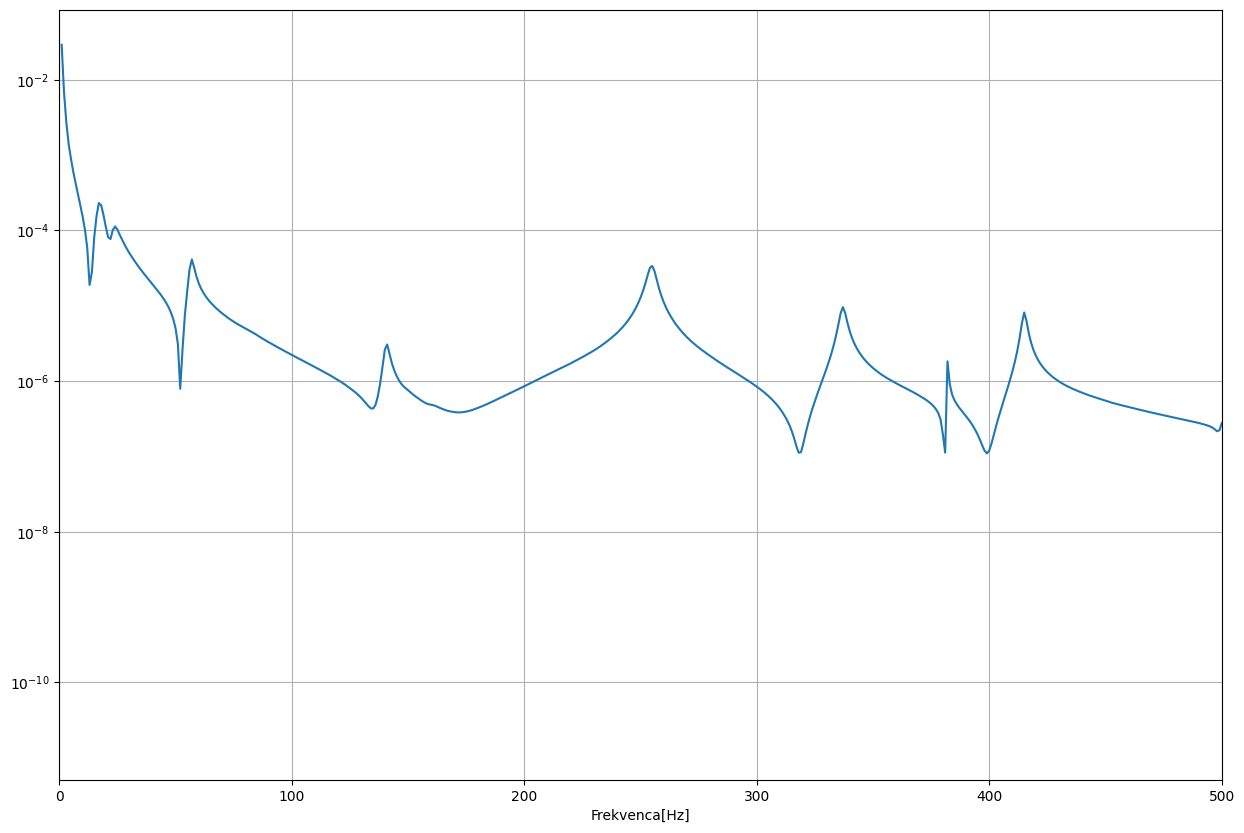

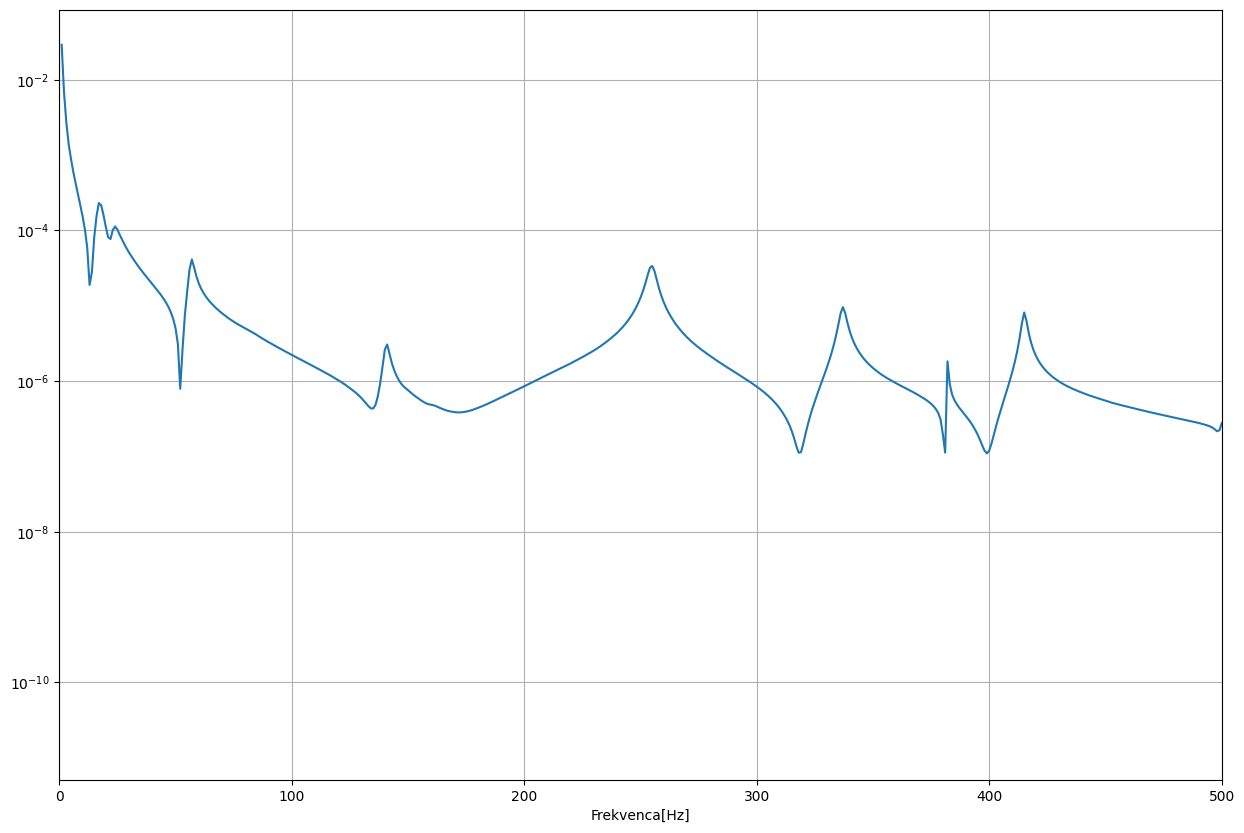

In [10]:
plt.figure(figsize=(15,10));
plt.semilogy(freq[1:],np.abs(H[7,1:])); #logaritmski plot 
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500)
plt.grid()

Prikažemo še graf faznega zamika s funkcijo np.angle.

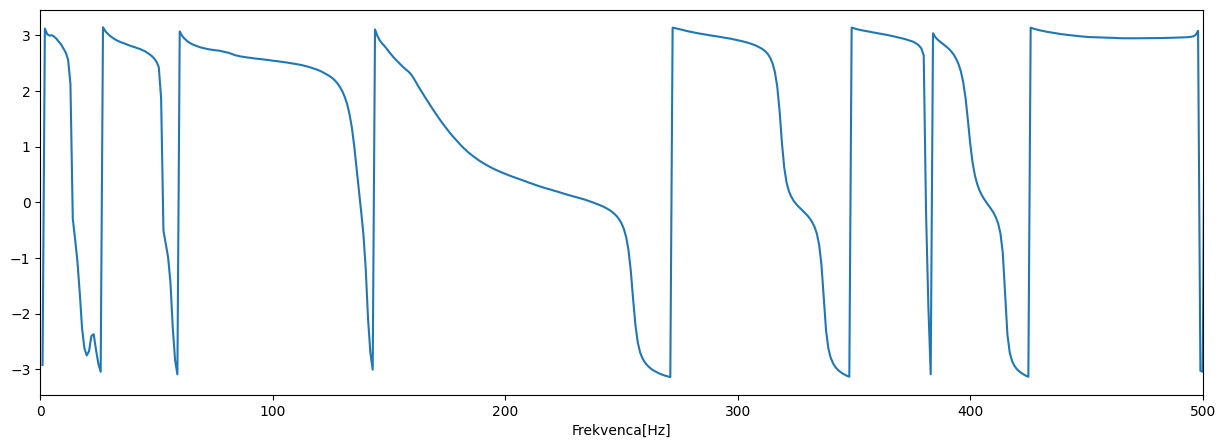

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(freq[1:],np.angle(H[7,1:]))
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500);

# Metode modalne identifikacije

## Metoda polovične moči

Prikažemo približan graf admitance in lokalnega maksimuma pri okoli 255 Hz. Za to najprej določimo časovni korak, ter predpišemo vrednost cenilke H kar v novo spremenljivko Y - admitanco (našo pomerjeno).

In [ ]:
fr_step= freq[1]-freq[0] #isto kot dt 
fr_range = np.array((240/fr_step, 270/fr_step), dtype=int)
Y_abs = np.abs(H[7,1:])

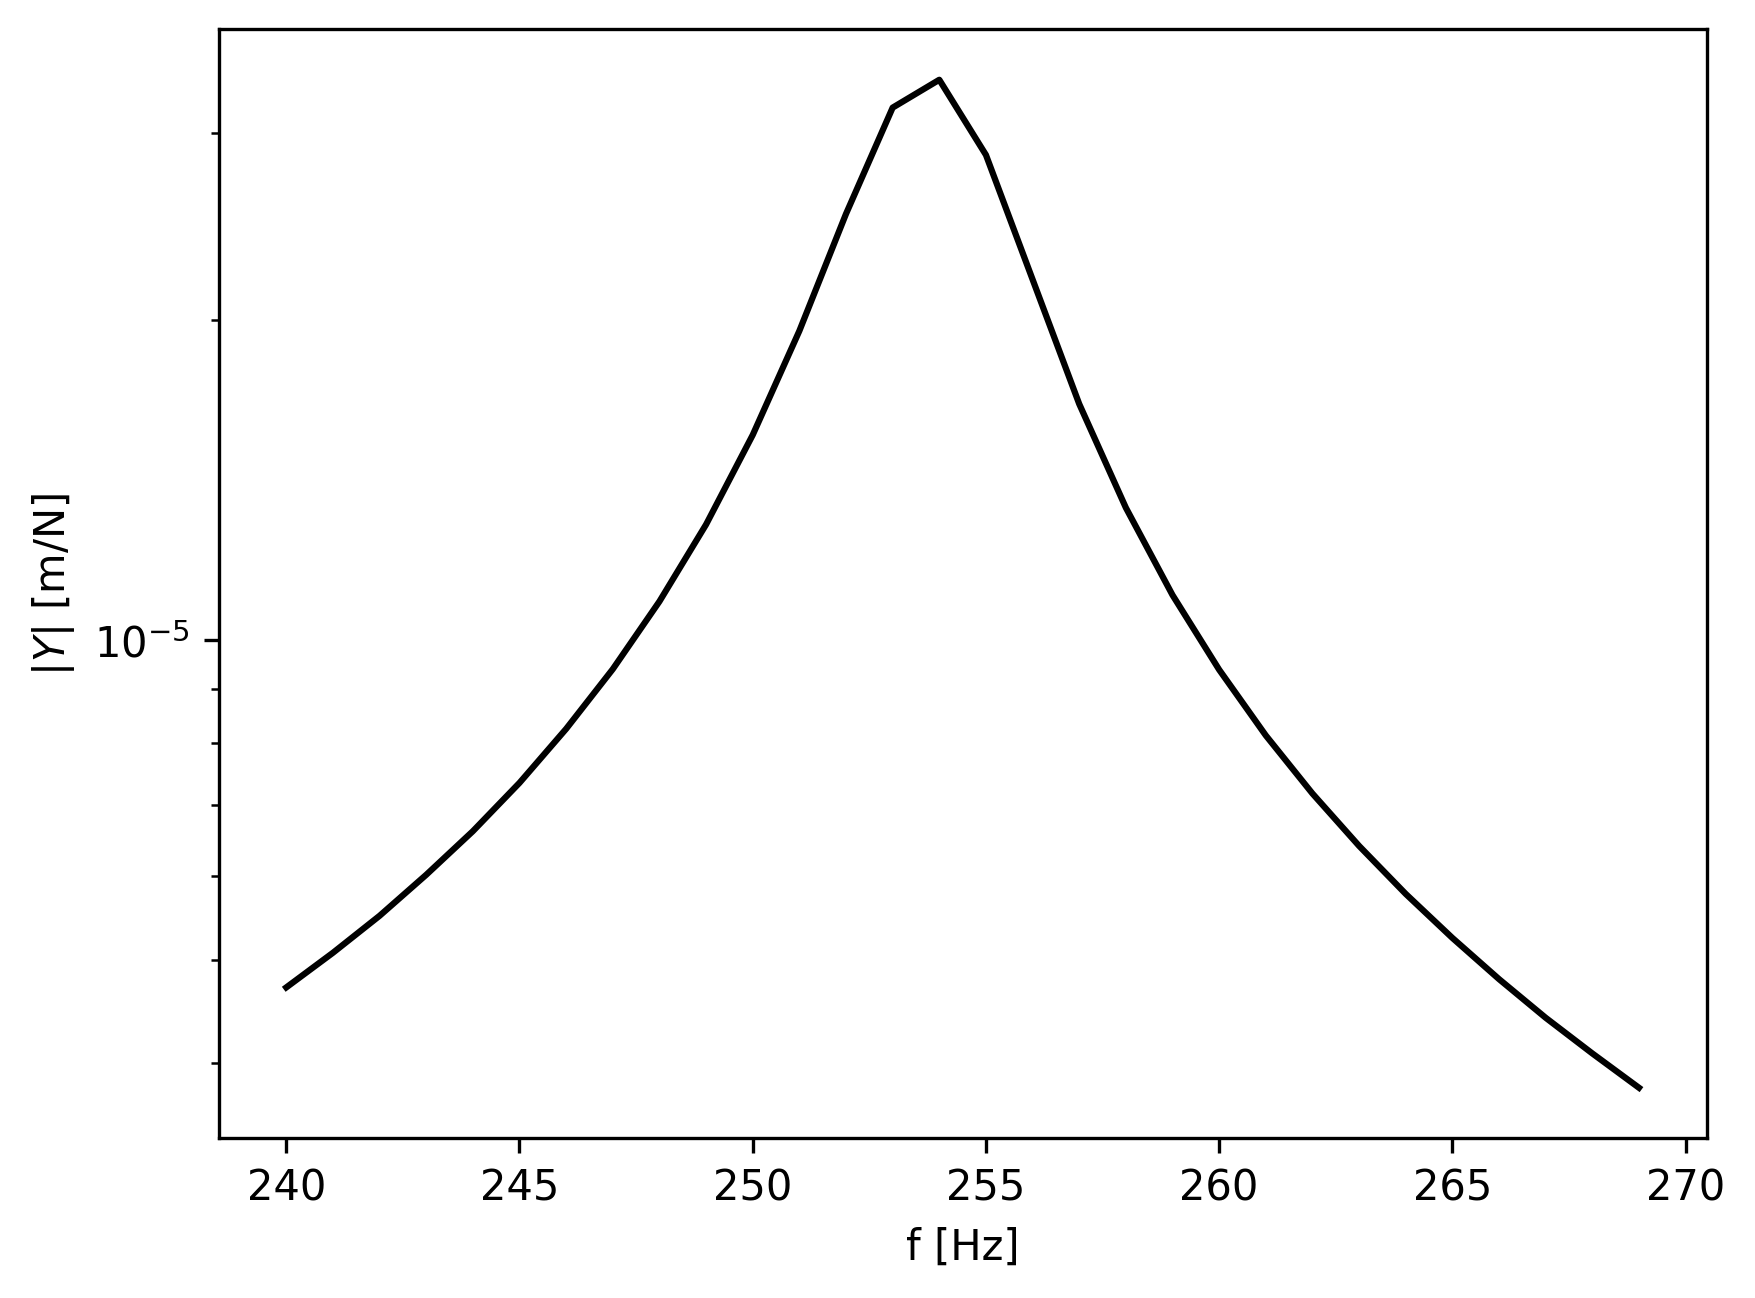

In [ ]:
plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)], Y_abs[slice(*fr_range)],color='k')
plt.ylabel(r'$|Y|$ [m/N]')
plt.xlabel('f [Hz]');

Nato določimo vrednost, kjer je magnituda lastne frekvence na izbranem intervalu maksimalna.

In [ ]:
ind = np.argmax(Y_abs[slice(*fr_range)])
f1 = freq[ind+fr_range[0]]
f1

254.0

Sedaj to vrednost prikažemo na grafu s pomočjo matplotlib fun axvline. Ta maksimum je nato prikazan z rdečo piko.

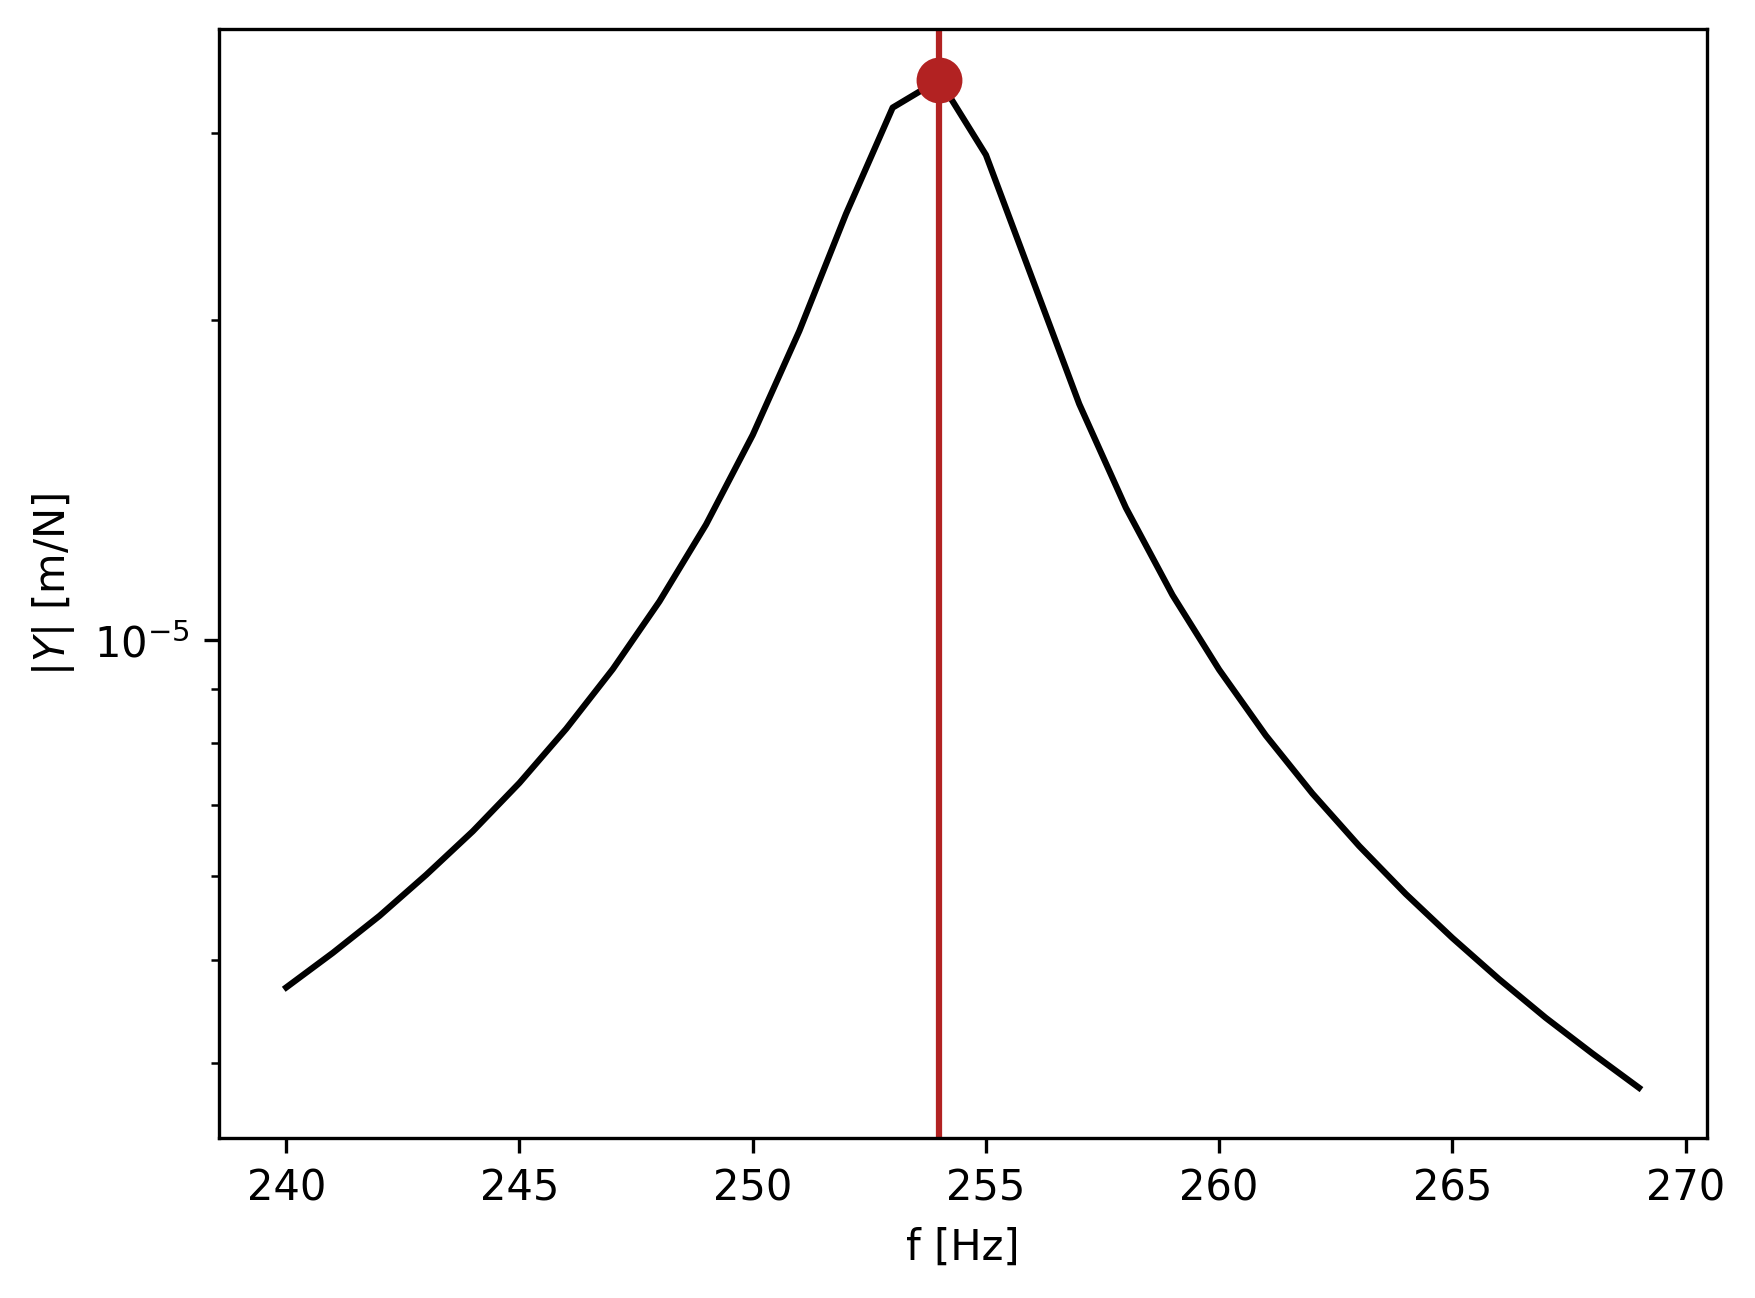

In [ ]:
plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)], Y_abs[slice(*fr_range)],color='k')
plt.semilogy(freq[ind+fr_range[0]], Y_abs[ind+fr_range[0]],'o', color='firebrick', ms=10)
plt.axvline(x=freq[ind+fr_range[0]], color='firebrick')
plt.ylabel(r'$|Y|$ [m/N]')
plt.xlabel('f [Hz]');

Po določitvi resonančnega vrha, sedaj določimo dve točki levo in desno, ki imata vrednost enako 1/√2max(Y).

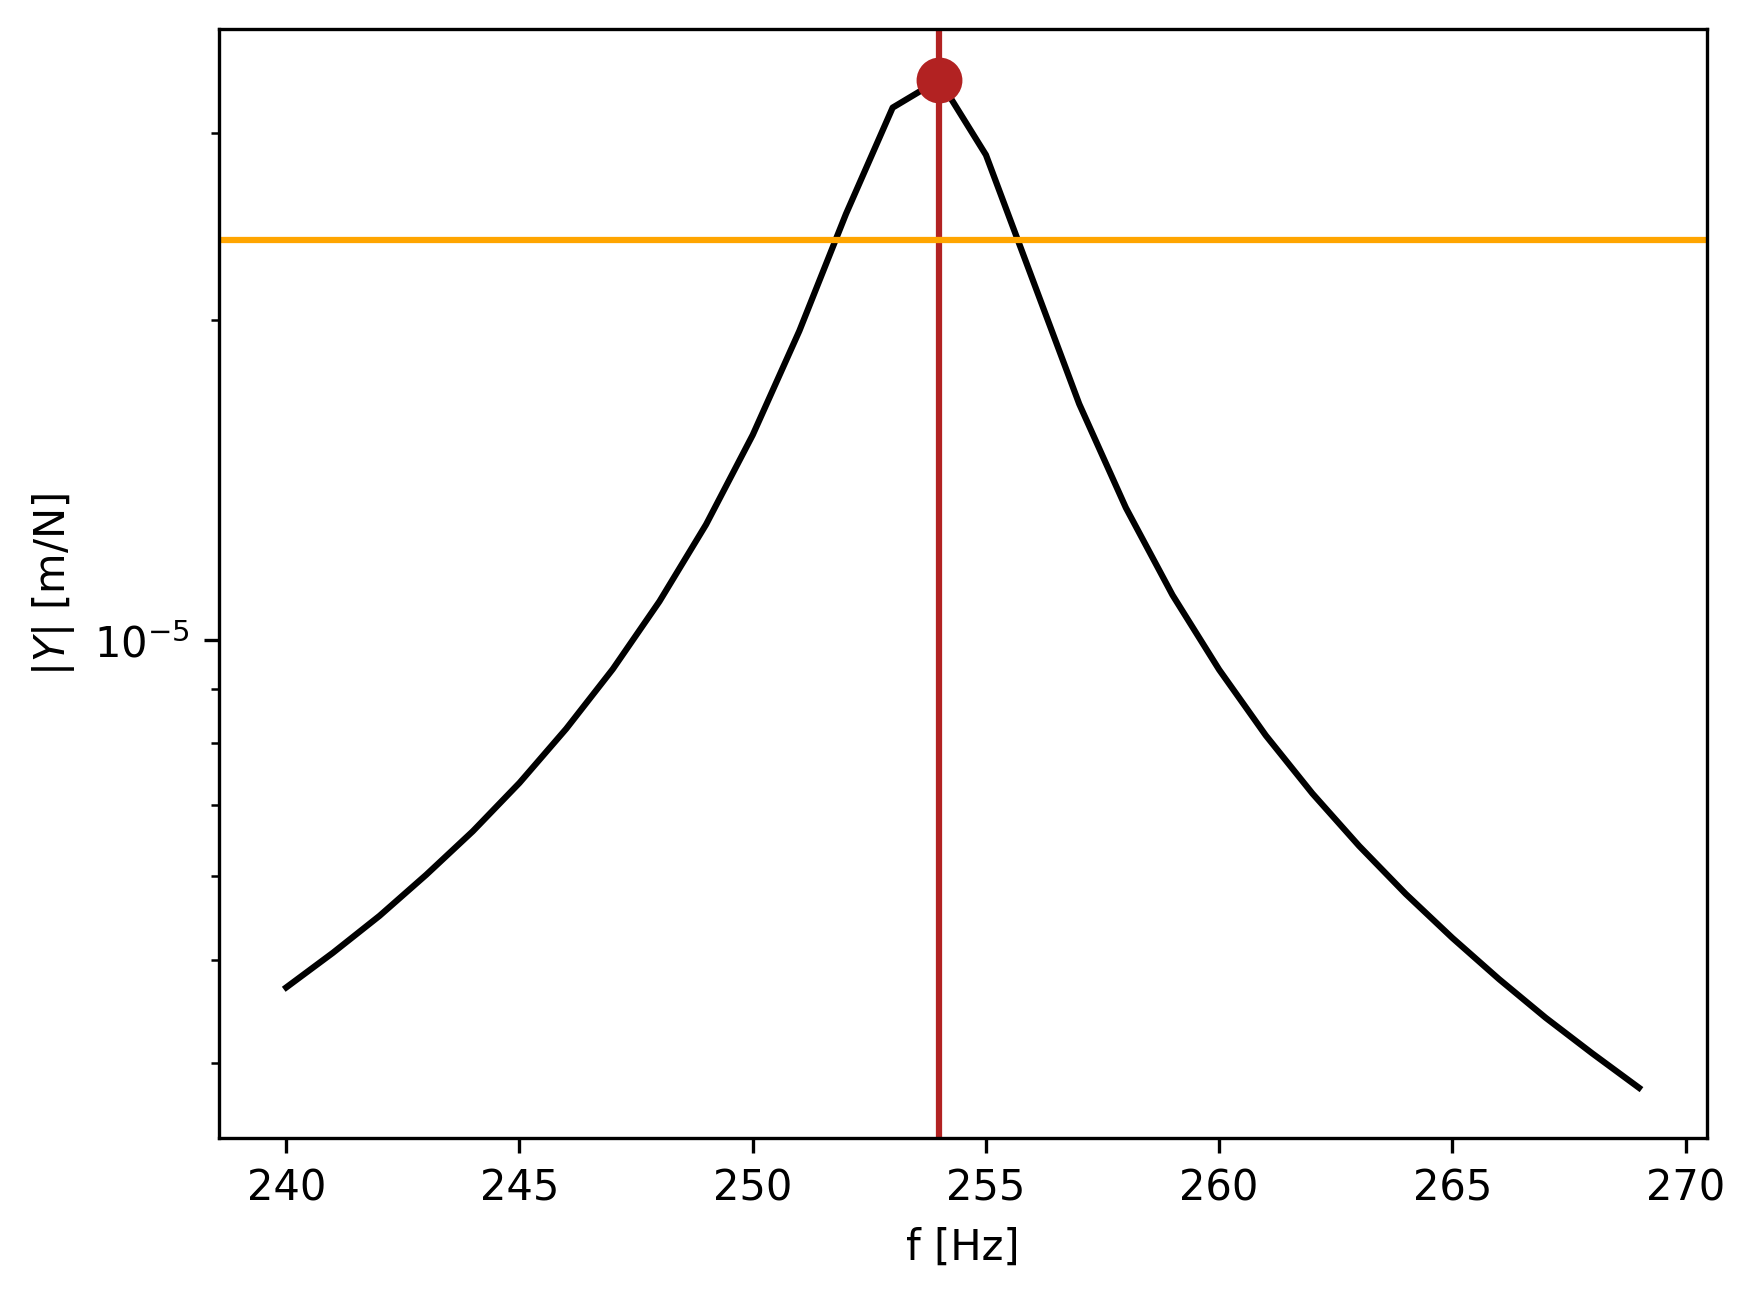

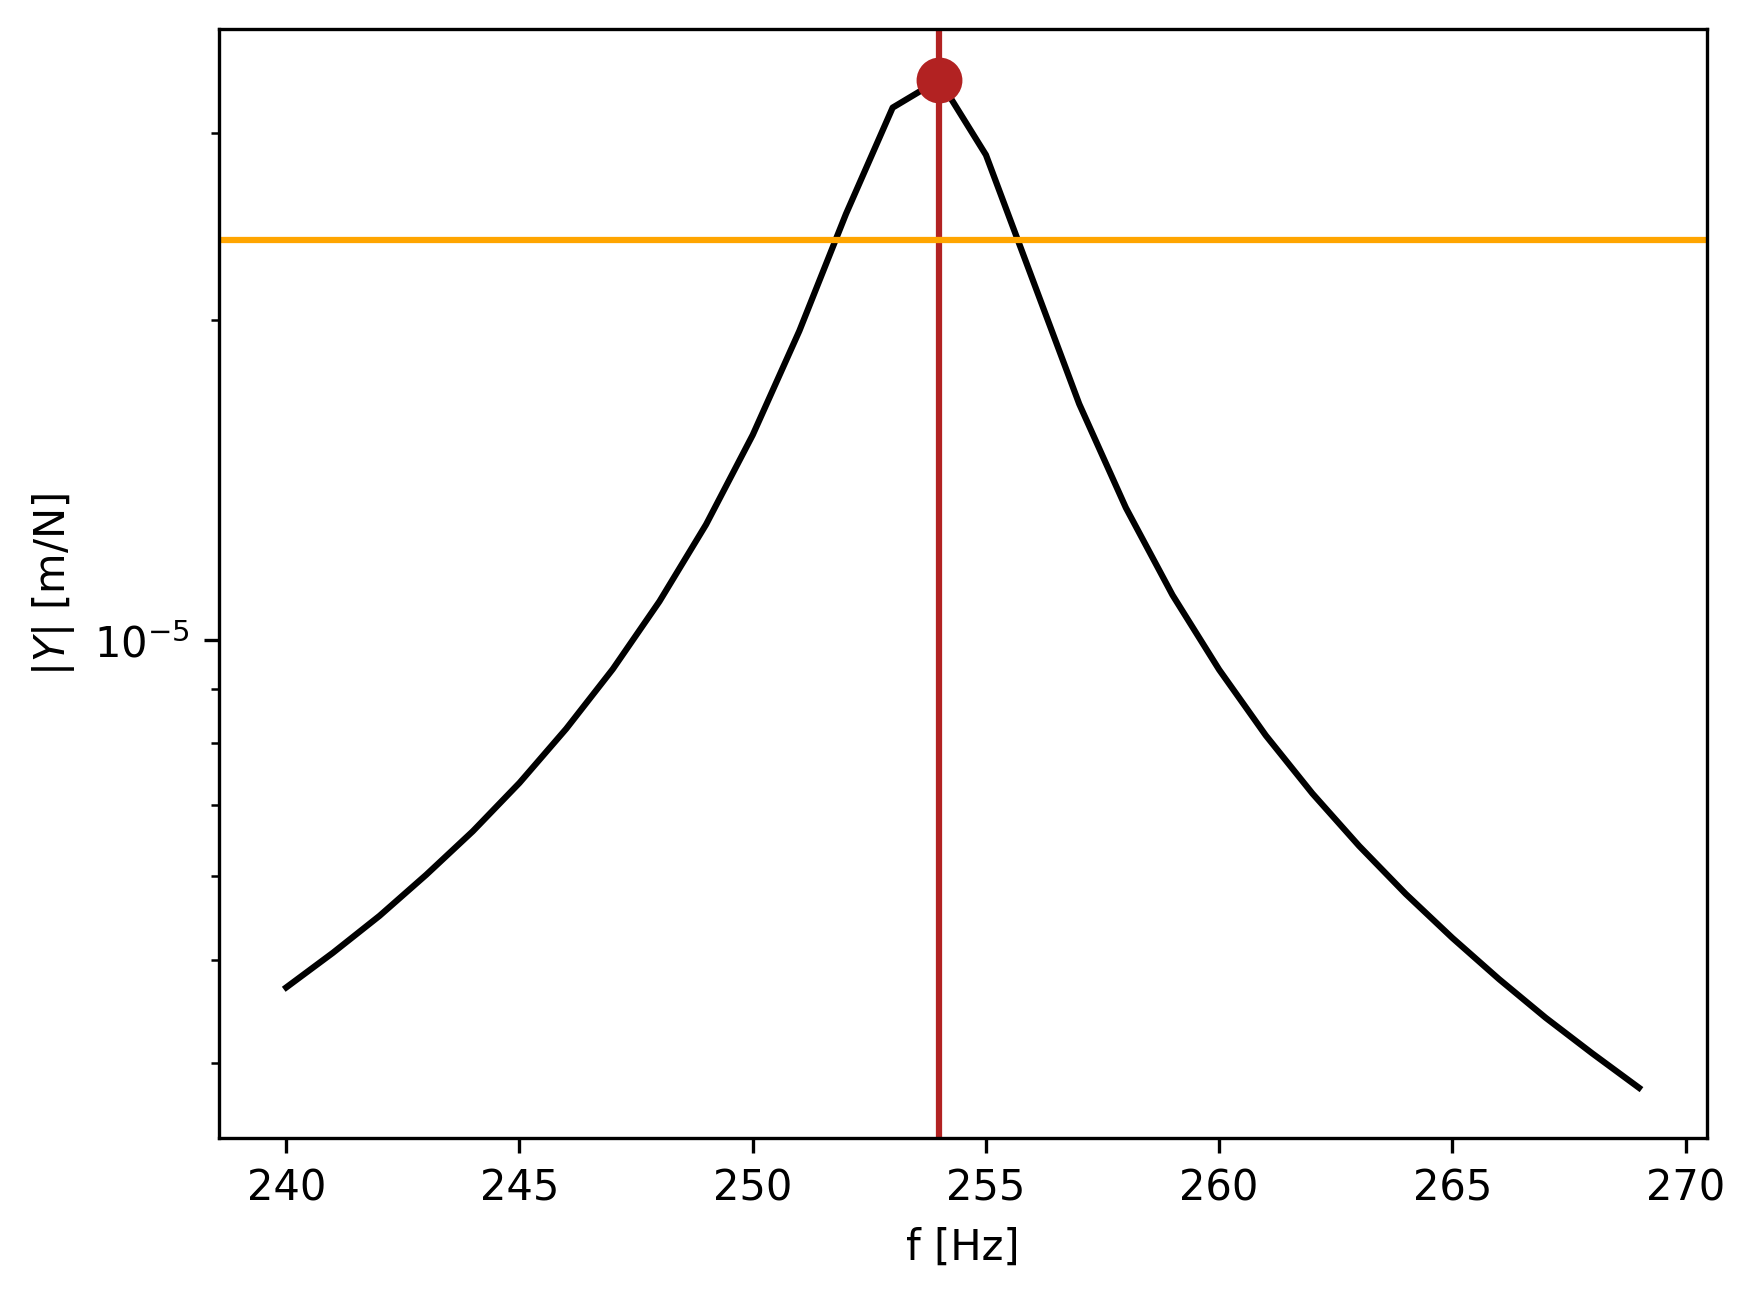

In [16]:
half_power_point = Y_abs[ind+fr_range[0]]/np.sqrt(2) #tu poiščemo ti dve točki s vrednostjo 1/√

plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)], Y_abs[slice(*fr_range)],color='k')
plt.semilogy(freq[ind+fr_range[0]], Y_abs[ind+fr_range[0]],'o', color='firebrick', ms=10)
plt.axvline(x=freq[ind+fr_range[0]], color='firebrick')
plt.axhline(y=half_power_point, color='orange')
plt.ylabel(r'$|Y|$ [m/N]')
plt.xlabel('f [Hz]');

Poiščem vrednost najbližje točke polovični moči levo od resonančnega vrha

In [20]:
ind_half_1 = np.argmin(np.abs(Y_abs[fr_range[0]:fr_range[0]+ind]- half_power_point))

Poiščem vrednost najbližje točke polovični moči desno od resonančnega vrha

In [21]:
ind_half_2 = np.argmin(np.abs(Y_abs[fr_range[0]+ind:fr_range[1]]-half_power_point))

Sedaj lahko to prikažemo skupaj na grafu.

Opomba. Določene točke so malo oddaljene od krivulje admitance, ampak je isto na predlogi pdf. To lahko predpišemo preslabi frekvenčni ločljivosti.

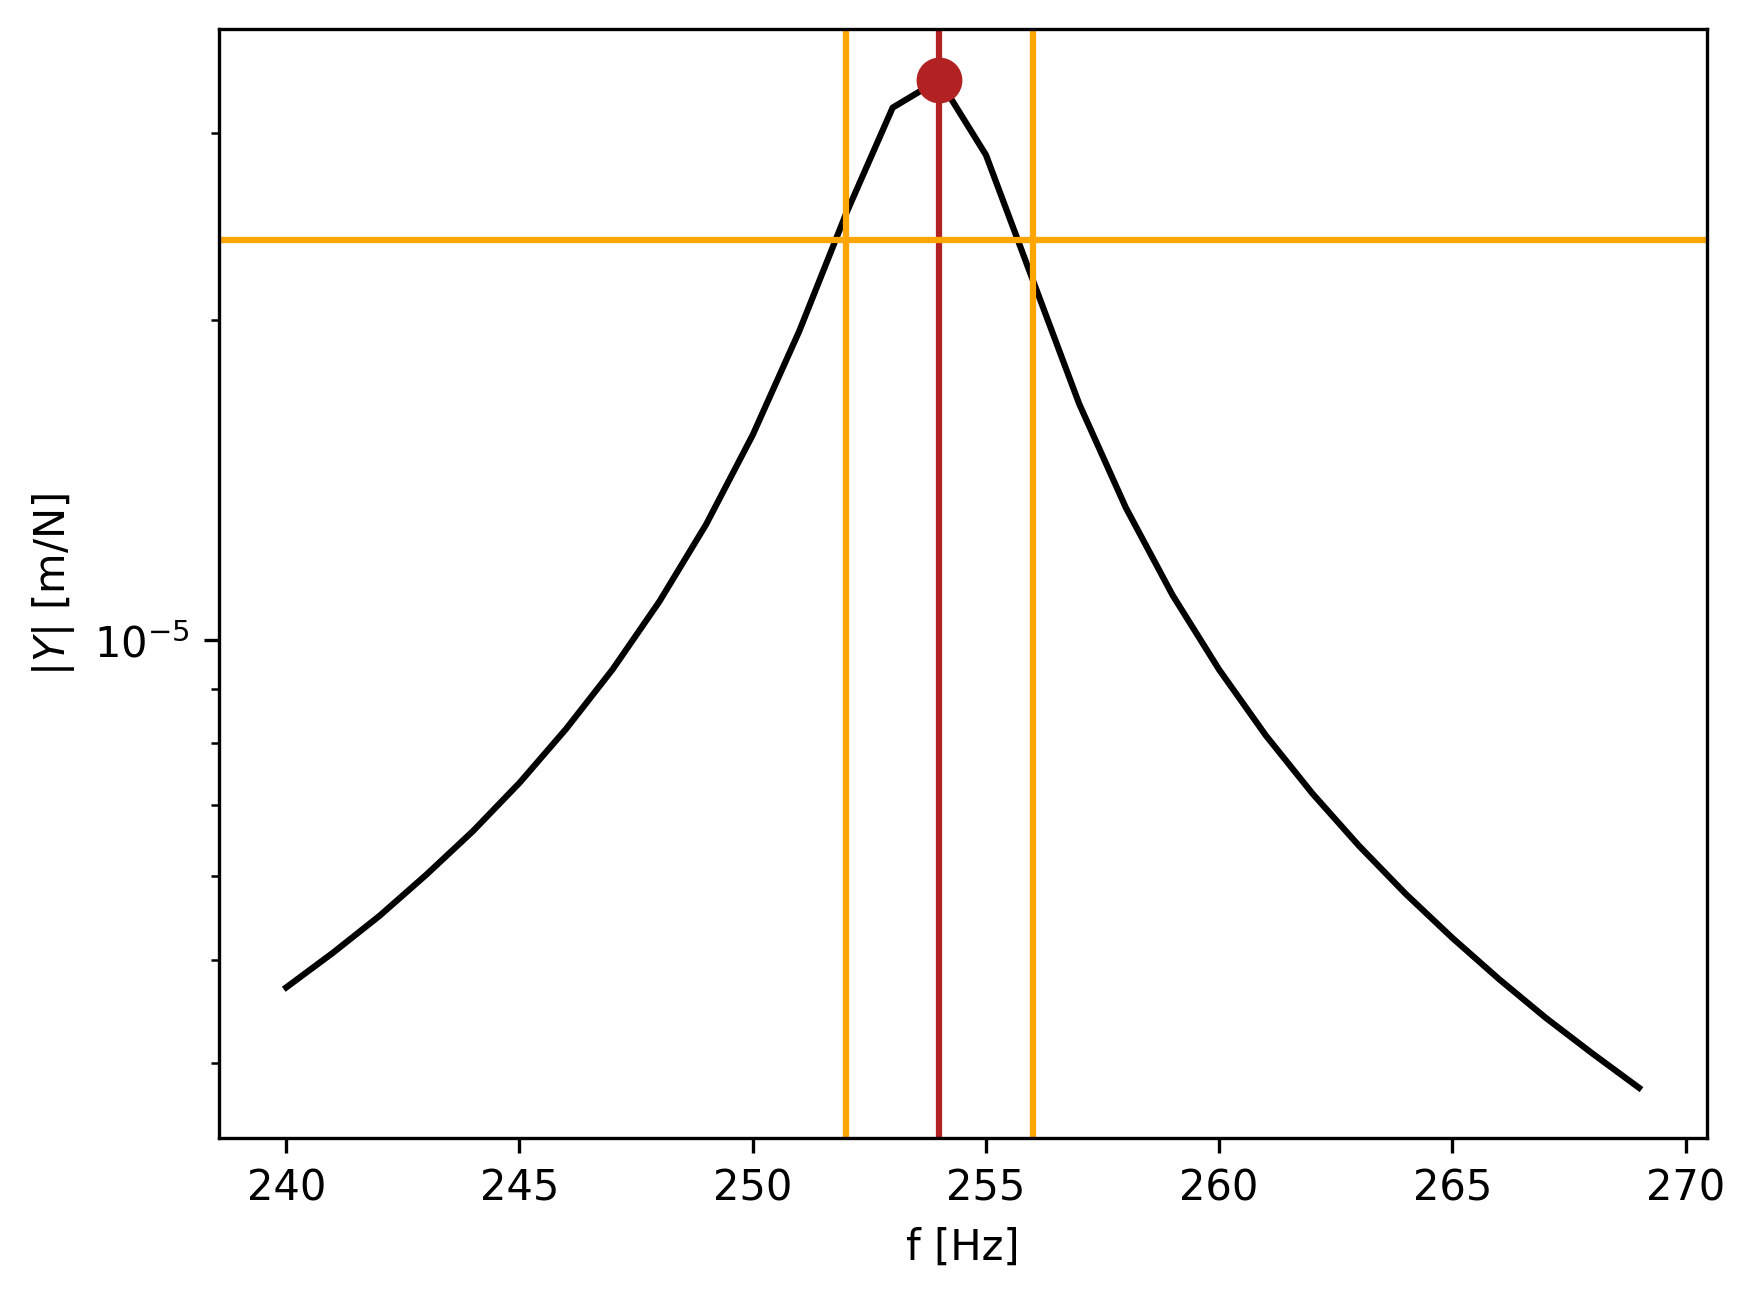

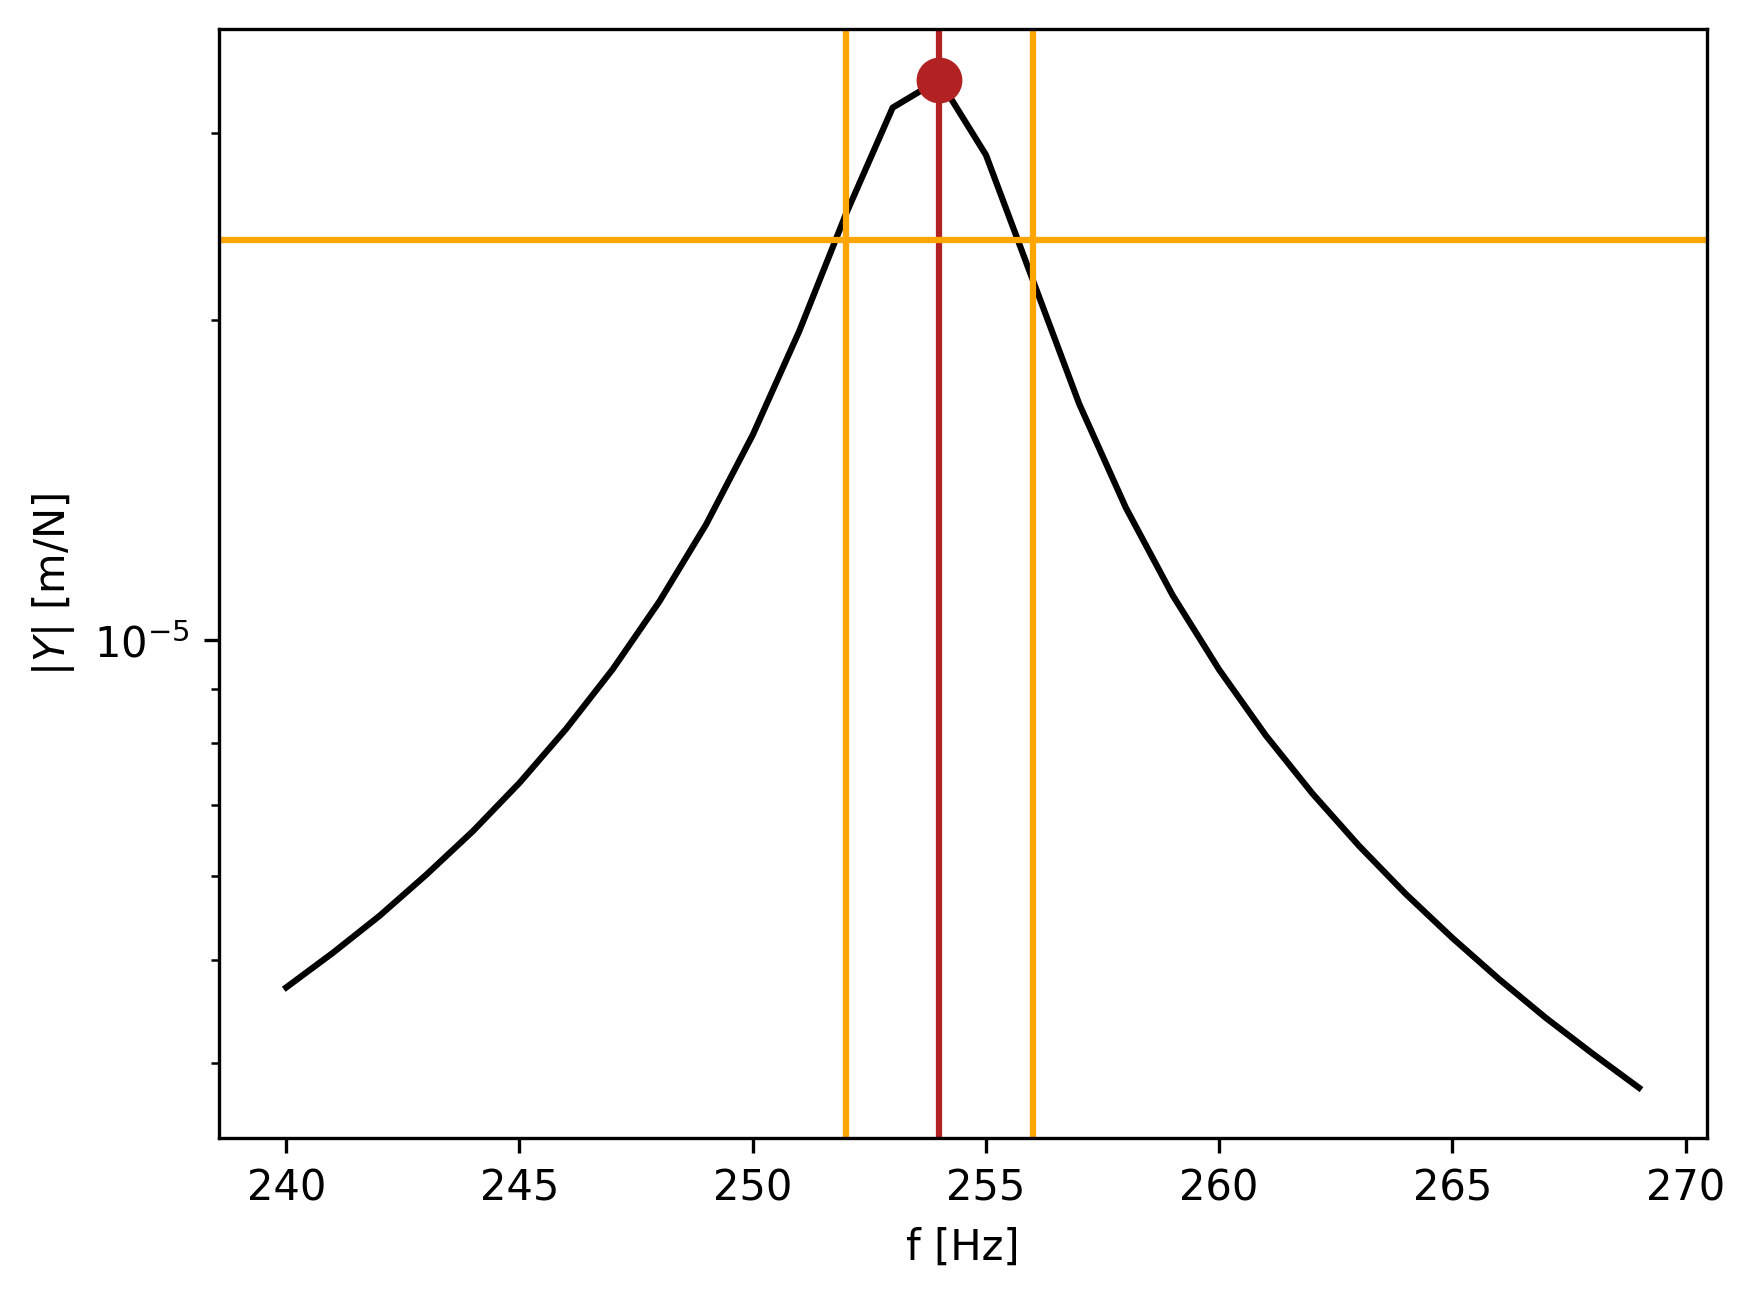

In [22]:
plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)], Y_abs[slice(*fr_range)],color='k')
plt.semilogy(freq[ind+fr_range[0]], Y_abs[ind+fr_range[0]],'o', color='firebrick', ms=10)
plt.axvline(x=freq[ind+fr_range[0]], color='firebrick')
plt.axhline(y=half_power_point, color='orange')
plt.axvline(x=freq[ind_half_1+fr_range[0]], color='orange')
plt.axvline(x=freq[ind_half_2+ind+fr_range[0]], color='orange')
plt.ylabel(r'$|Y|$ [m/N]')
plt.xlabel('f [Hz]');

Sedaj lahko iz določenih točk metode polovične moči izračunamo razmernik histereznega dušenja.

In [23]:
damp1 = (freq[fr_range[0]+ind+ind_half_2]-freq[ind_half_1+fr_range[0]])/freq[ind+fr_range[0]]
damp1

0.015748031496062992

0.015748031496062992

Po določitvi razmernika dušenja lahko sedaj s poznano enačbo modalne konstante izračunamo le to.

In [24]:
A1 = 1j*Y_abs[ind+fr_range[0]]*damp1*(2*np.pi*f1)**2
A1

1.3490429301834044j

1.3490429301834044j

Celoten postopek zdaj ponovimo za vse izmerjene frekvenˇcne prenosne funkcije, pri
ˇcemer lahko uporabimo zgolj eno vrstico ali en stolpec admitanˇcne matrike (omejitev
metode poloviˇcne moˇci kot metode v skupini “single-input single-output”):

# DODAJ OD DRUGIH DO KONCA.

Pol pa izračuni modalno obliko + modalno superpozicijo? pol pa nevem ask her or somebody :)

## Metoda prilagajanja kroga - vaja 6

In [25]:
Y2 = H[7,1:] #za razliko od prej pustimo imaginarni del, da vidimo fazni zamik

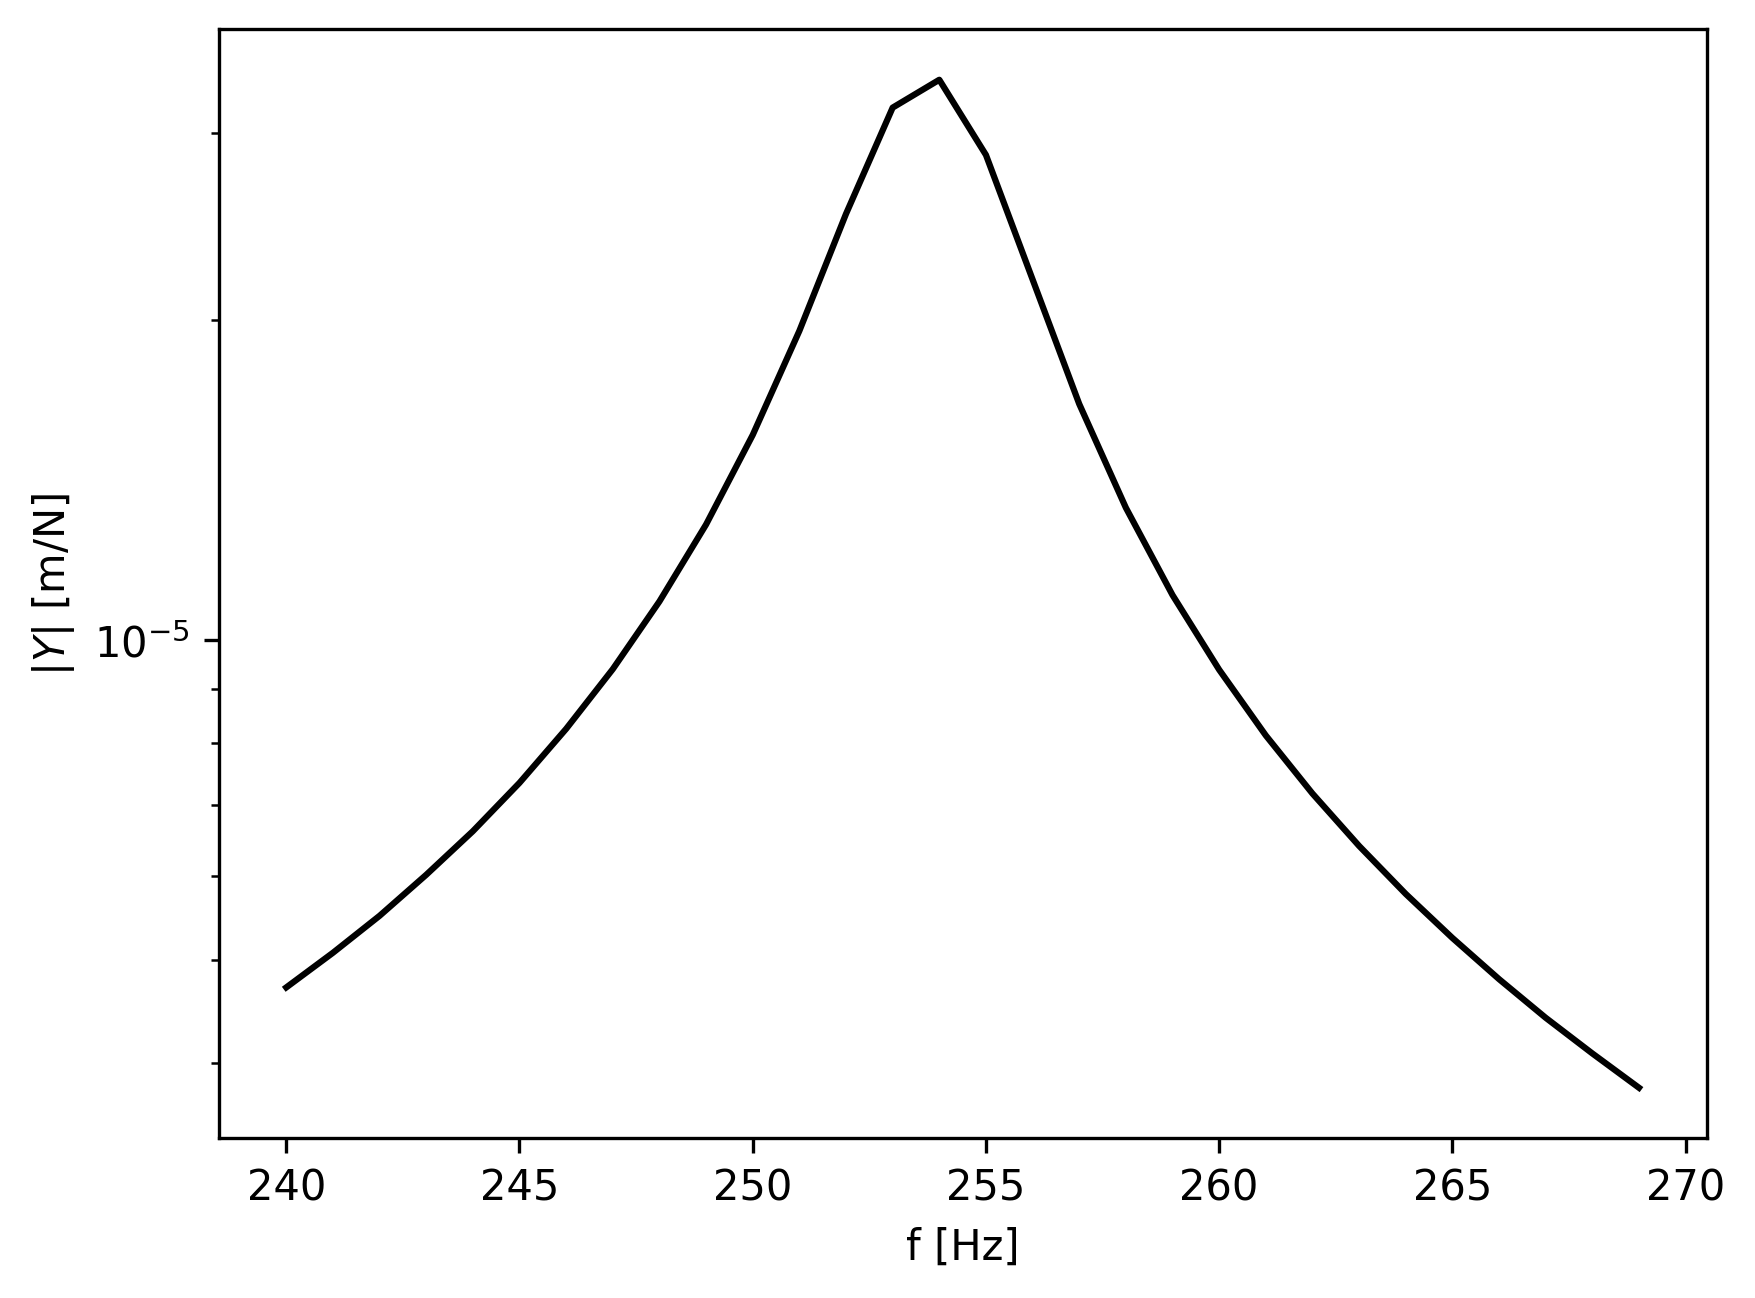

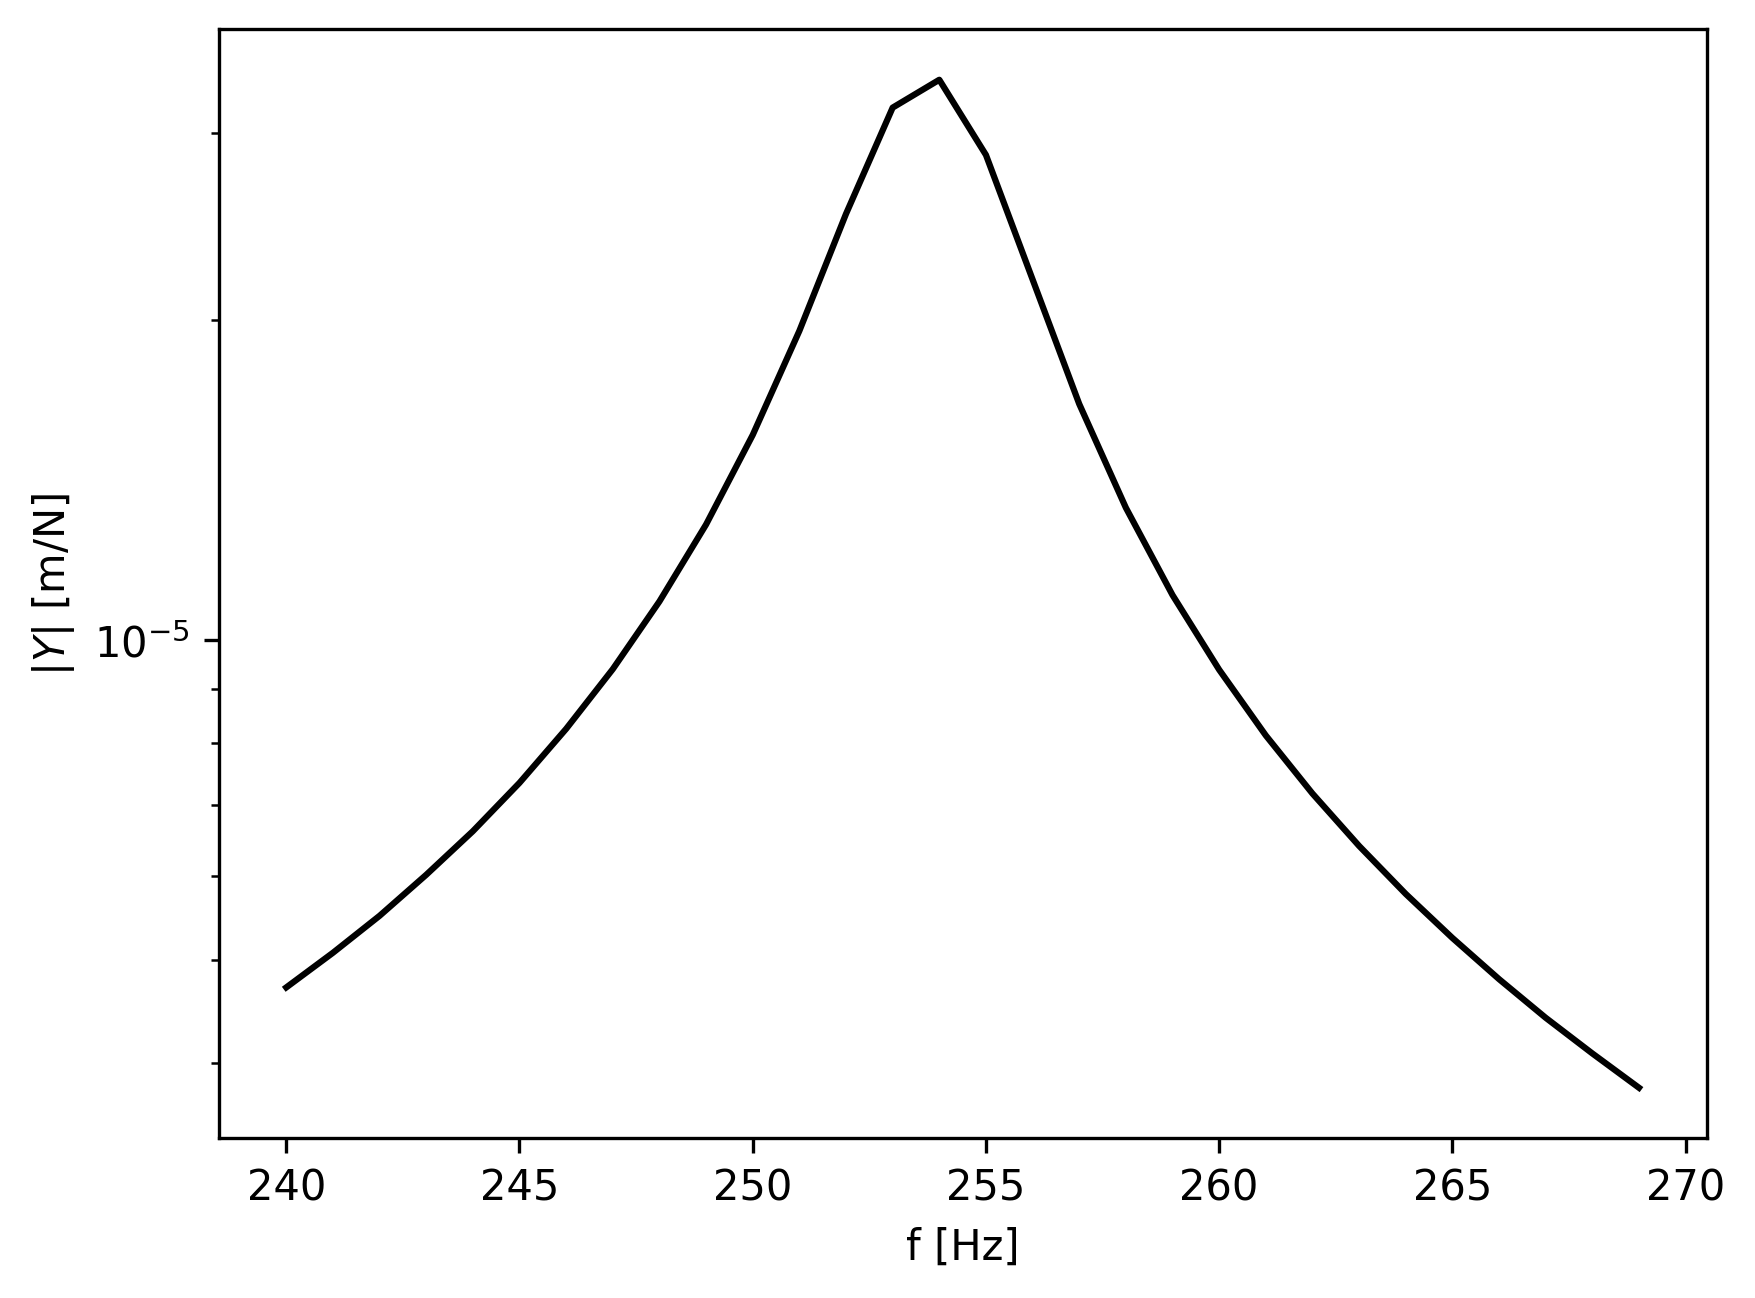

In [26]:
plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)], np.abs(Y2[slice(*fr_range)]),color='k')
plt.ylabel(r'$|Y|$ [m/N]')
plt.xlabel('f [Hz]');

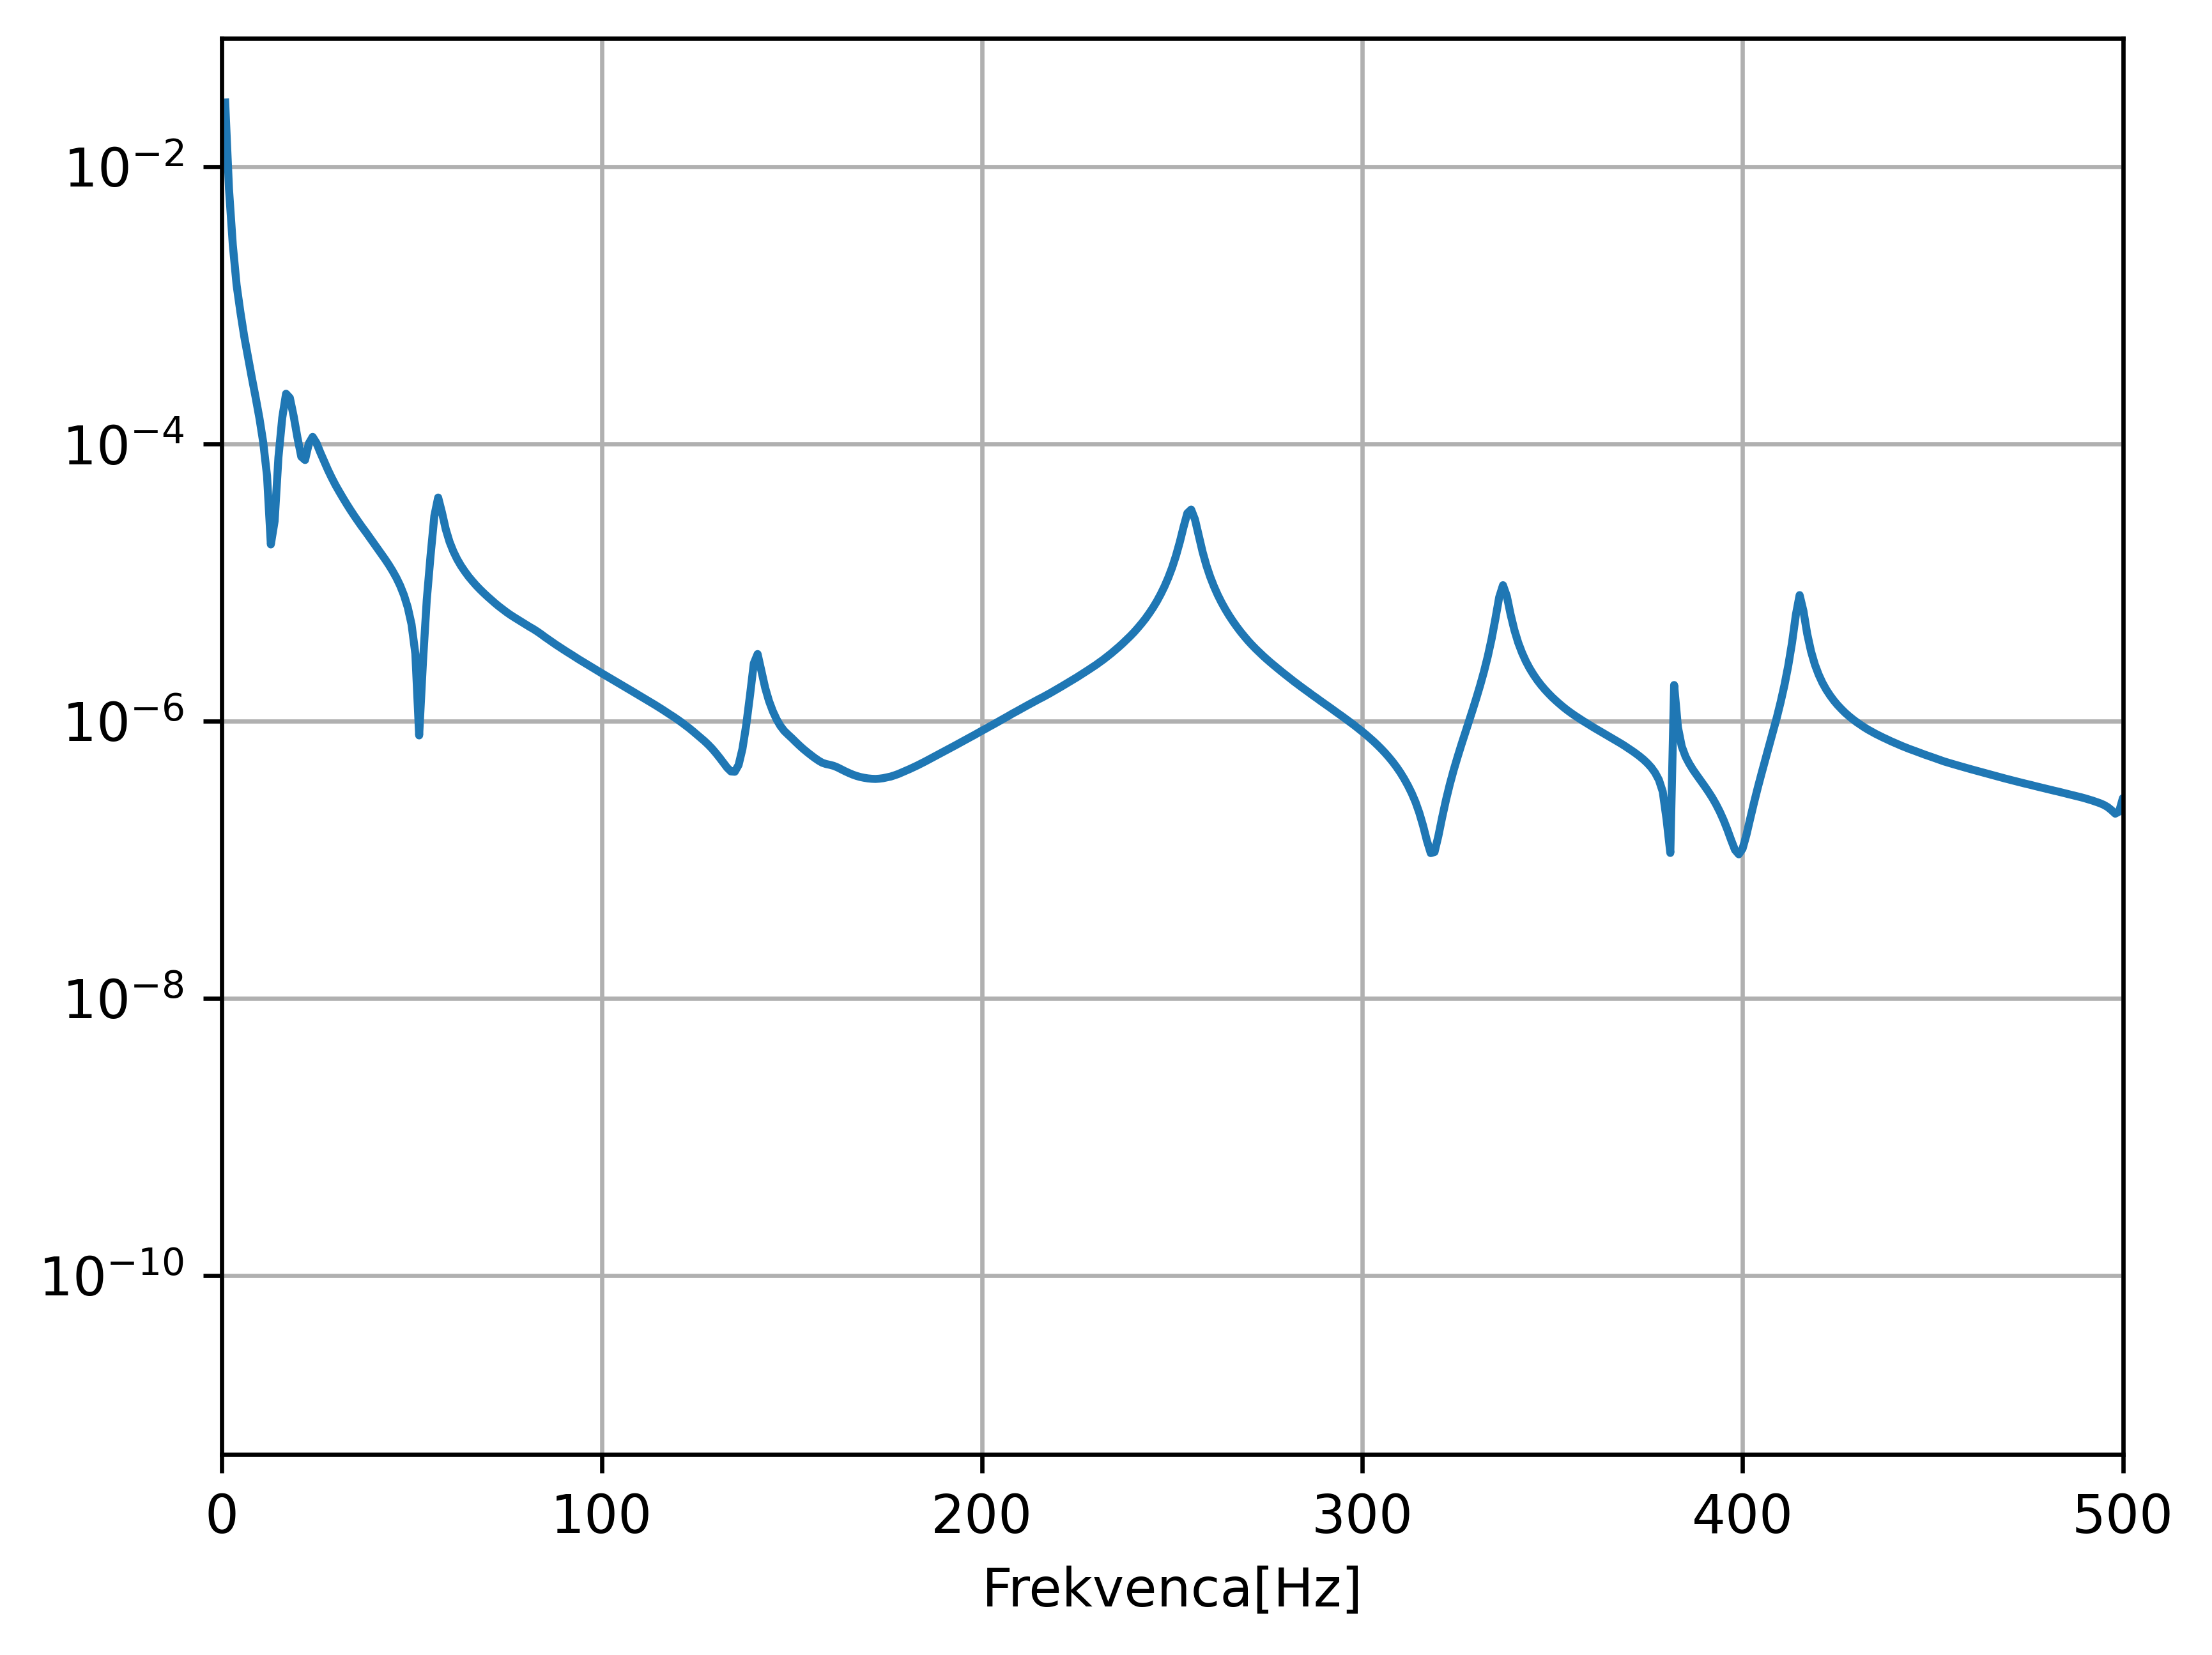

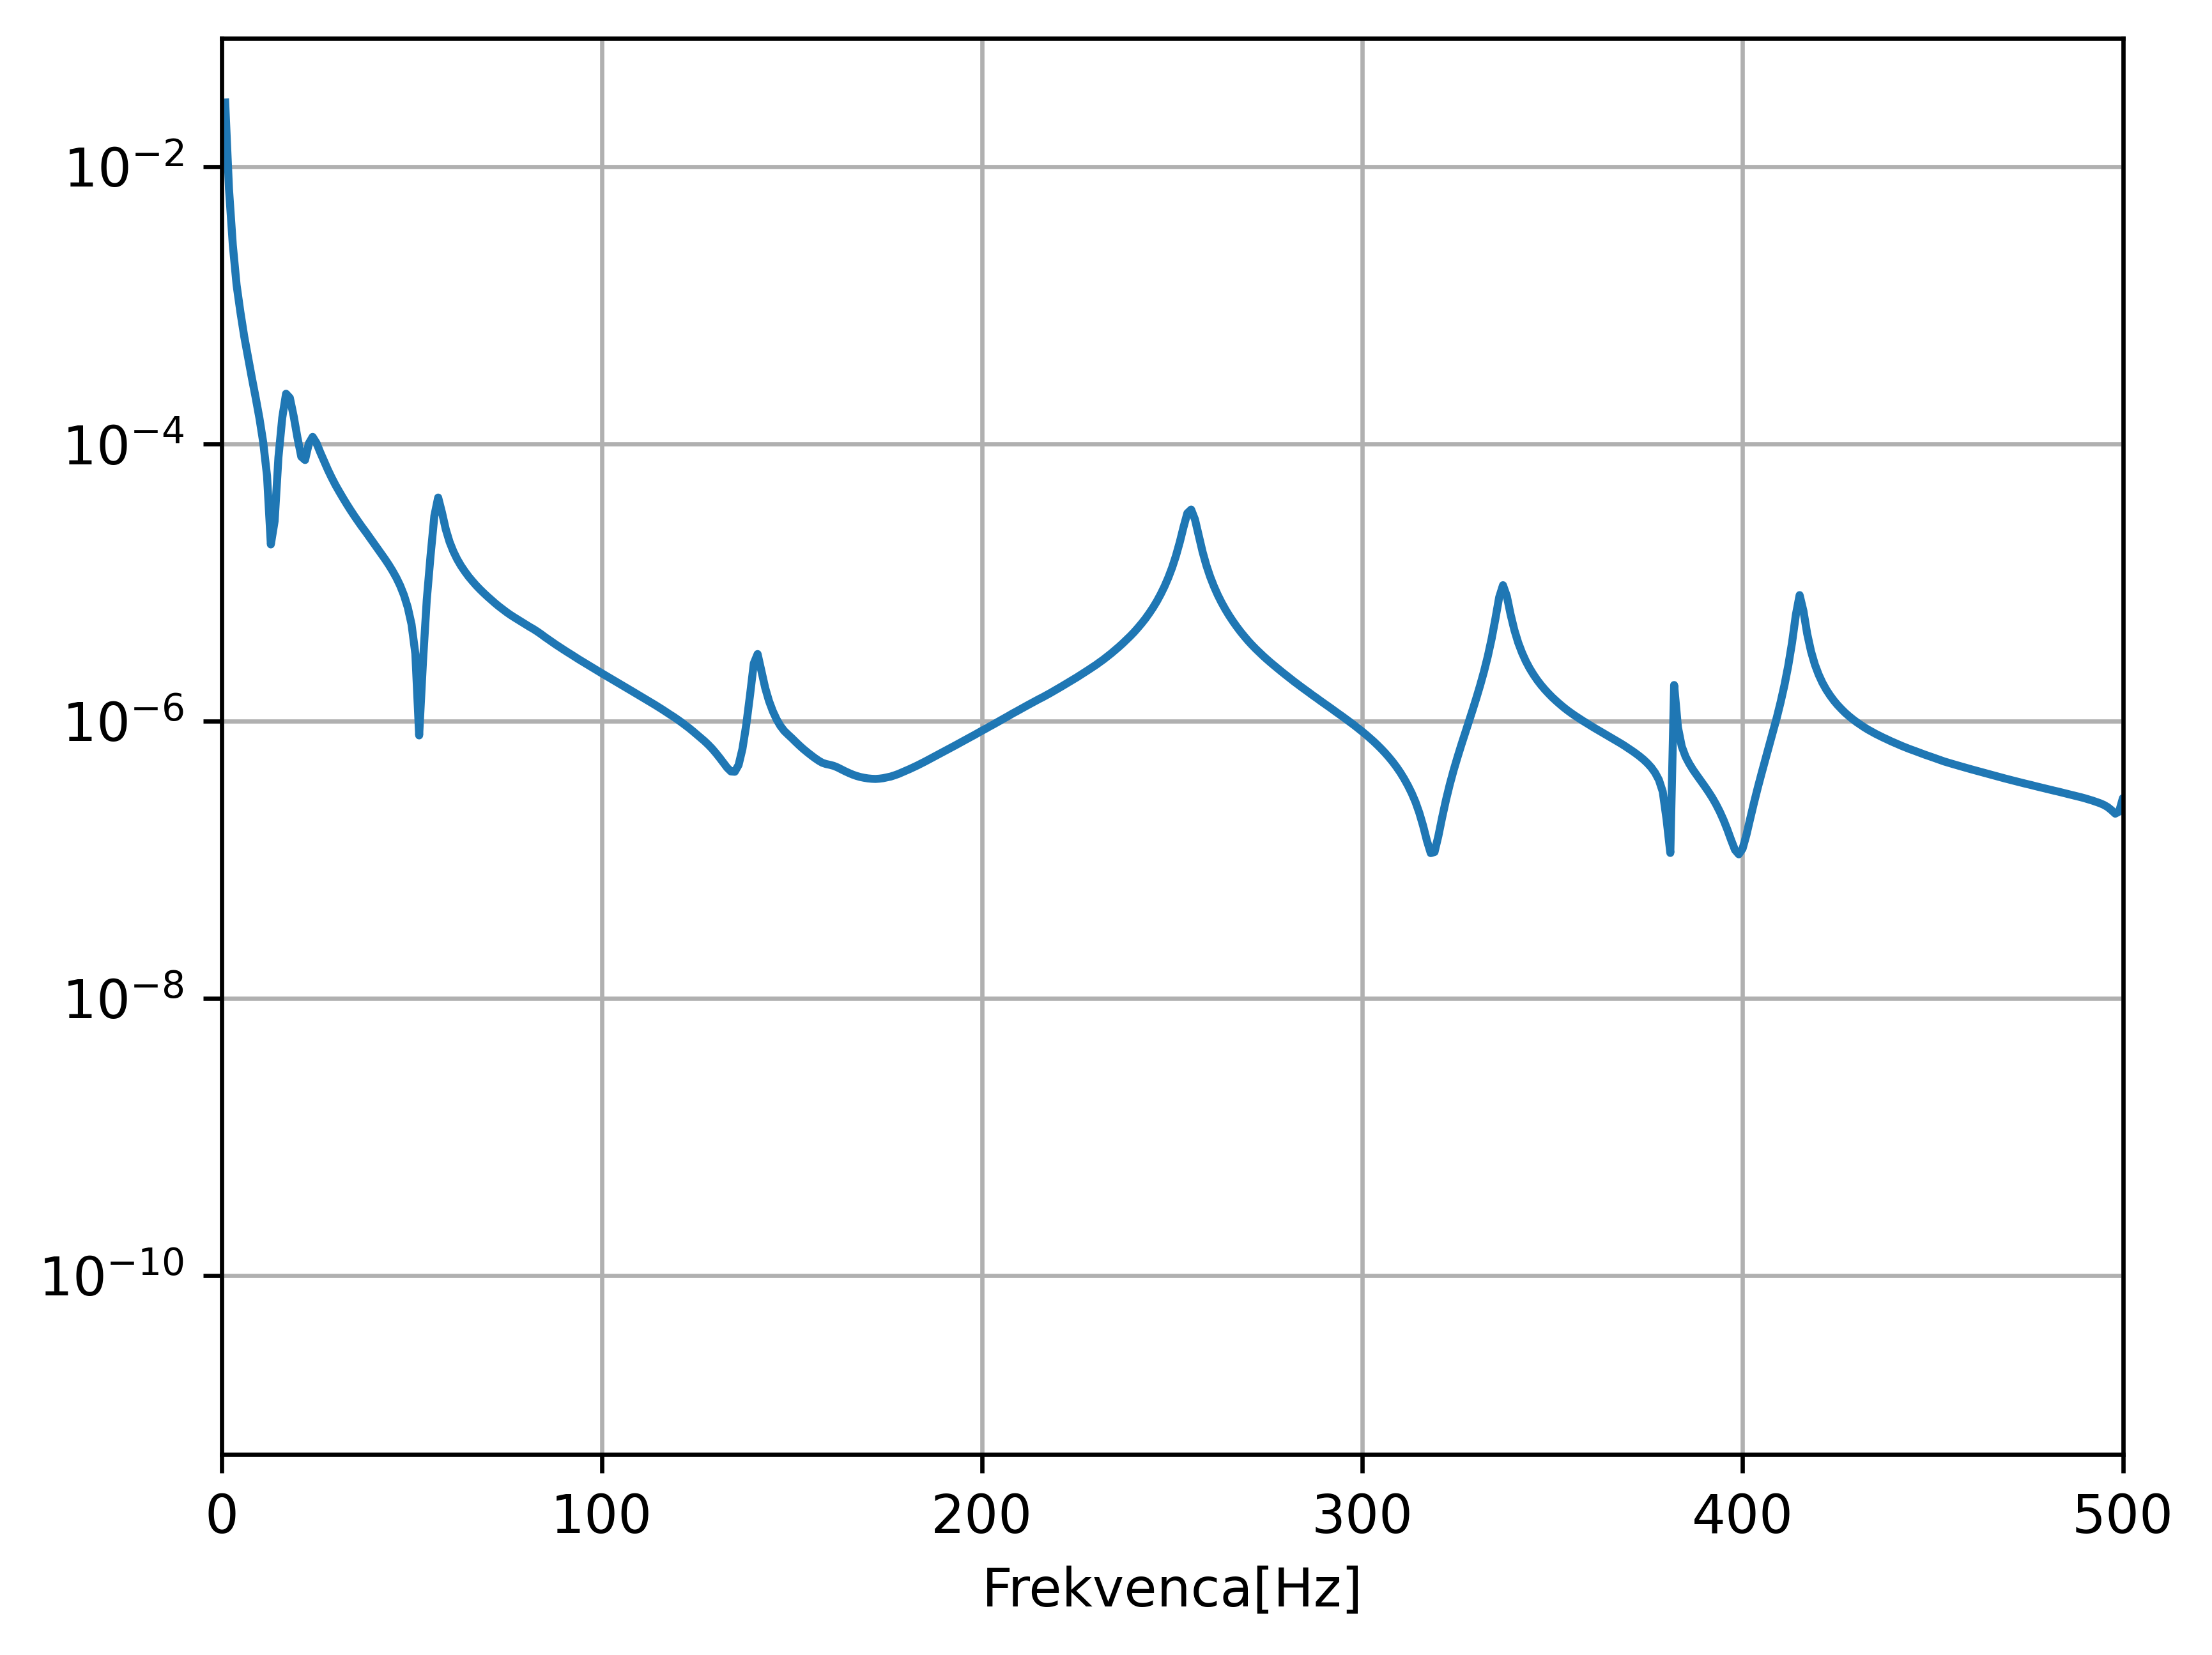

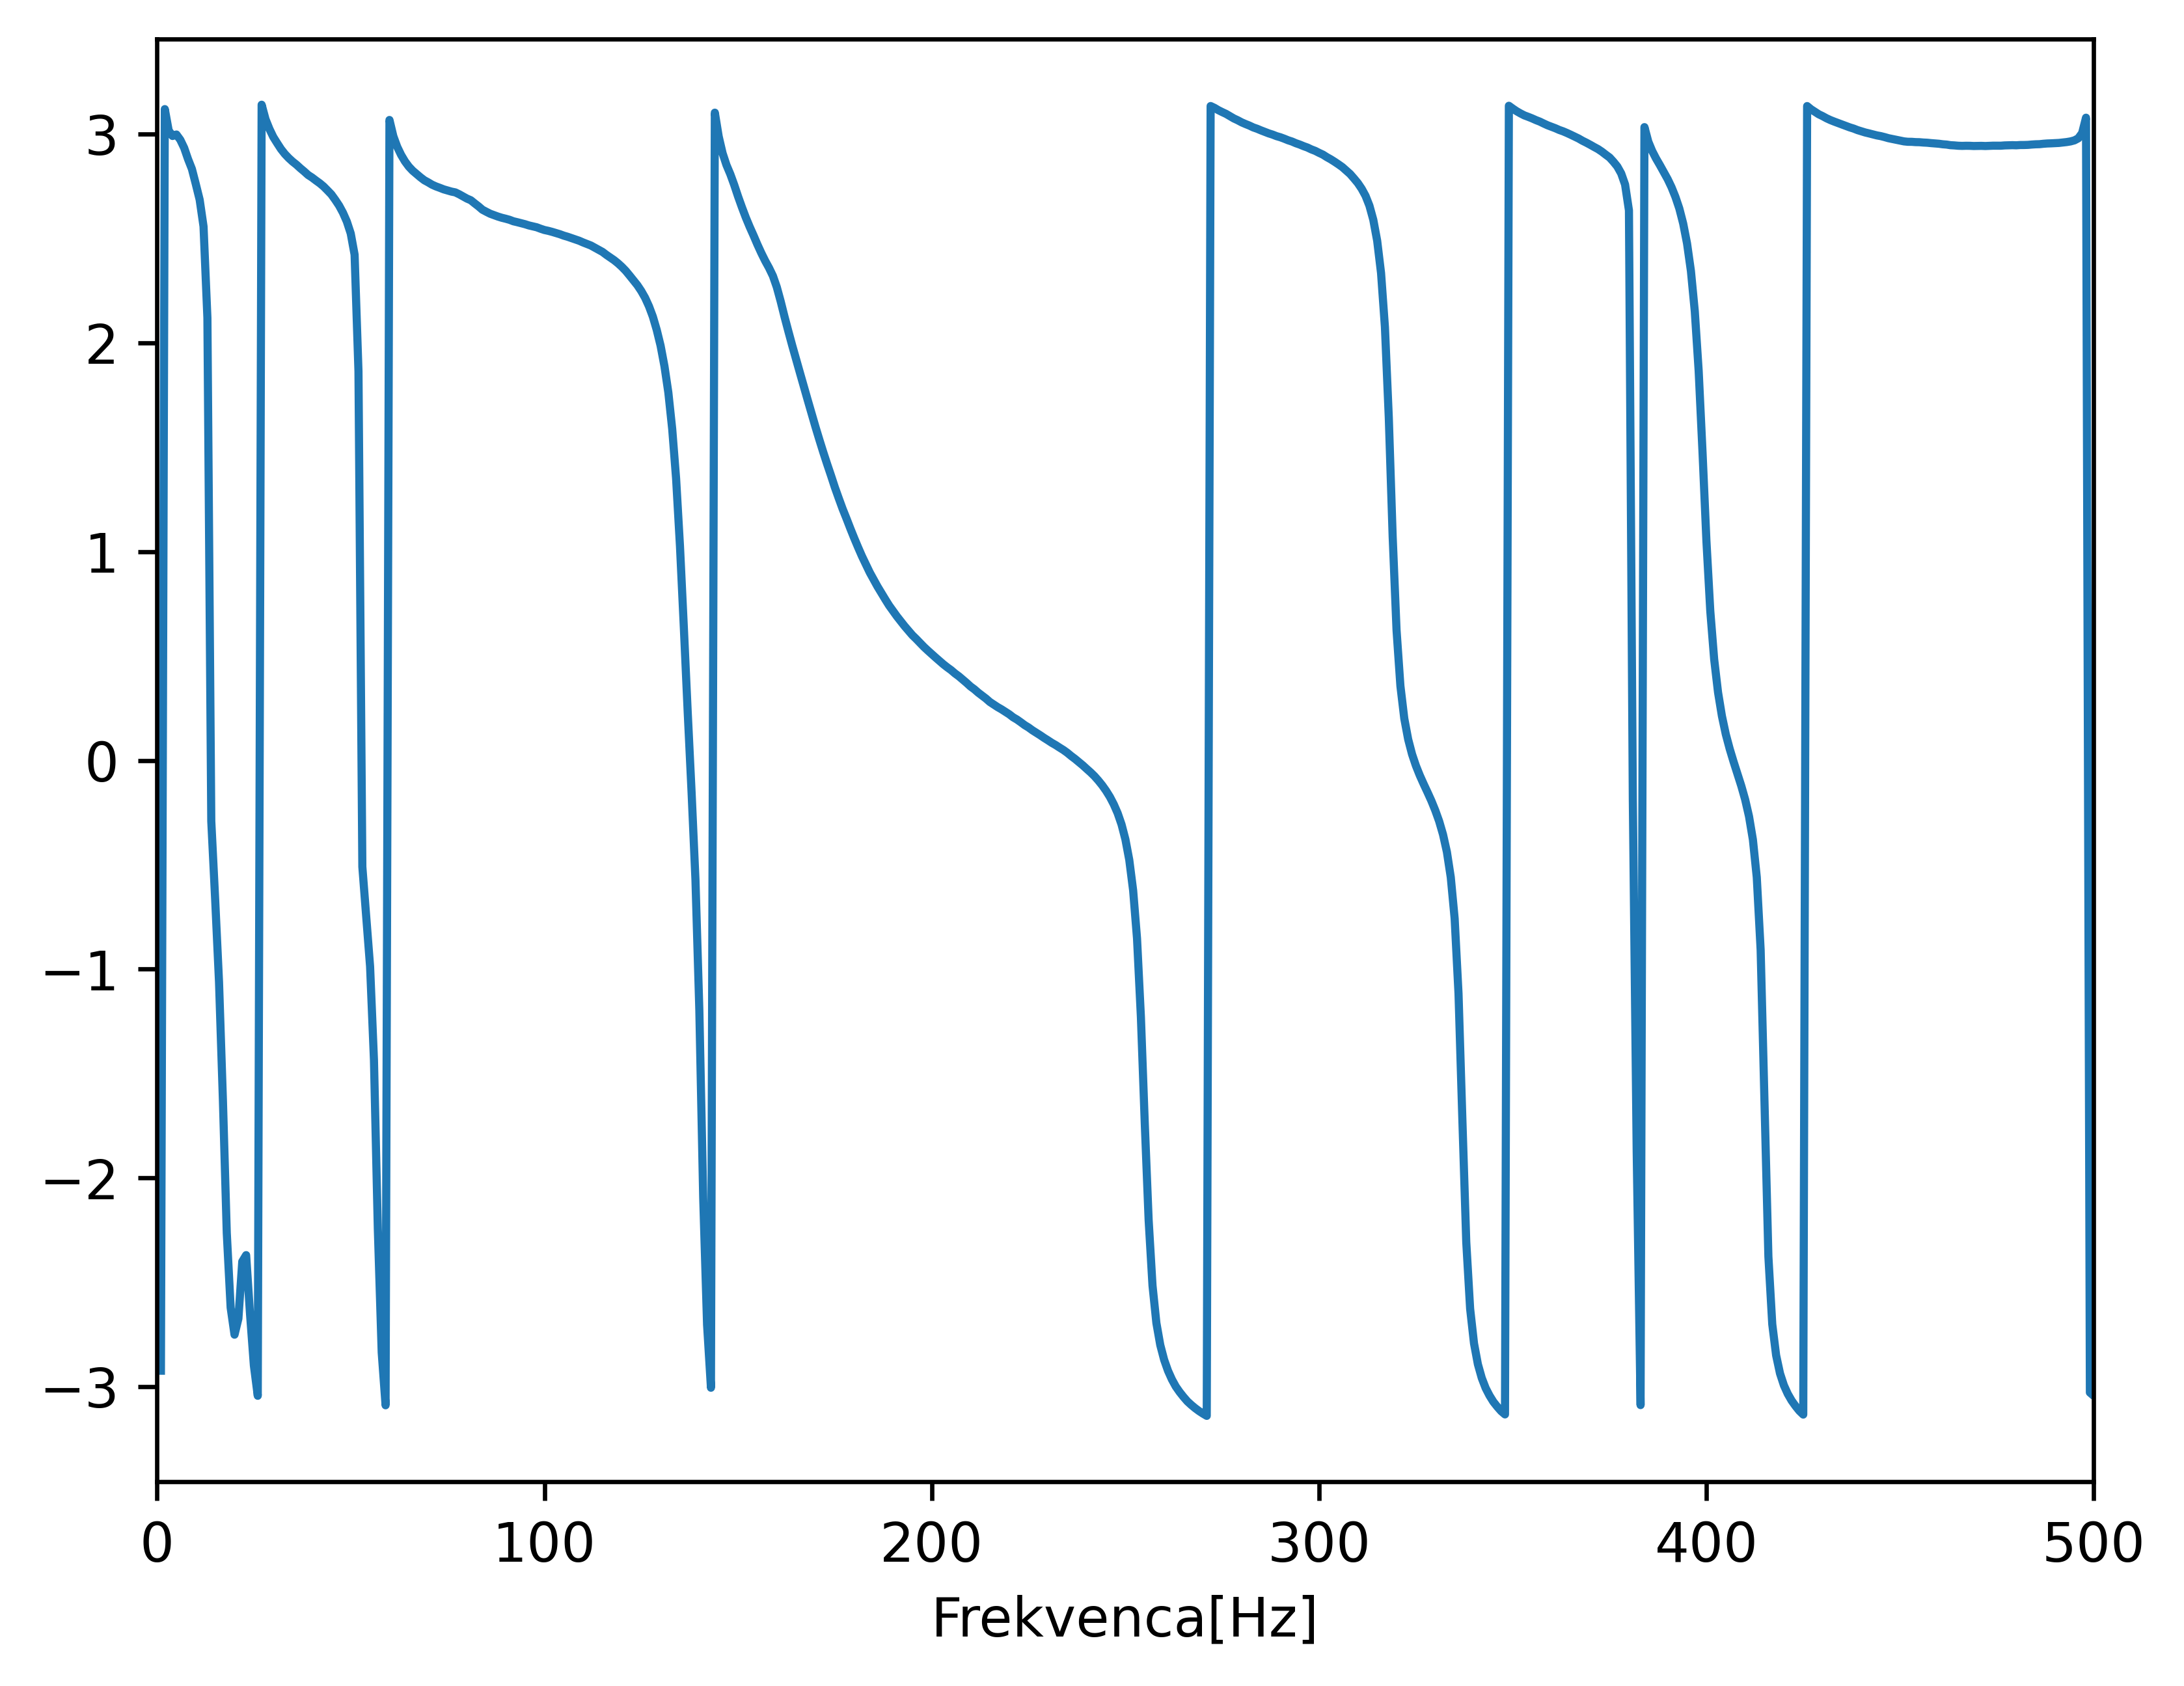

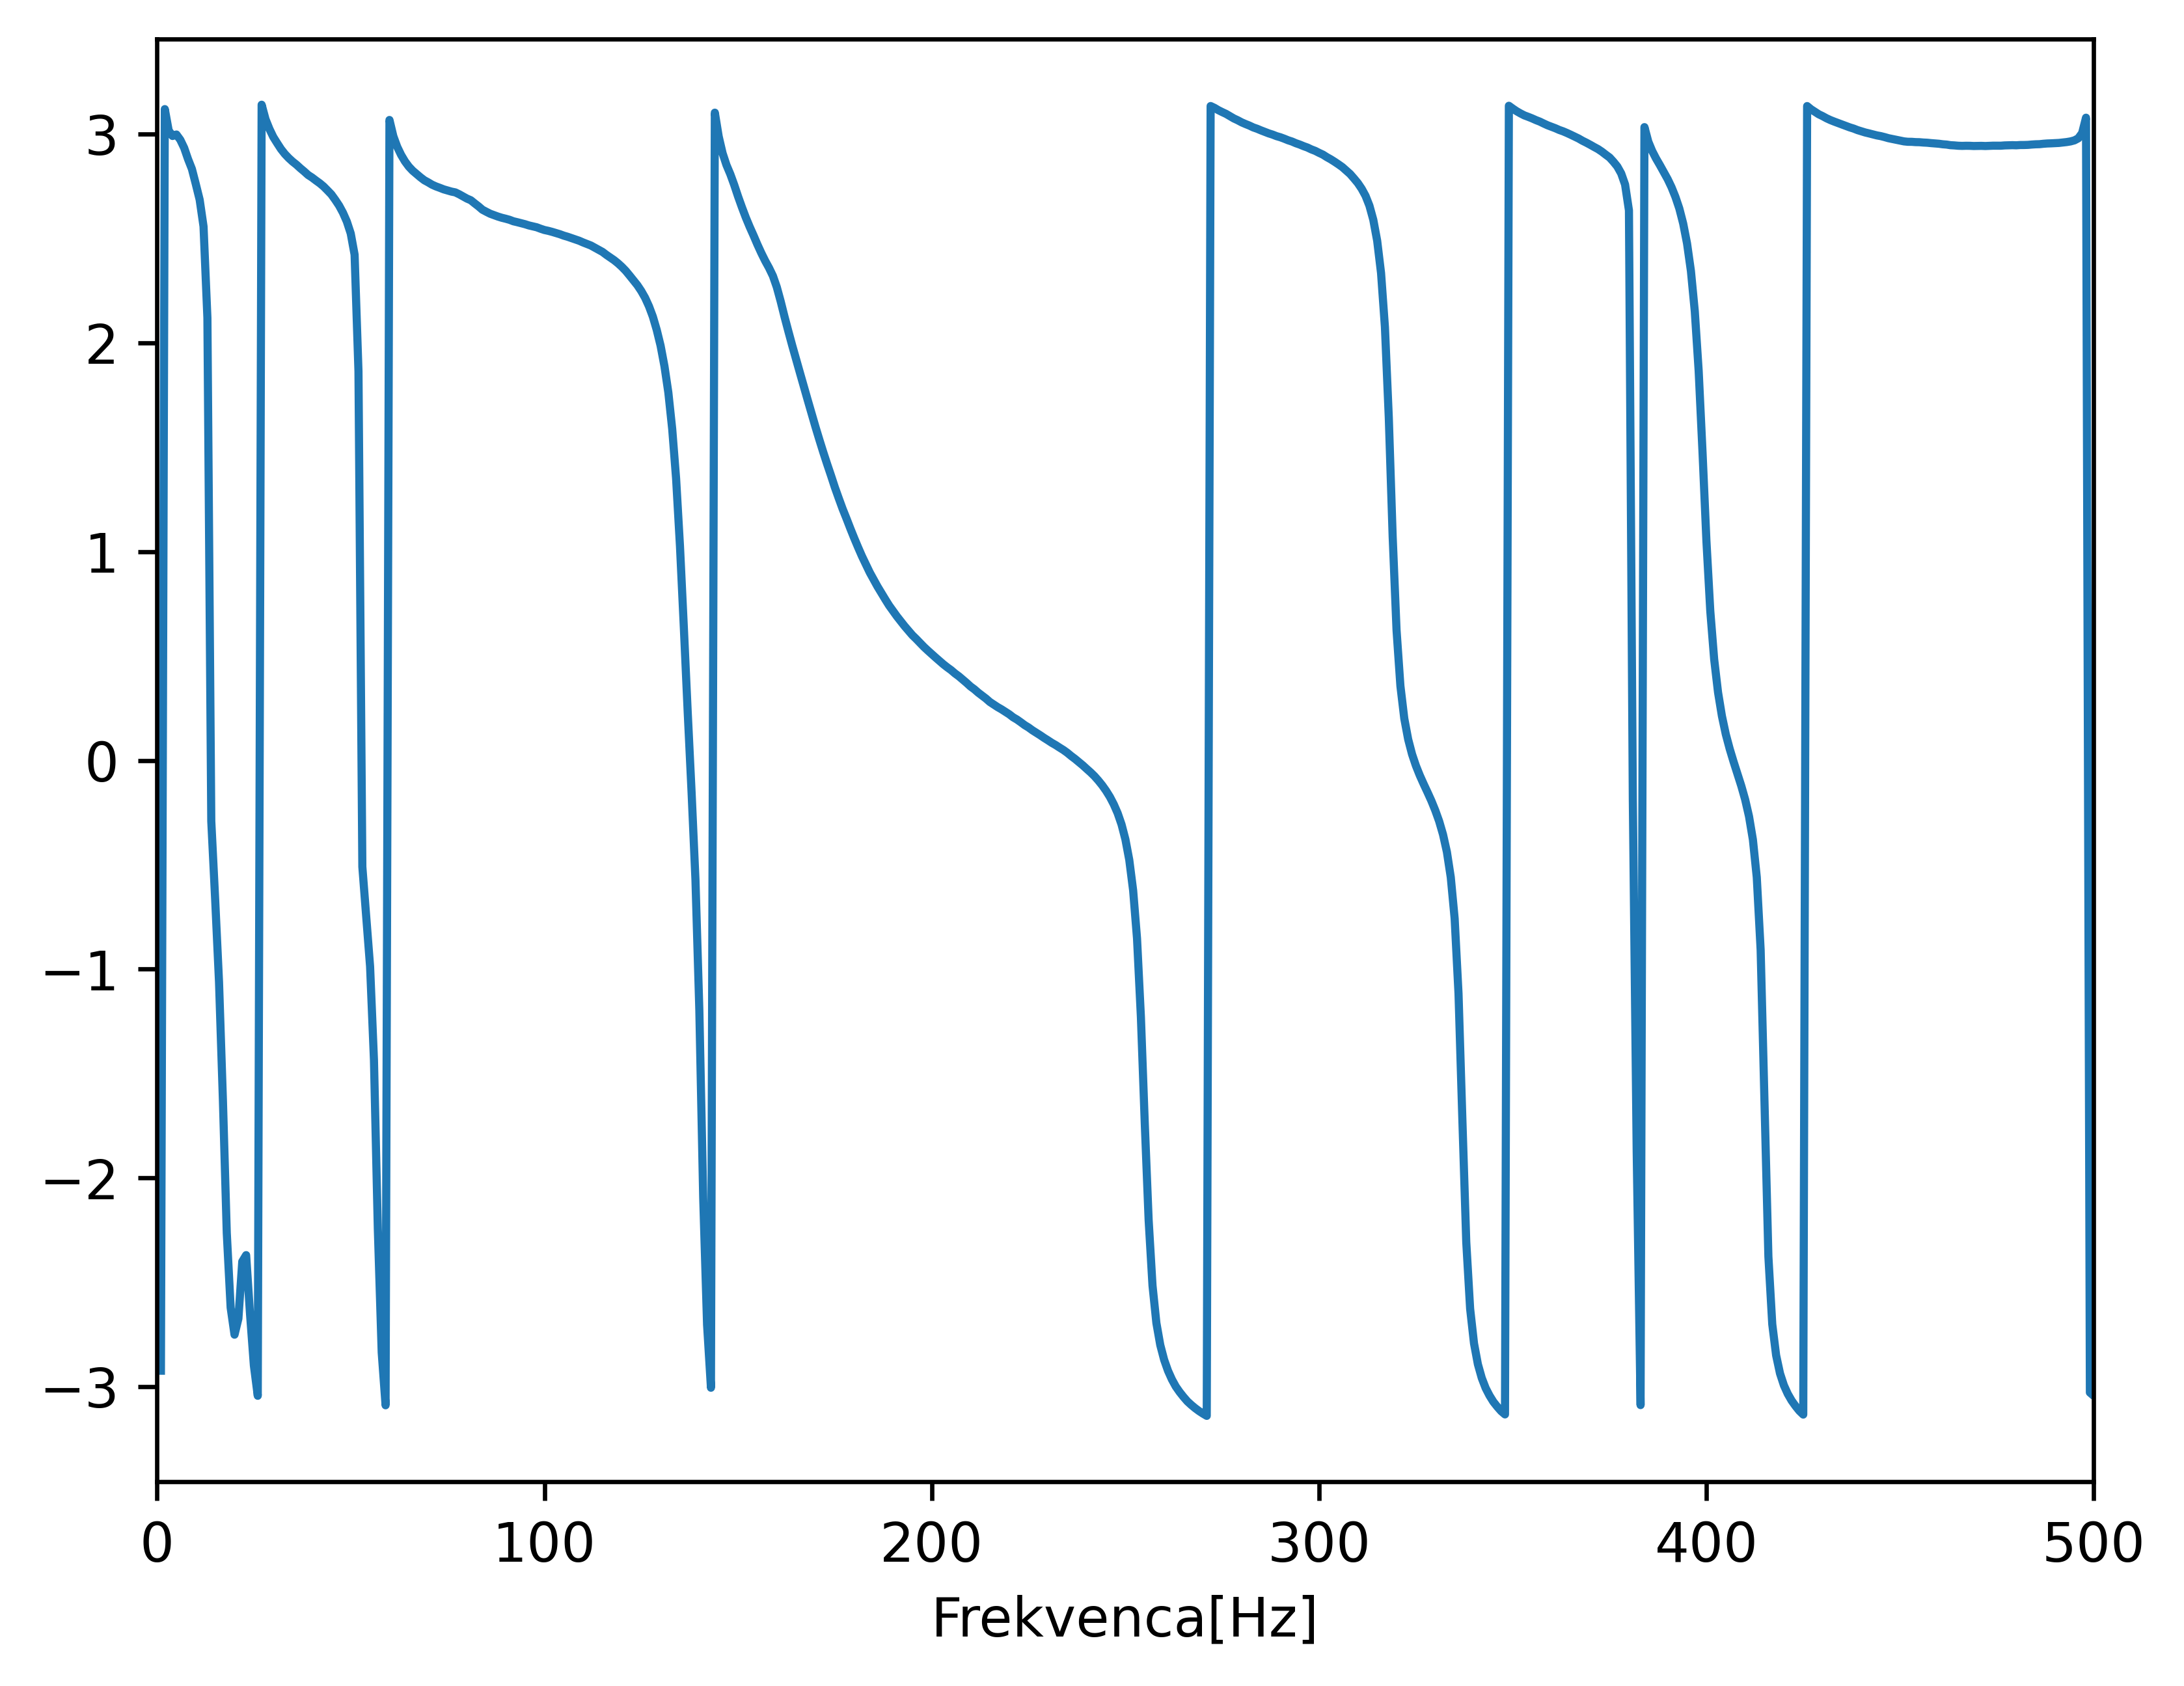

In [27]:
plt.subplots(dpi=600)
plt.semilogy(freq[1:],np.abs(Y2)); #logaritmski plot 
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500)
plt.grid()

plt.subplots(dpi=600)
plt.plot(freq[1:],np.angle(Y2))
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500);

Prkiažemo približan odsek resonančnega vrha ter fazni zamik.

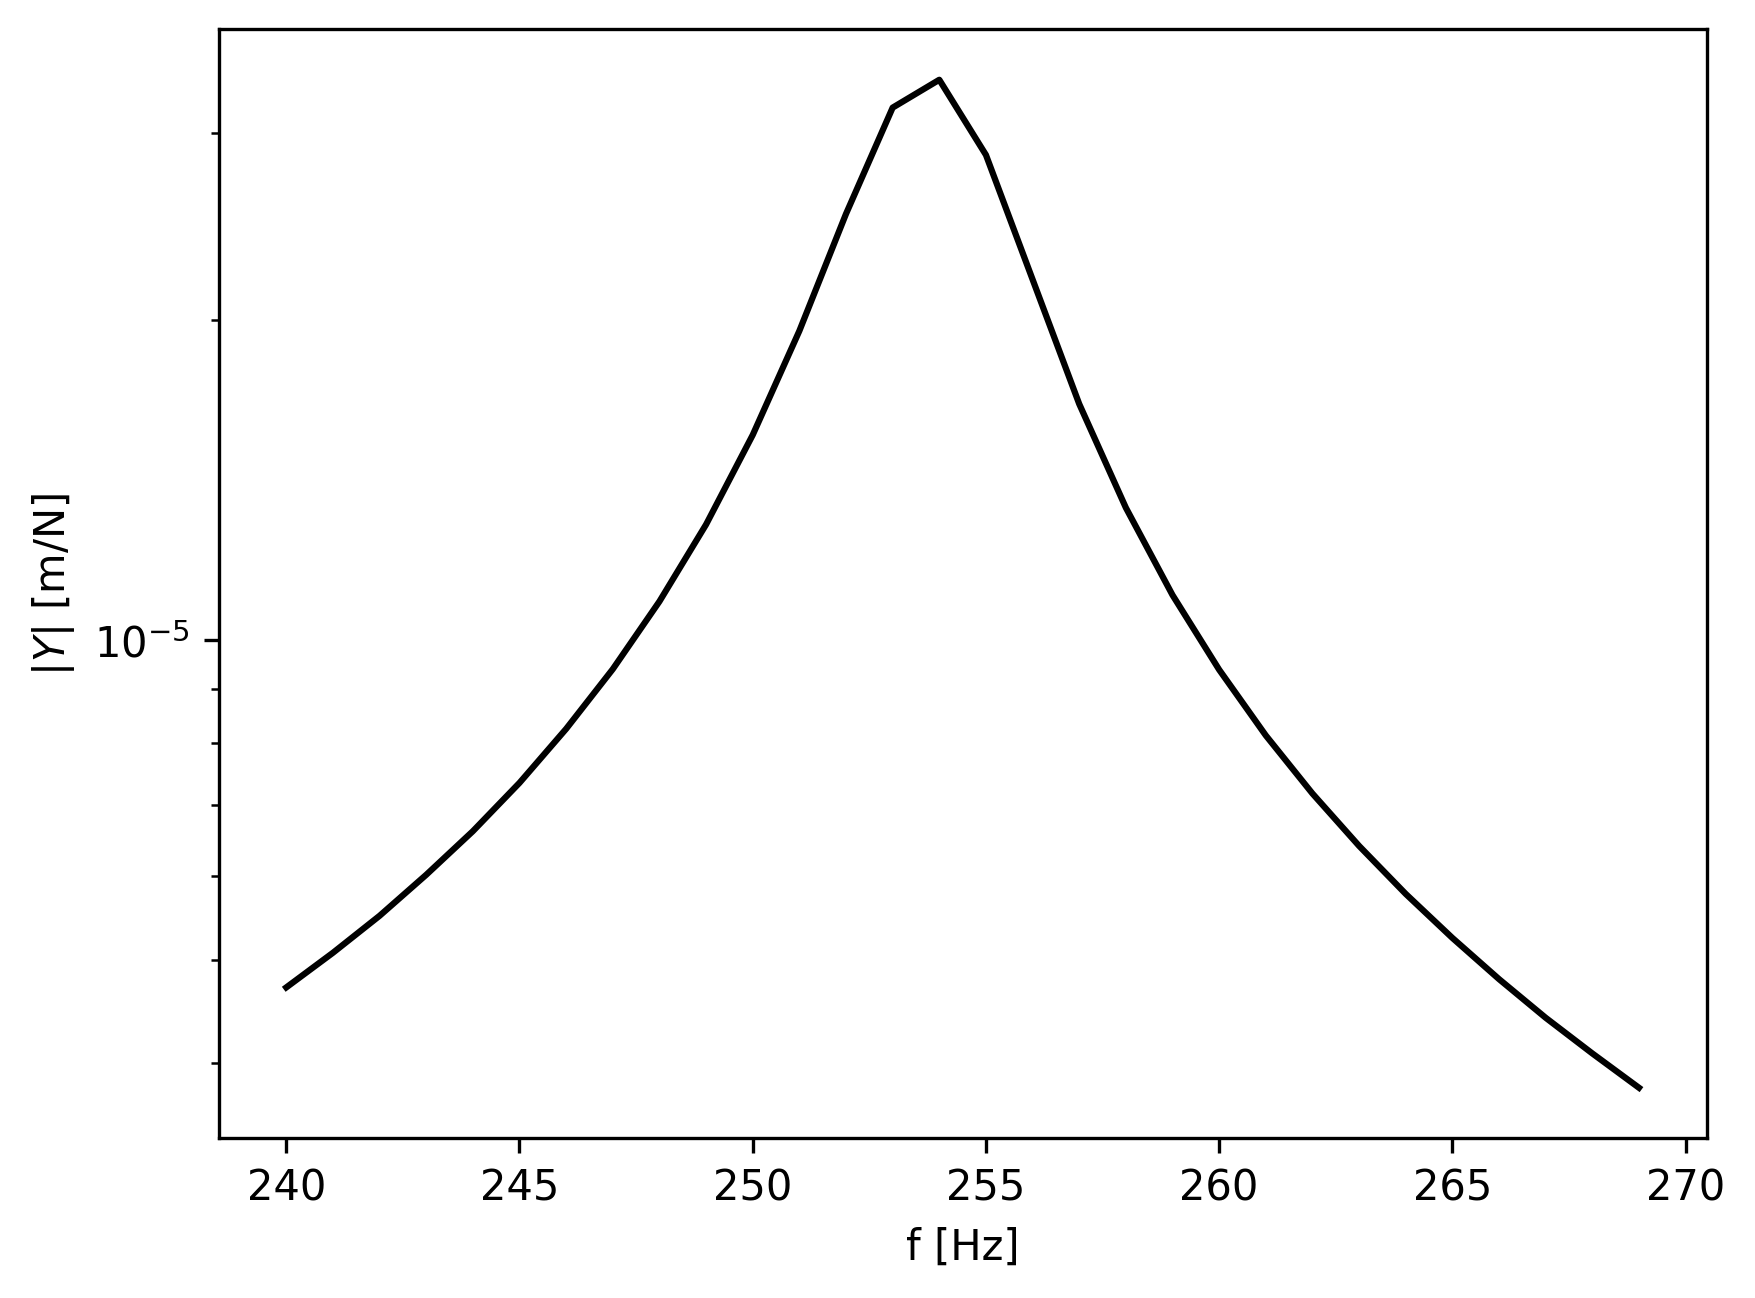

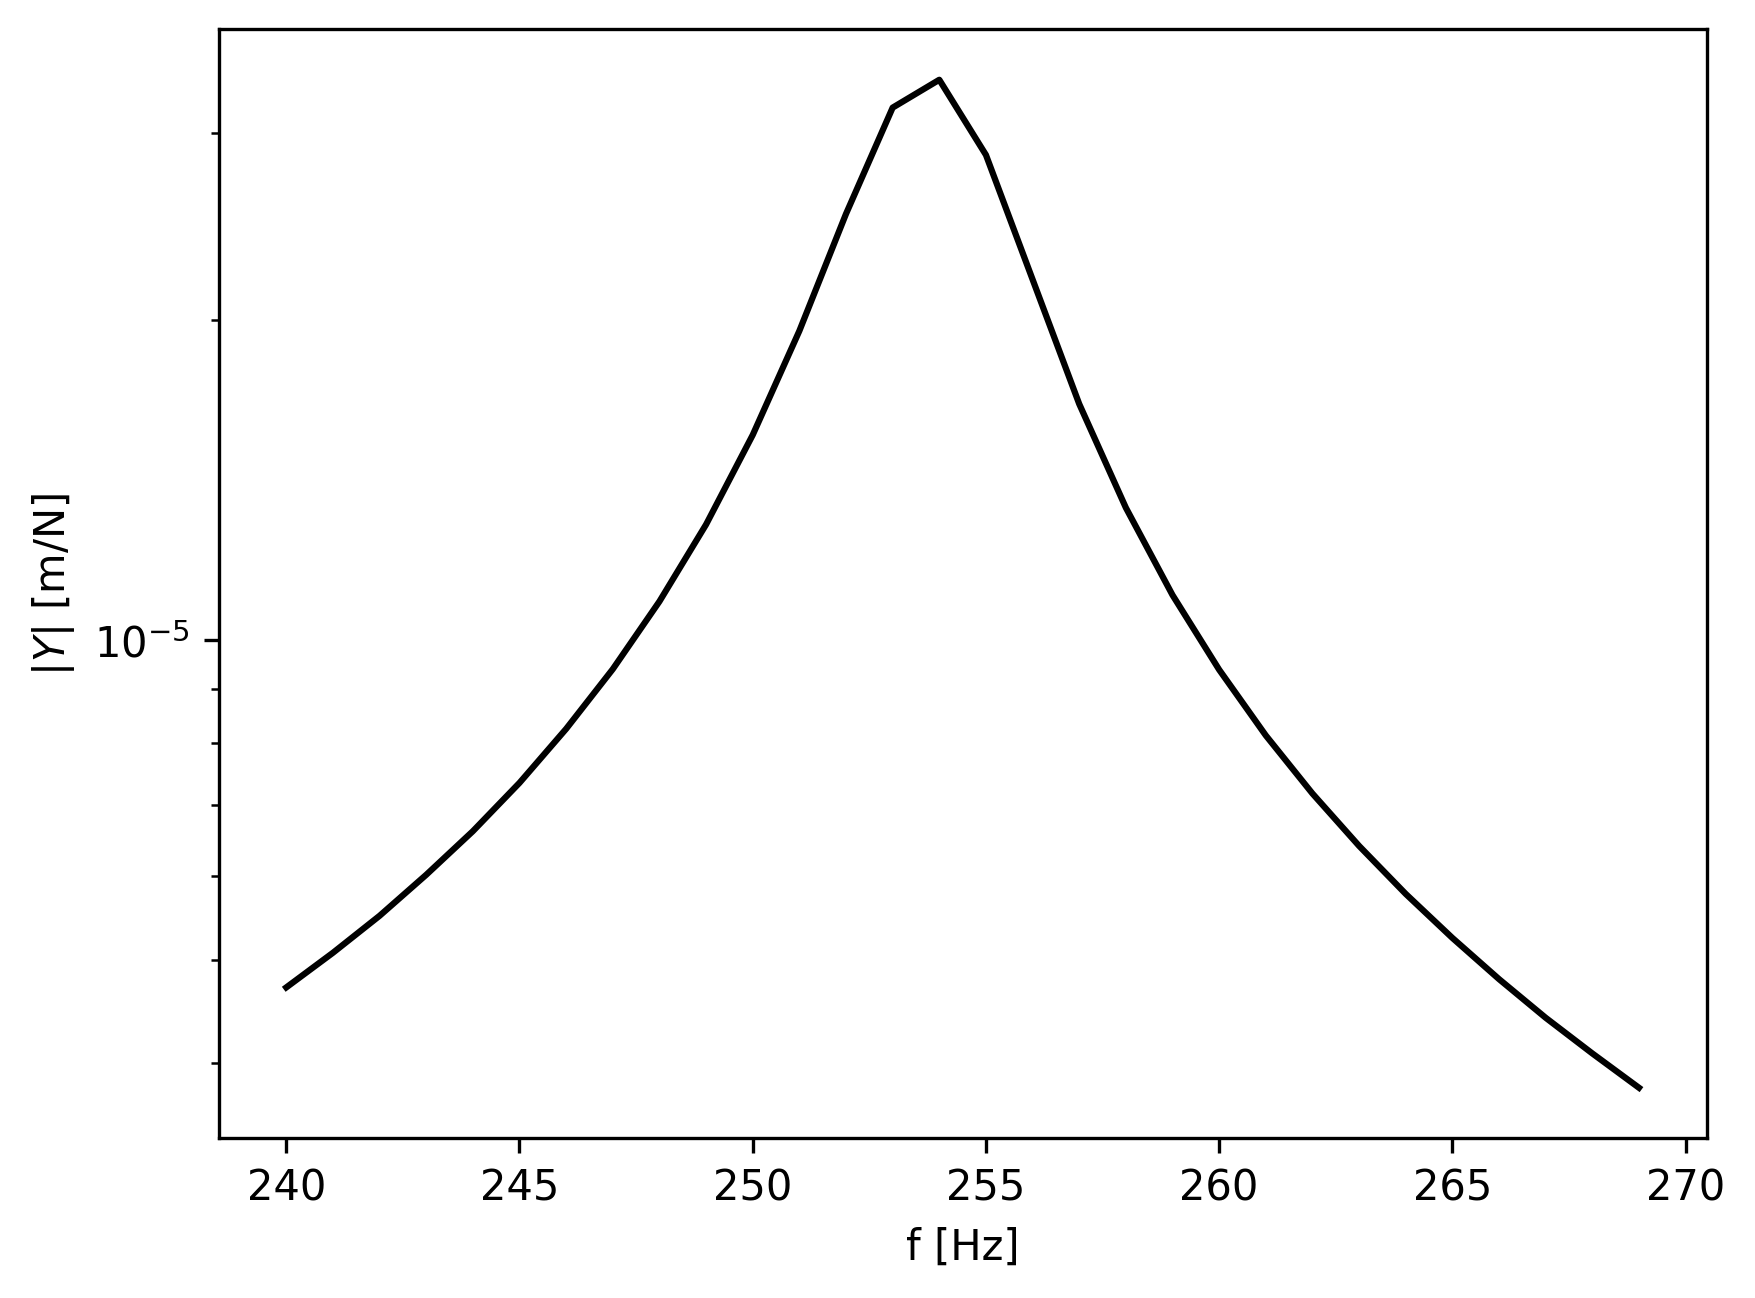

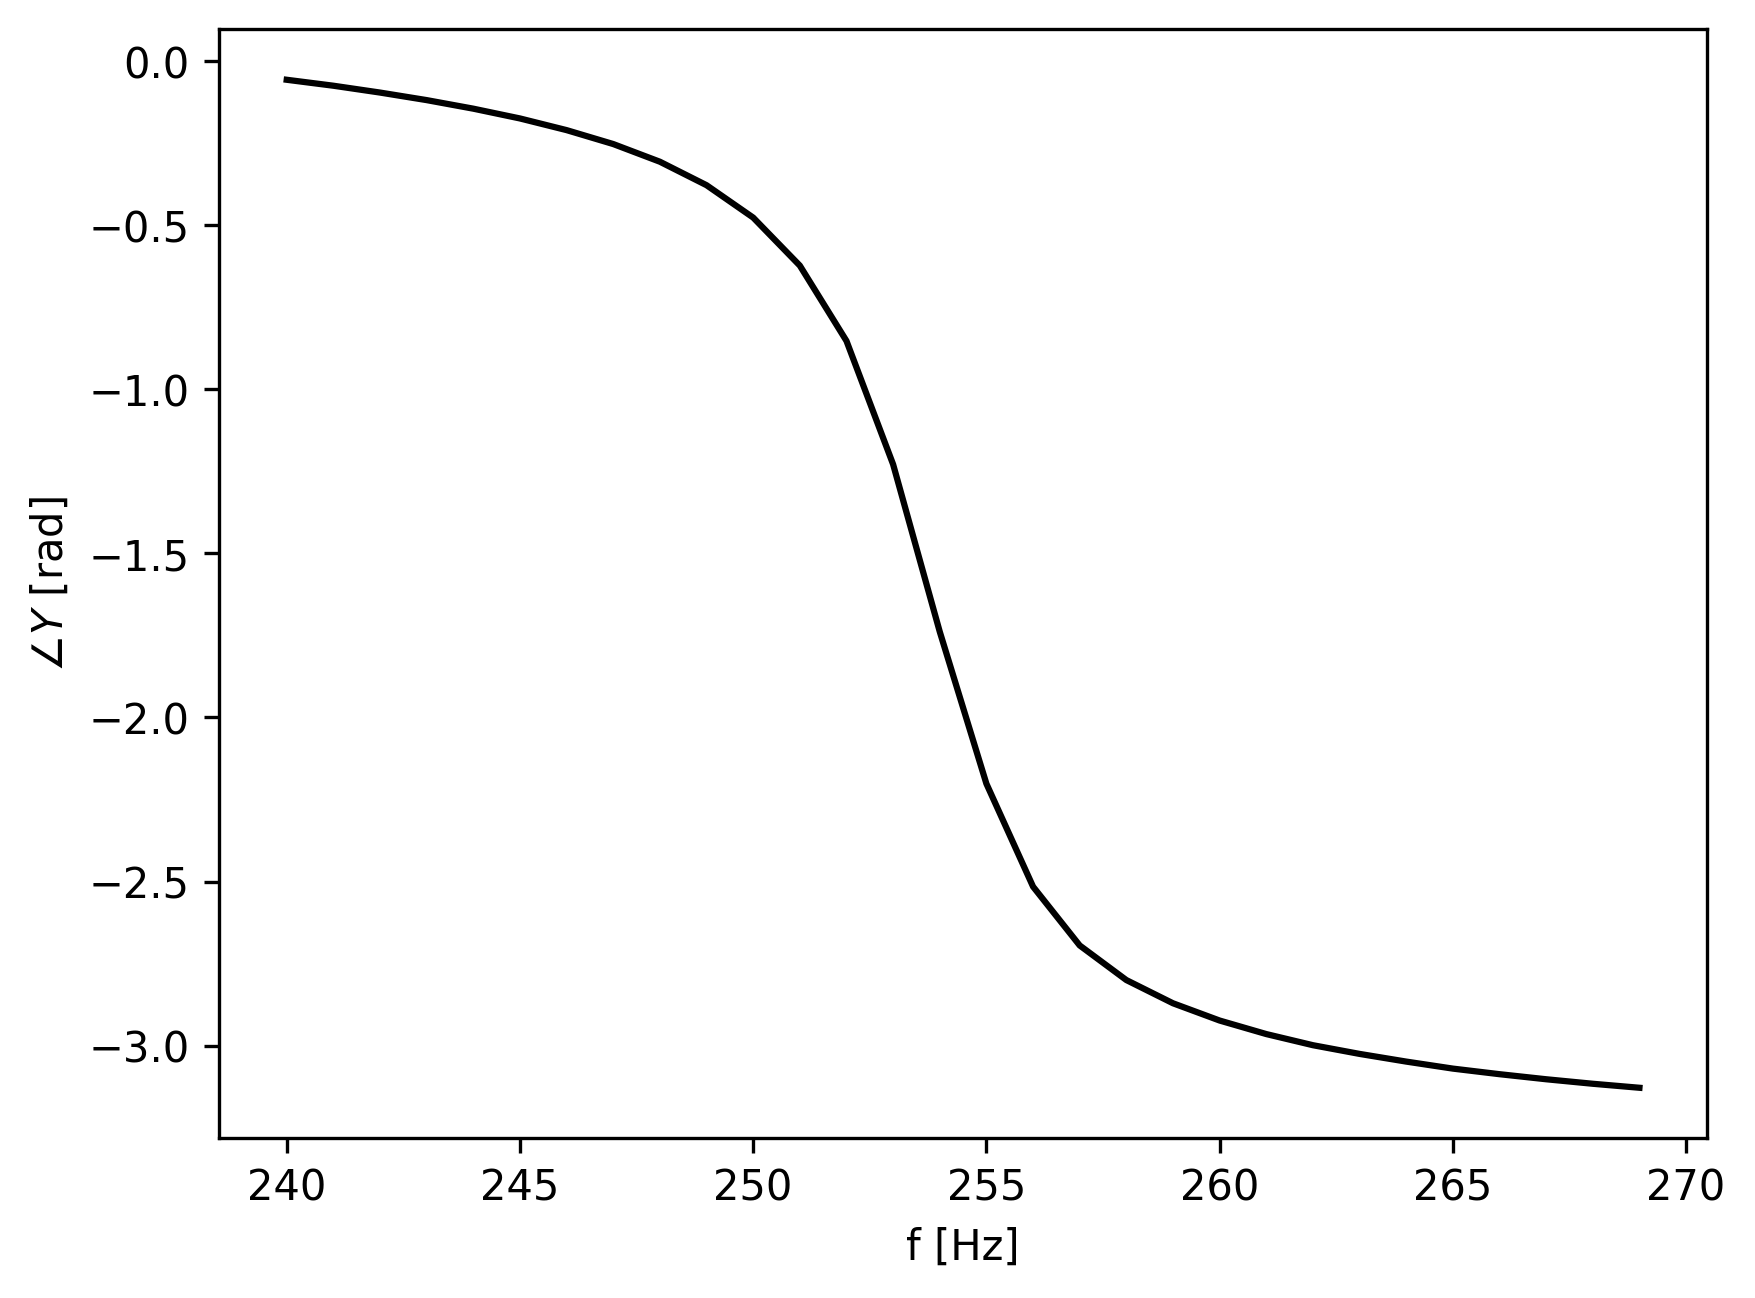

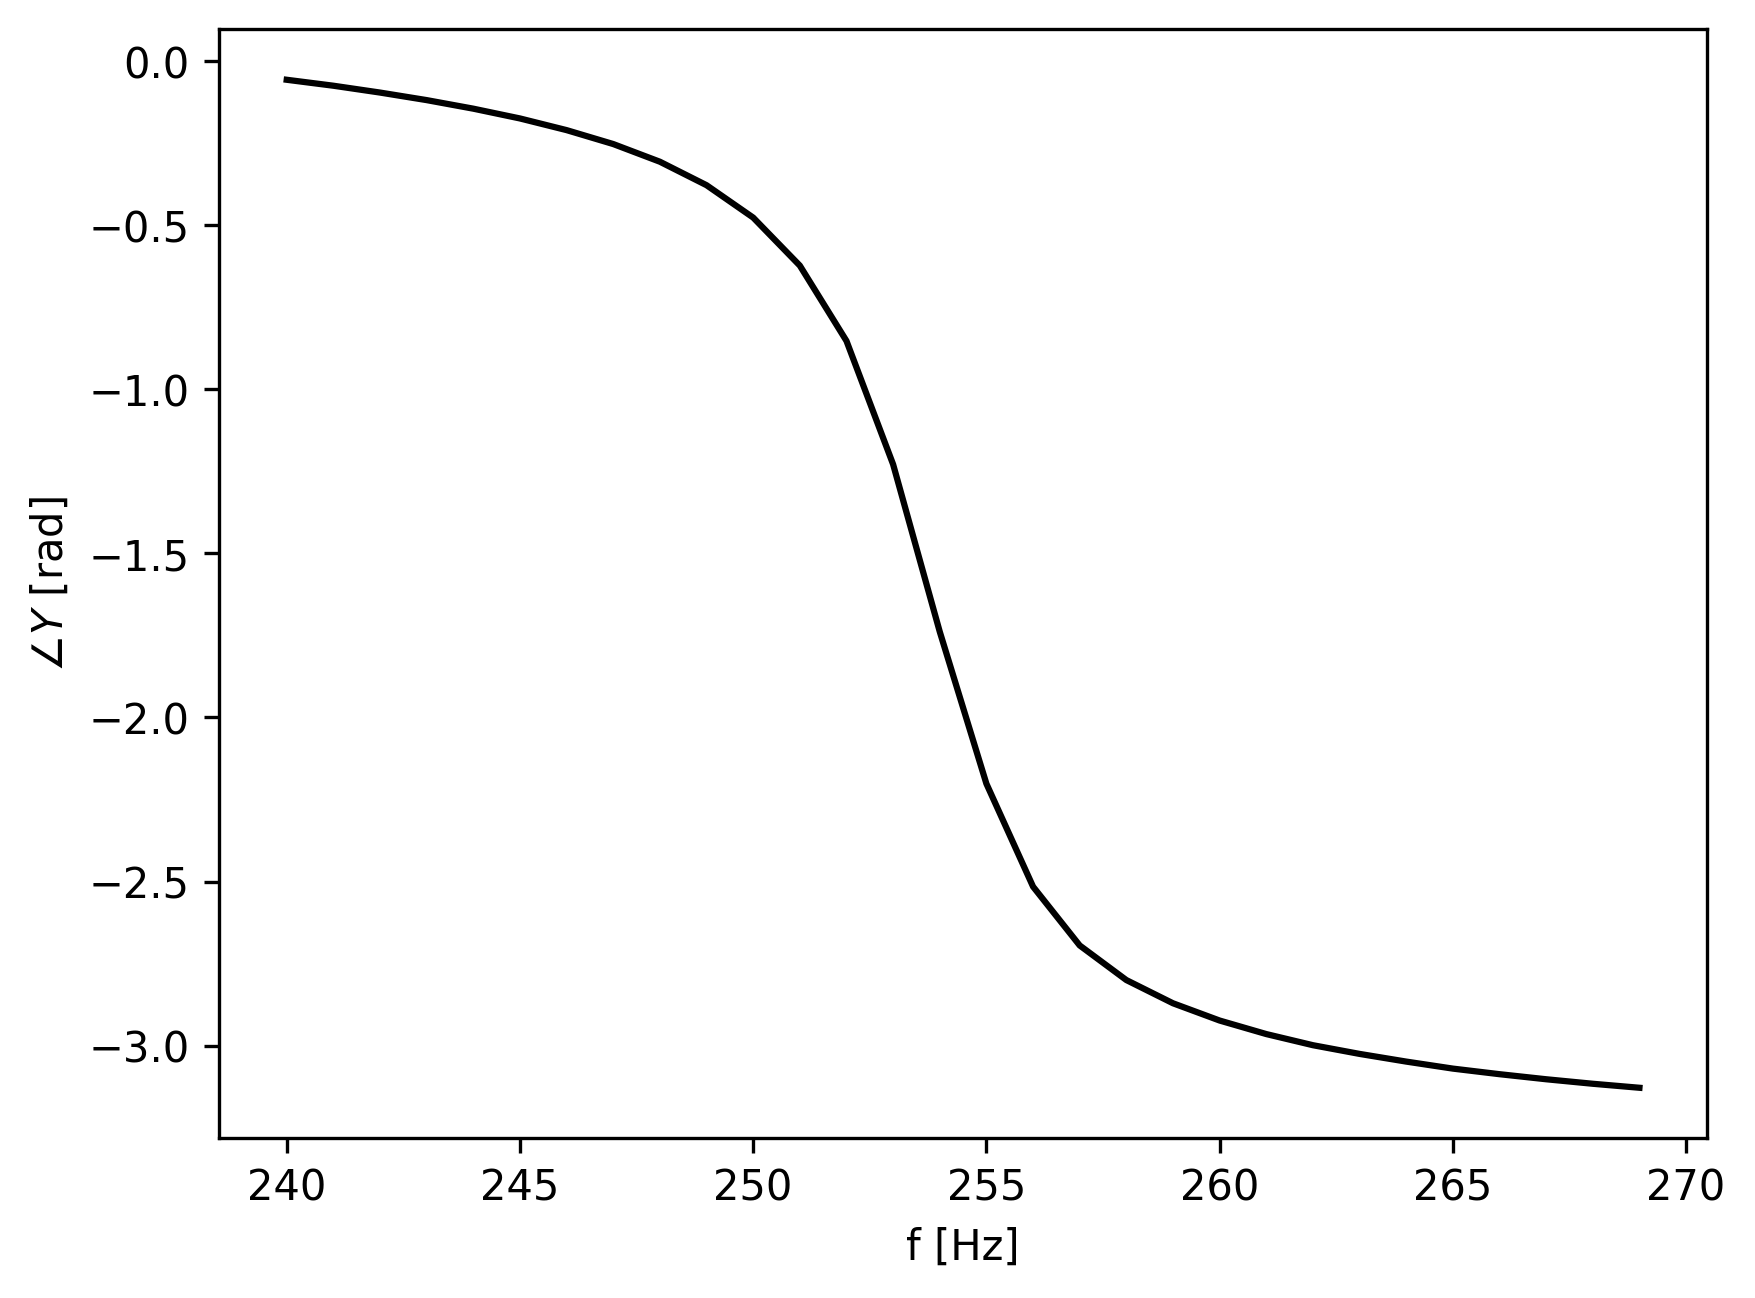

In [28]:
plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)], np.abs(Y2[slice(*fr_range)]),color='k')
plt.ylabel(r'$|Y|$ [m/N]')
plt.xlabel('f [Hz]');

plt.subplots(dpi=300)
plt.plot(freq[slice(*fr_range)], np.angle(Y2[slice(*fr_range)]),color='k')
plt.ylabel(r'$\angle Y$ [rad]');
plt.xlabel('f [Hz]');

To izbrano frekvenčno območje sedaj prikažemo na Nyquistovem diagramu.

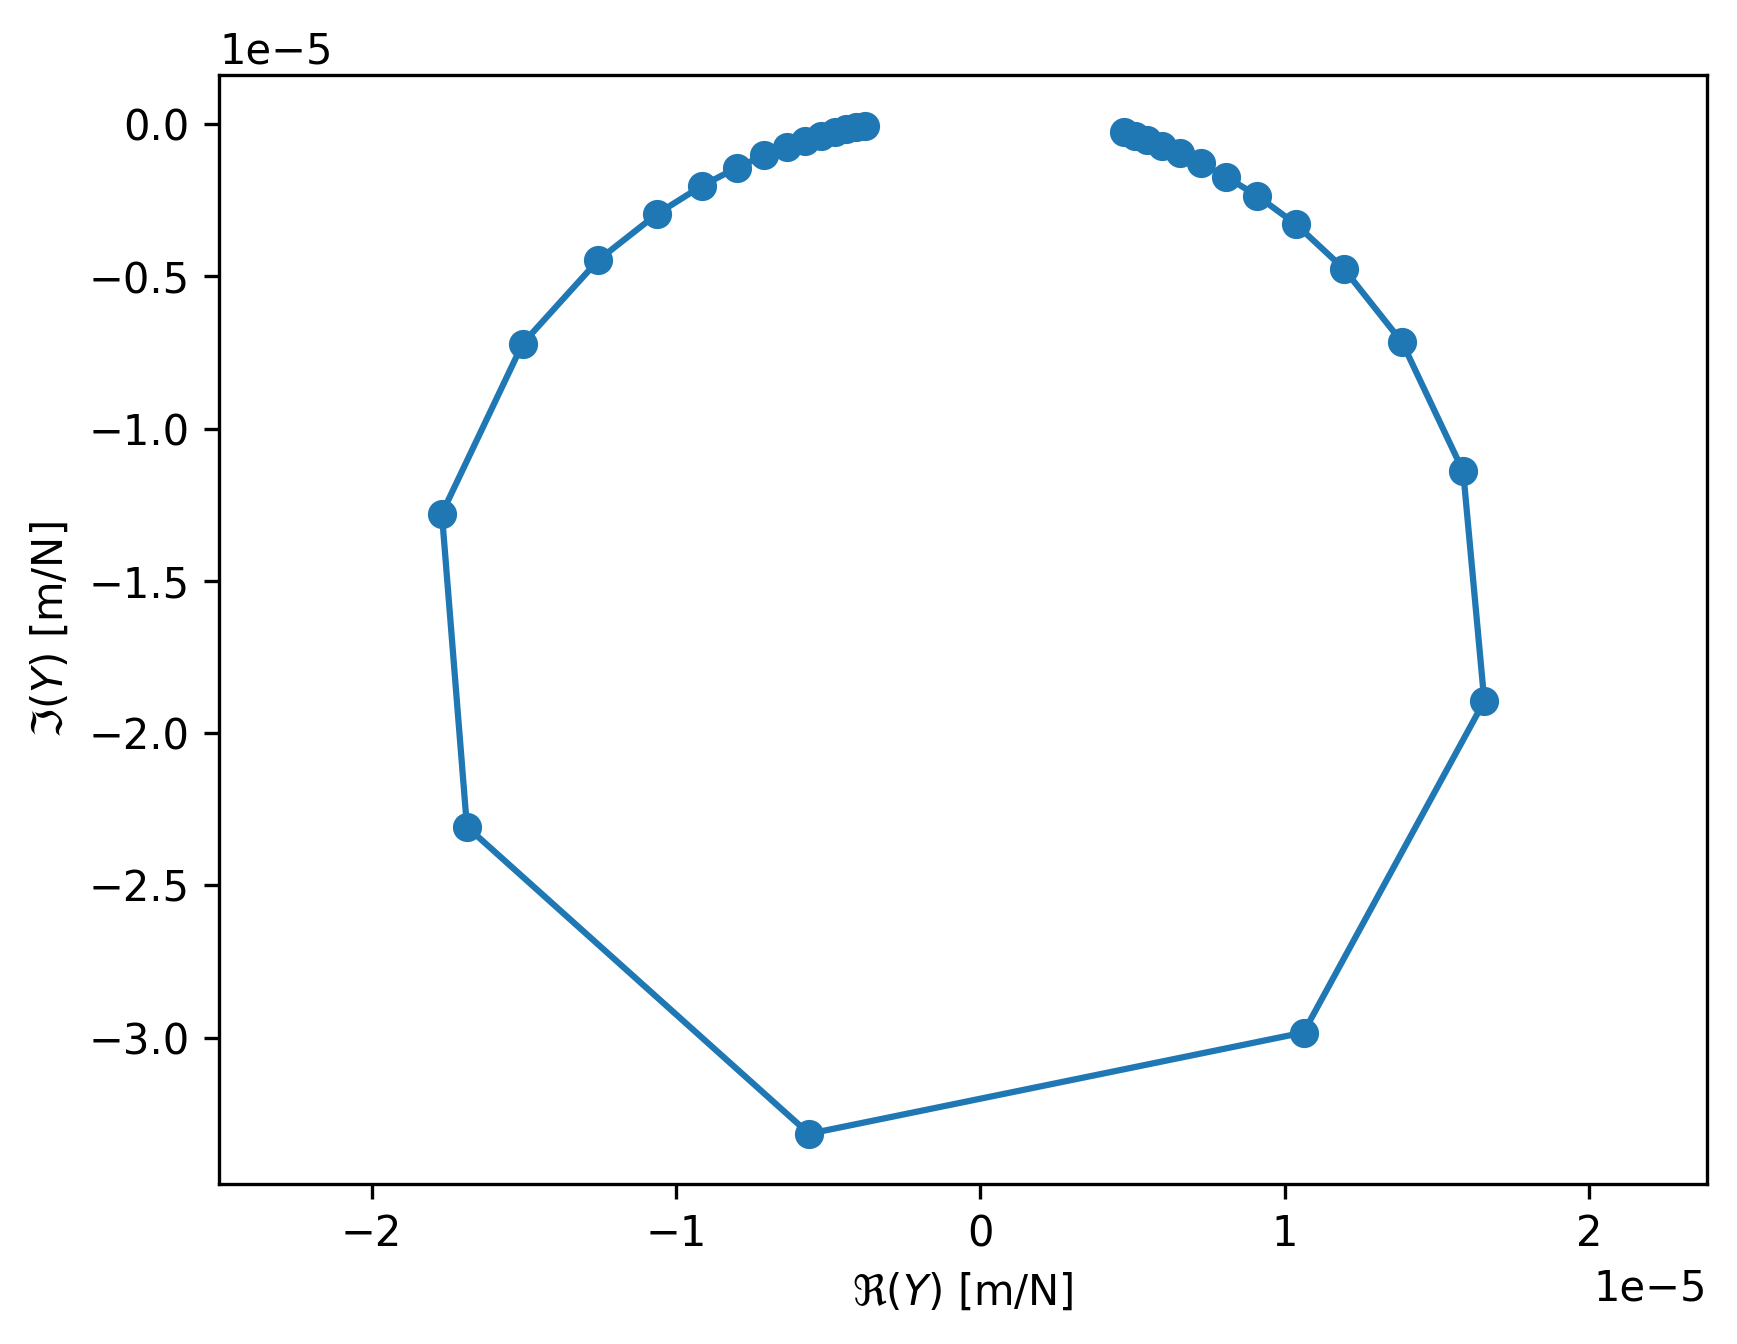

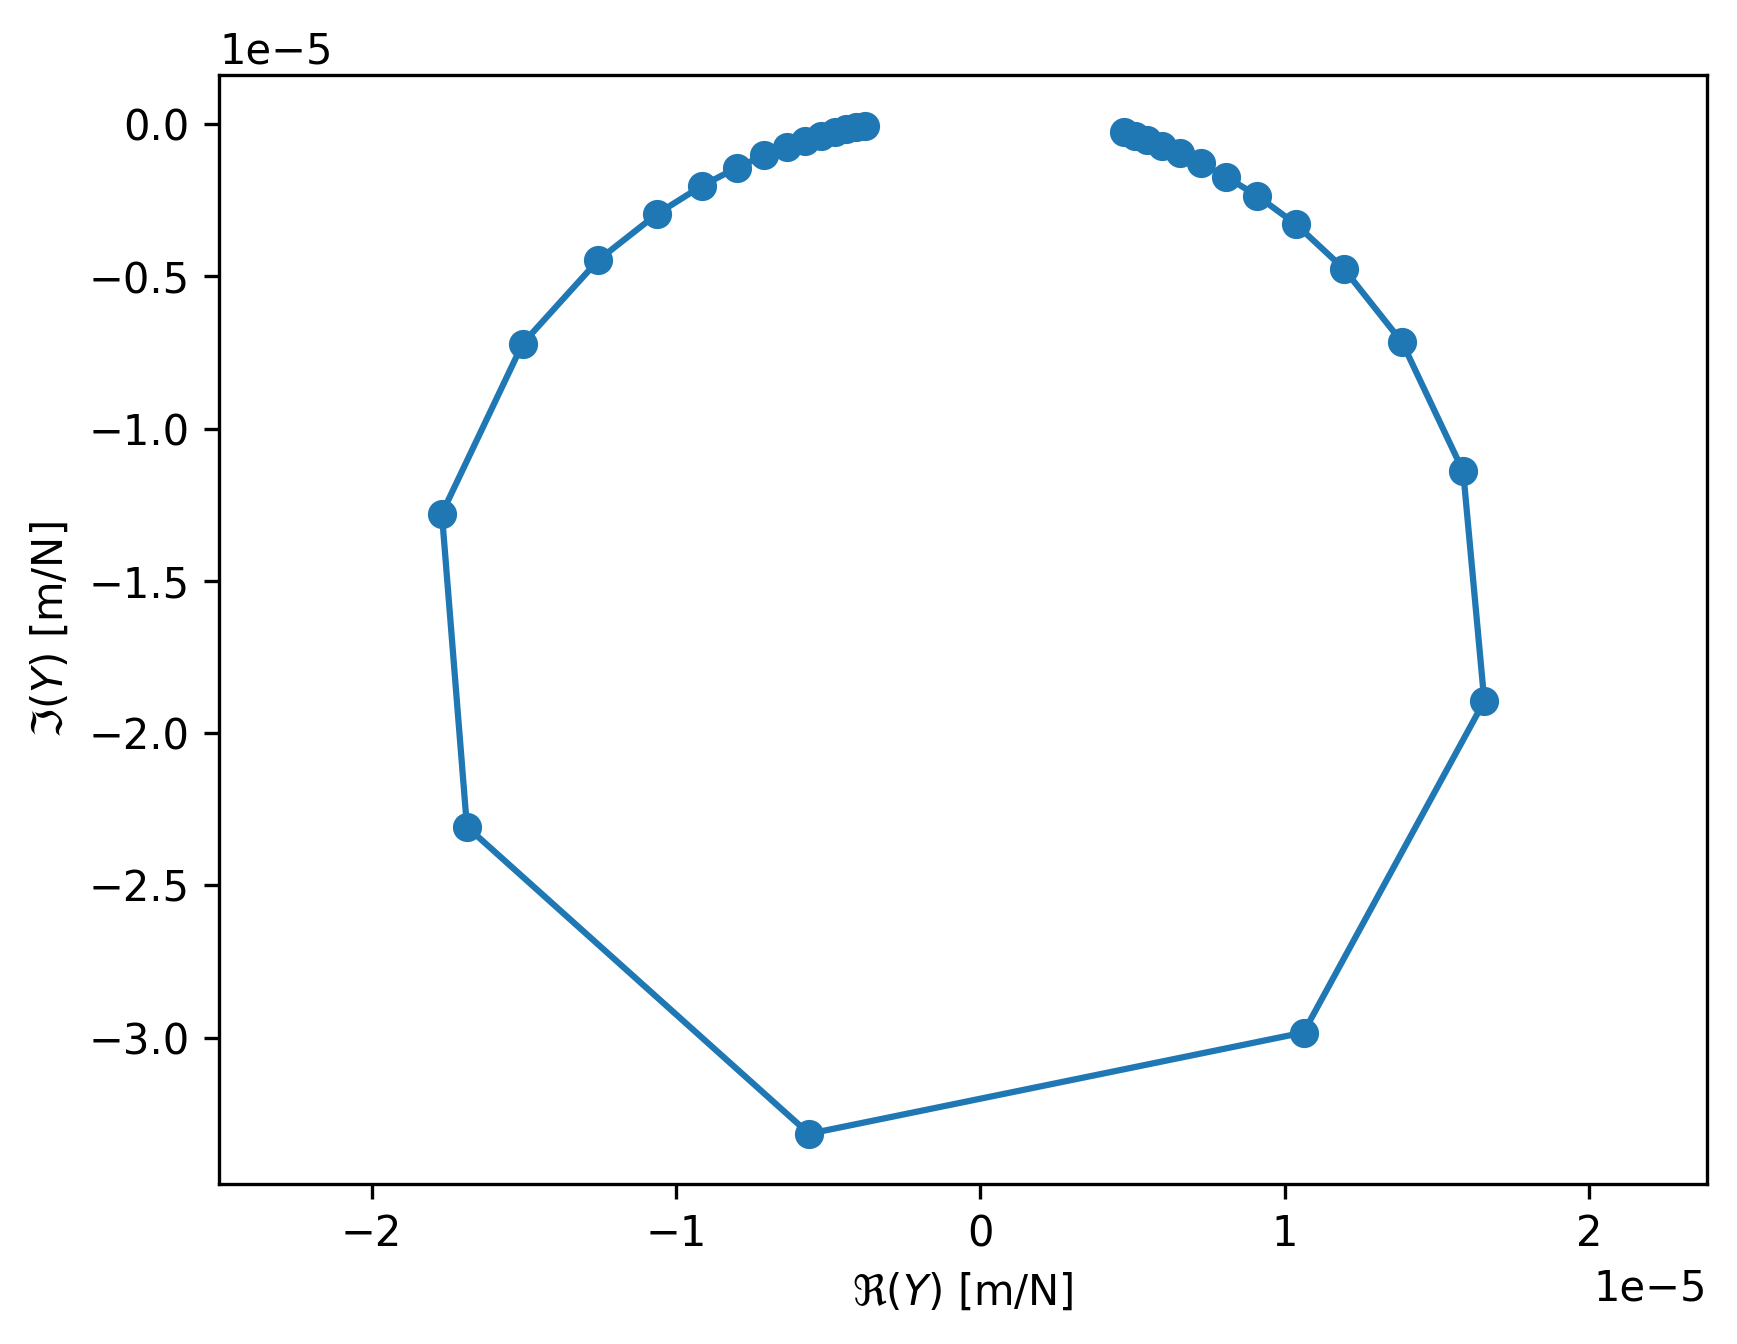

In [29]:
plt.subplots(dpi=300)
plt.plot(np.real(Y2[slice(*fr_range)]), np.imag(Y2[slice(*fr_range)]), 'o-')
plt.ylabel(r'$\Im$($Y$) [m/N]')
plt.xlabel(r'$\Re$($Y$) [m/N]');
plt.axis('equal');


Točke na Nyquistovem diagramu aproksimiramo z krožnico.

In [30]:
xi = np.real(Y2[slice(*fr_range)])
yi = np.imag(Y2[slice(*fr_range)])
# priprava členov matrik
A11 = np.sum(xi ** 2)
A12 = np.sum(xi * yi)
A13 = np.sum(-1 * xi)
A22 = np.sum(yi ** 2)
A23 = np.sum(-1 * yi)
A33 = len(xi)
# priprava členov vektorja konstant
b1 = -1 * (np.sum(xi ** 3) + np.sum(xi * yi ** 2))
b2 = -1 * (np.sum(yi ** 3) + np.sum(yi * xi ** 2))
b3 = np.sum(xi ** 2) + np.sum(yi ** 2)

In [31]:
# kreiranje matrik
A = np.asarray([[A11, A12, A13], [A12, A22, A23], [A13, A23, A33]])
b_ = np.asarray([[b1], [b2], [b3]])
# reševanje sistema enačb
a, b, c = np.linalg.solve(A, b_)
# ločevanje vrednosti
x0 = float(-a/2)
y0 = float(-b/2)
R0 = float(np.sqrt(c + x0**2 + y0**2))

In [32]:
import numpy as np
import math

def circle_fit(xi, yi):
    """
    Izračun parametrov kroga (izhodišče, radij)

    :param xi: realna komponenta frekvenčne prenosne funkcije na izbranem frekvenčnem intervalu
    :type xi: array(float)
    :param yi: imaginarna komponenta frekvenčne prenosne funkcije na izbranem frekvenčnem intervalu
    :type yi: array(float)
    
    :return x0: realna koordinata izhodišča kroga
    :return y0: imaginarna koordinata izhodišča kroga
    :return R0: radij kroga
    """

    # priprava členov matrik
    A11 = np.sum(xi ** 2)
    A12 = np.sum(xi * yi)
    A13 = np.sum(-1 * xi)
    A22 = np.sum(yi ** 2)
    A23 = np.sum(-1 * yi)
    A33 = len(xi)

    # priprava členov vektorja konstant
    b1 = -1 * (np.sum(xi ** 3) + np.sum(xi * yi ** 2))
    b2 = -1 * (np.sum(yi ** 3) + np.sum(yi * xi ** 2))
    b3 = np.sum(xi ** 2) + np.sum(yi ** 2)
    
    # kreiranje matrik
    A = np.asarray([[A11, A12, A13], [A12, A22, A23], [A13, A23, A33]])
    v = np.asarray([[b1], [b2], [b3]])

    # reševanje sistema enačb
    a, b, c = np.linalg.solve(A, v)

    # ločevanje vrednosti
    x0 = float(-a/2)
    y0 = float(-b/2)
    R0 = float(np.sqrt(c + x0**2 + y0**2))
    
    return x0, y0, R0

In [33]:
x0, y0, r0 = circle_fit(np.real(Y2[slice(*fr_range)]),np.imag(Y2[slice(*fr_range)]))
print(x0, y0, r0)

-4.997507589311151e-07 -1.6843405888719307e-05 1.7270160333348265e-05
-4.997507589311151e-07 -1.6843405888719307e-05 1.7270160333348265e-05


Prikažemo točke in aproksimacijo krožnice. Tako lahko vizualno preverimo ali aproksimirana krožnica ustreza frekvenčni prenosni funkciji.

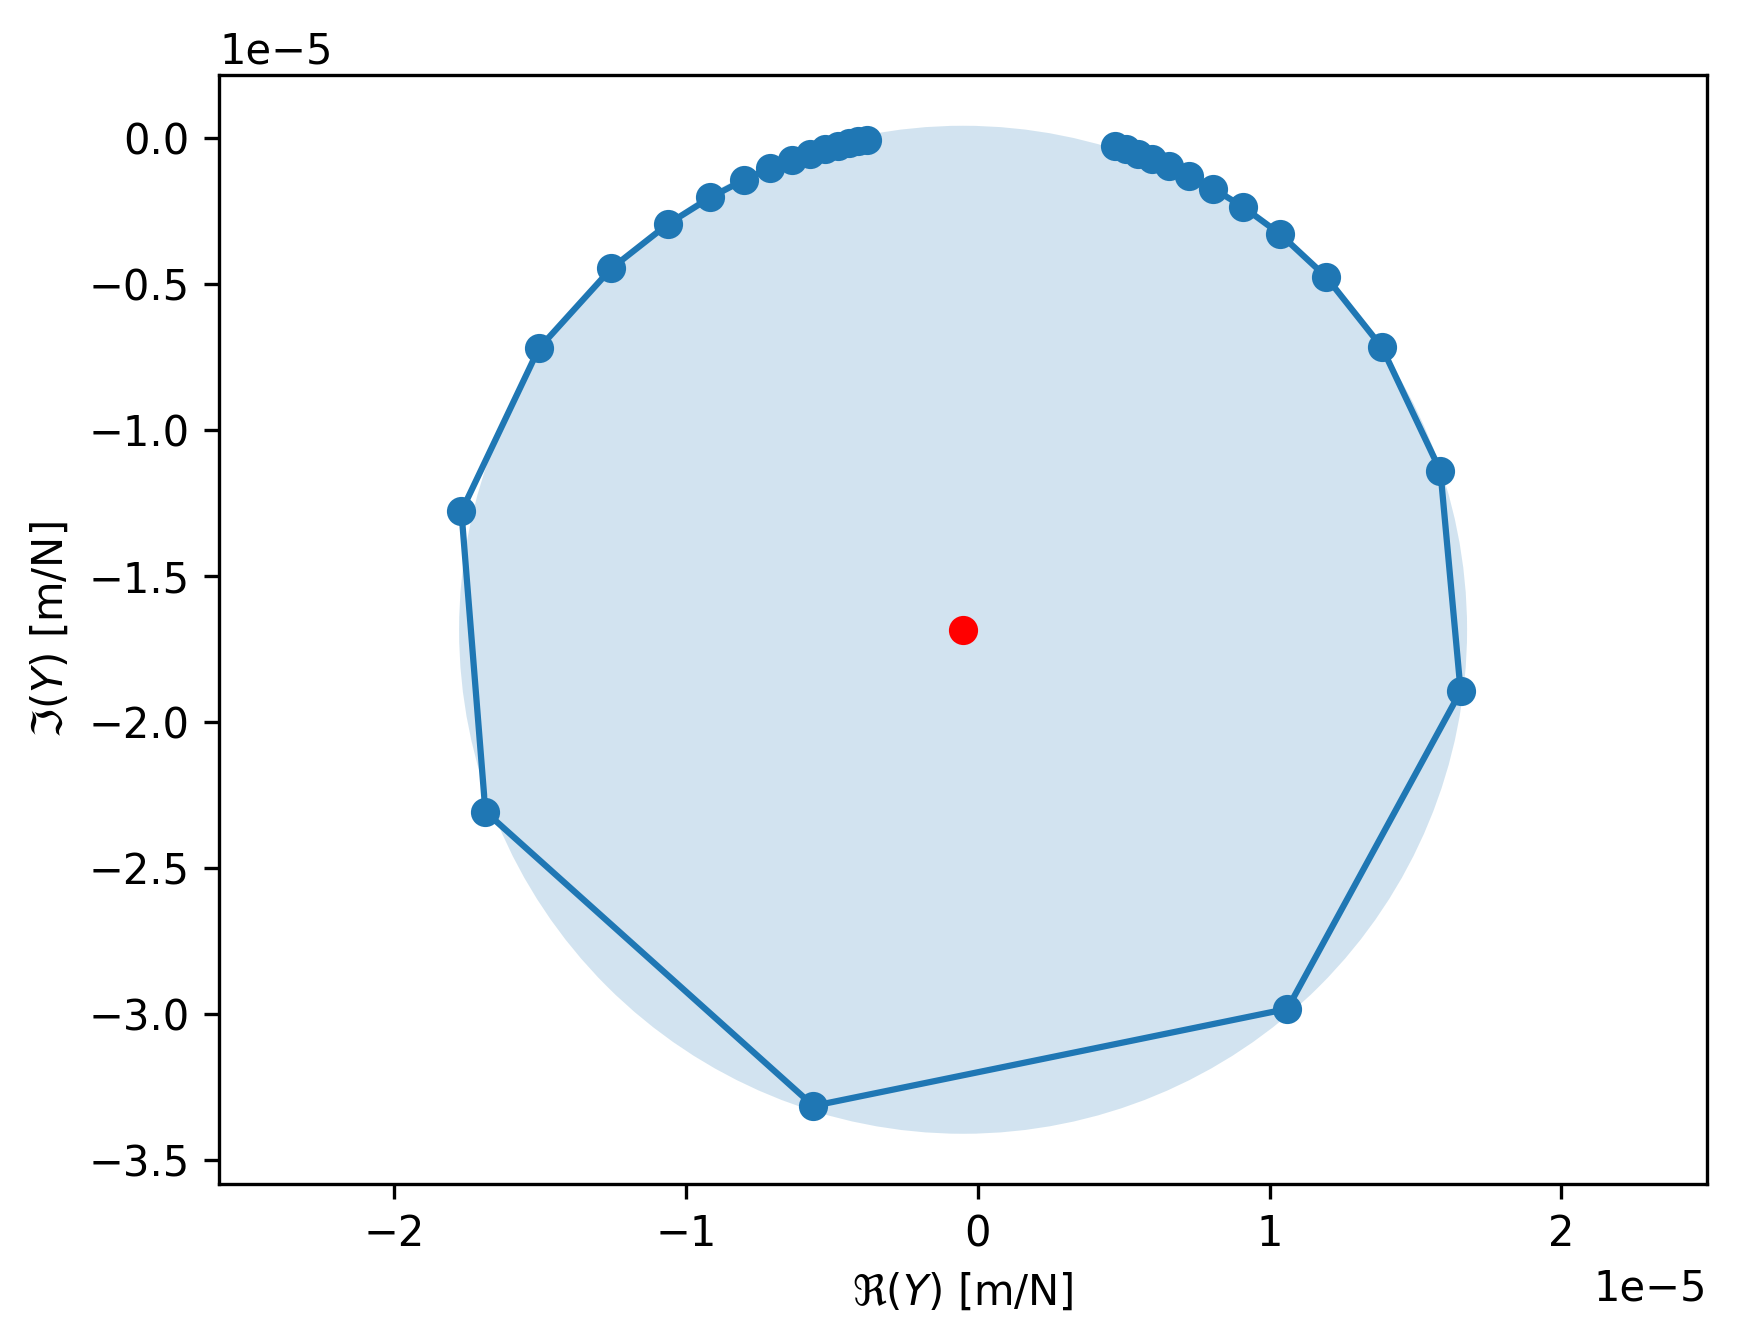

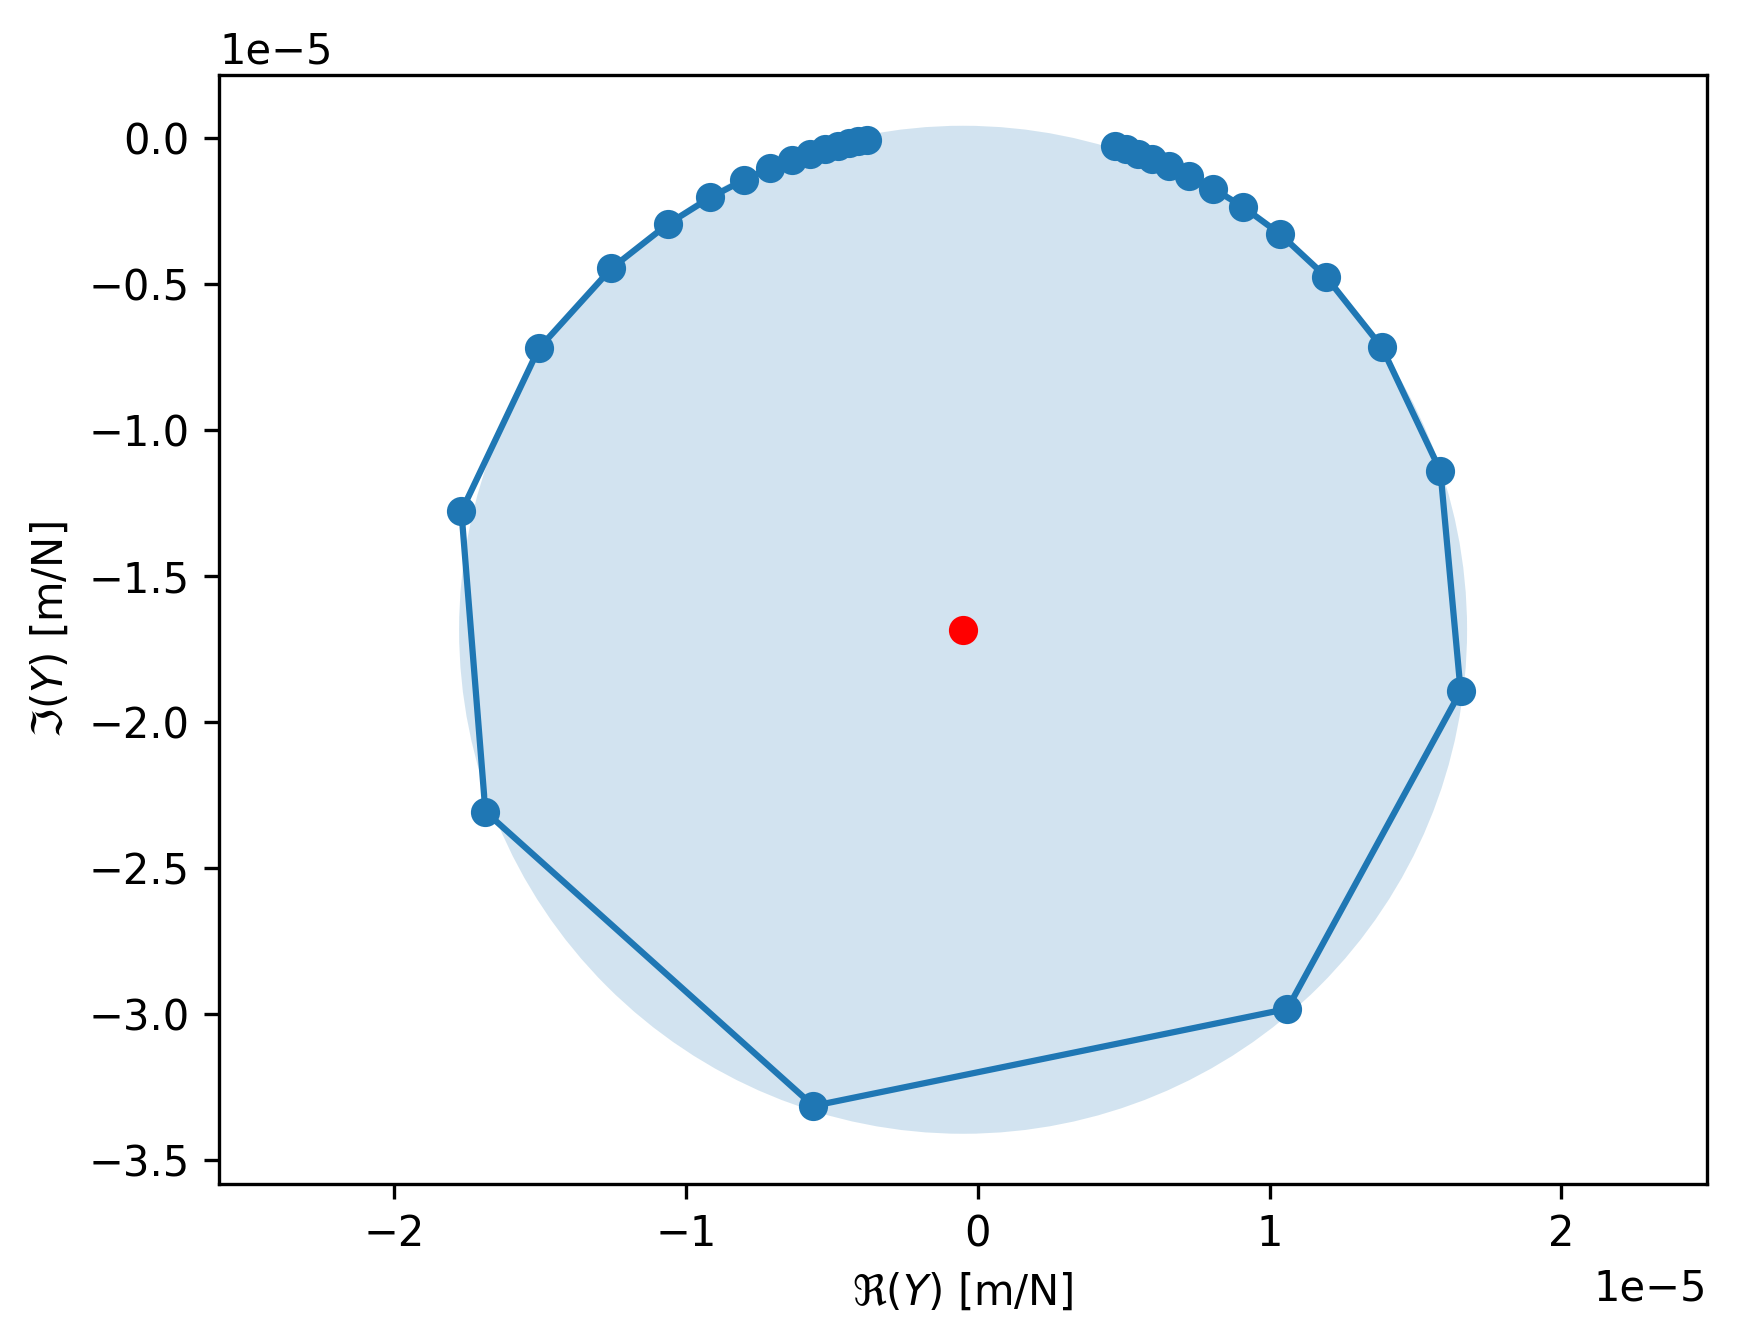

In [34]:
fig, ax = plt.subplots(dpi=300)
plt.plot(np.real(Y2[slice(*fr_range)]), np.imag(Y2[slice(*fr_range)]), 'o-')
plt.plot(x0, y0, 'o', color='red')
circle = plt.Circle((x0, y0), R0, alpha=0.2)
ax.add_patch(circle)
plt.ylabel(r'$\Im$($Y$) [m/N]')
plt.xlabel(r'$\Re$($Y$) [m/N]');
plt.axis('equal');

### Določitev lastne frekvence

Sedaj določimo kje se nahaja lastna frekvenca na našem frekvenčnem intervalu. Najprej izračunamo kot med dvema sosednjima točkama na Nyquistovem krogu z izhodiščem v središču krožnice. To nardimo tako da definiramo novo funkcijo kot_iz_treh_tock. 

In [35]:
def kot_iz_treh_tock(_x0, _y0, _x1, _y1, _x2, _y2):
    """
    Izračun parametrov kroga (izhodišče, radij)

    :param _xi, _yi: koordinate trikotnika
    :type _xi, _yi: float
    
    :return kot: kot trikotnika v točki (x0, y0) [rad]
    """
    d1 = math.hypot(_x1-_x0, _y1-_y0)
    d2 = math.hypot(_x2-_x0, _y2-_y0)
    d3 = math.hypot(_x2-_x1, _y2-_y1)
    phi_ = np.arccos((d1**2+d2**2-d3**2)/(2*d1*d2))
    return phi_

In [36]:
d_theta_a = [] #pripravimo prazna lista
d_theta_b = []

for k in range(1, len(xi)-1):
    d_theta_1 = kot_iz_treh_tock(x0, y0, xi[k + 1], yi[k + 1], xi[k],yi[k])
    d_theta_2 = kot_iz_treh_tock(x0, y0, xi[k], yi[k], xi[k - 1], yi[k- 1])
    d_theta_a.append(d_theta_1)
    d_theta_b.append(d_theta_2)
    
d_theta_a = np.asarray(d_theta_a)
d_theta_b = np.asarray(d_theta_b)

Sedaj določimo točko lastne frekvence v našem izbranem frekvenčnem območju. Ta se nahaja tam, kjer je vsota kotov d_theta_a in d_theta_b največja. 

In [37]:
ind = np.argmax(d_theta_a+d_theta_b)+1 #določitev max kota
f1 = freq[slice(*fr_range)][ind] #tu določimo točko lastne frekvence
omega_1 = 2*np.pi*f1 #omega izračunana po enačbi omega=2*pi*freq.
#omego_1 uporabimo kasneje pri razmerniku dušenja
f1

254.0

254.0

Na grafu prikažemo našo določeno lastno frekvenco s vertikalno rdečo črto.

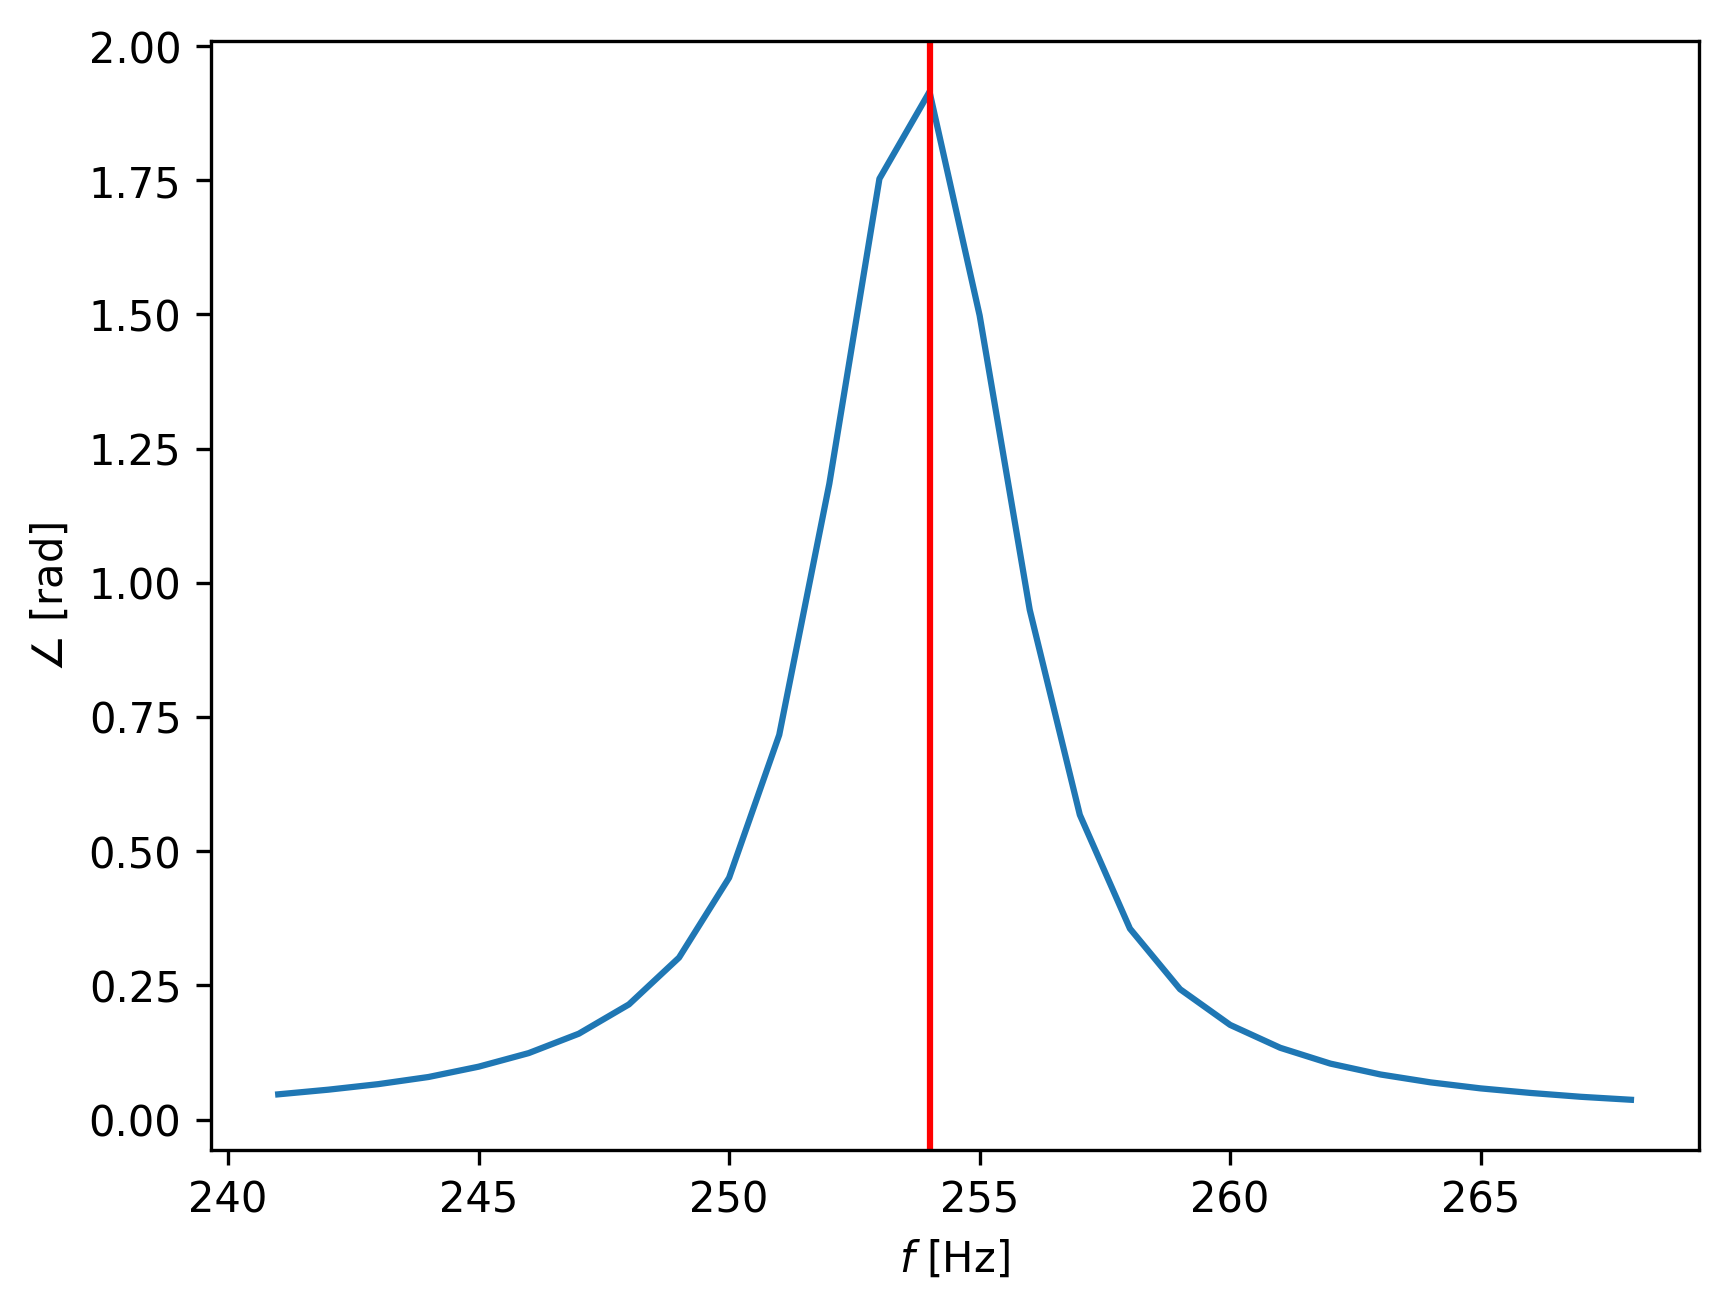

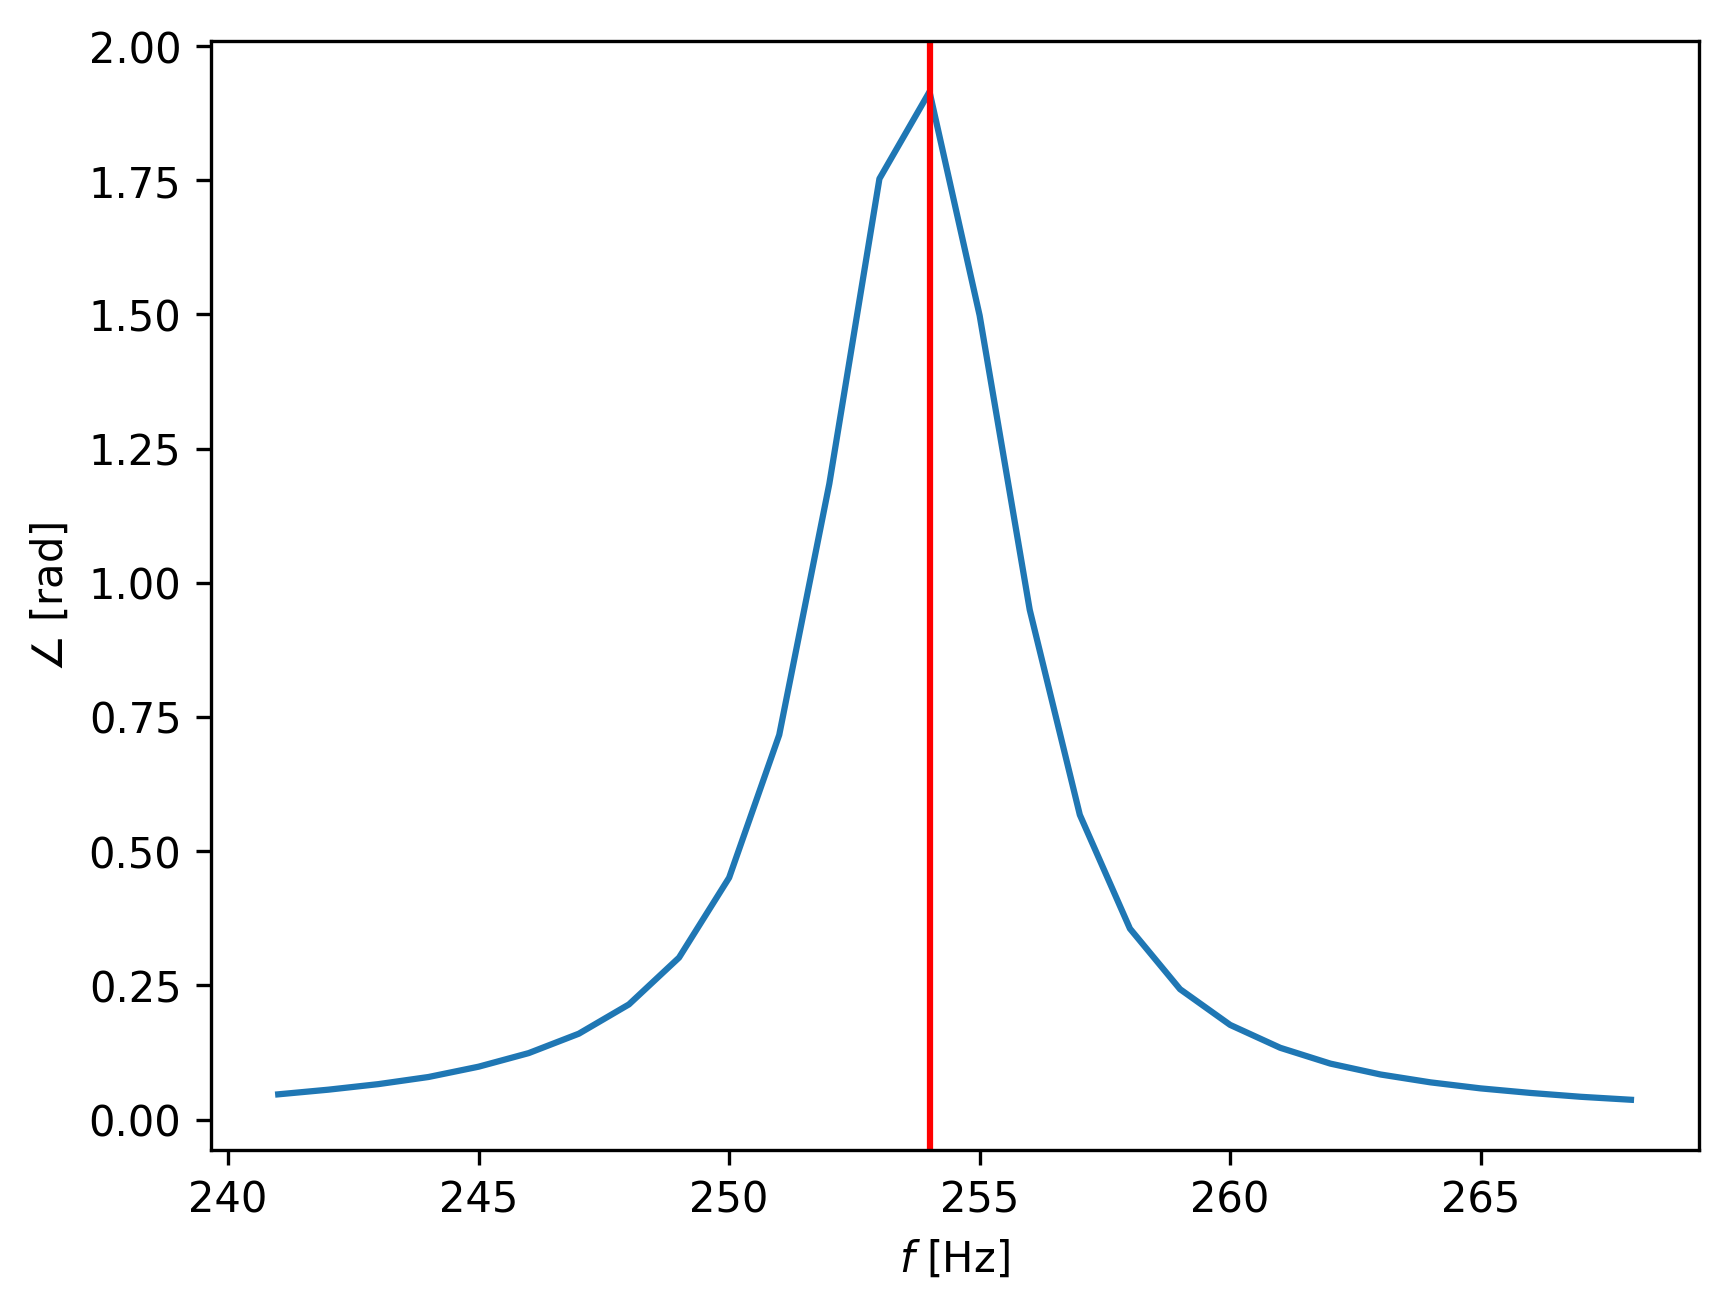

In [38]:
plt.subplots(dpi=300)
plt.plot(freq[slice(*fr_range)][1:-1], d_theta_a+d_theta_b)
plt.axvline(x=freq[slice(*fr_range)][ind], color='red')
plt.xlabel(r'$f$ [Hz]');
plt.ylabel(r'$\angle$ [rad]');

### Razmernik histereznega dušenja

Prej izračunana kota d_theta_a in d_theta_b uporabimo, da izračunamo razmernik histereznega dušenja.

In [39]:
damp1 = []
omega = 2*np.pi*freq

for t in range(1, 5, 1):
    omega_a = omega[slice(*fr_range)][ind+t]
    omega_b = omega[slice(*fr_range)][ind-t]
    theta_a = np.sum(d_theta_a[ind-t-1:ind-1])
    theta_b = np.sum(d_theta_a[ind-1:ind+t-1])
    damp1_ = (omega_a**2 - omega_b**2)/(omega_1**2) * 1/(np.tan(theta_a/2) + np.tan(theta_b/2))
    #uporabimo enačno izpeljano na predavanjih
    damp1.append(damp1_)

Prikažemo razmernik dušenja.

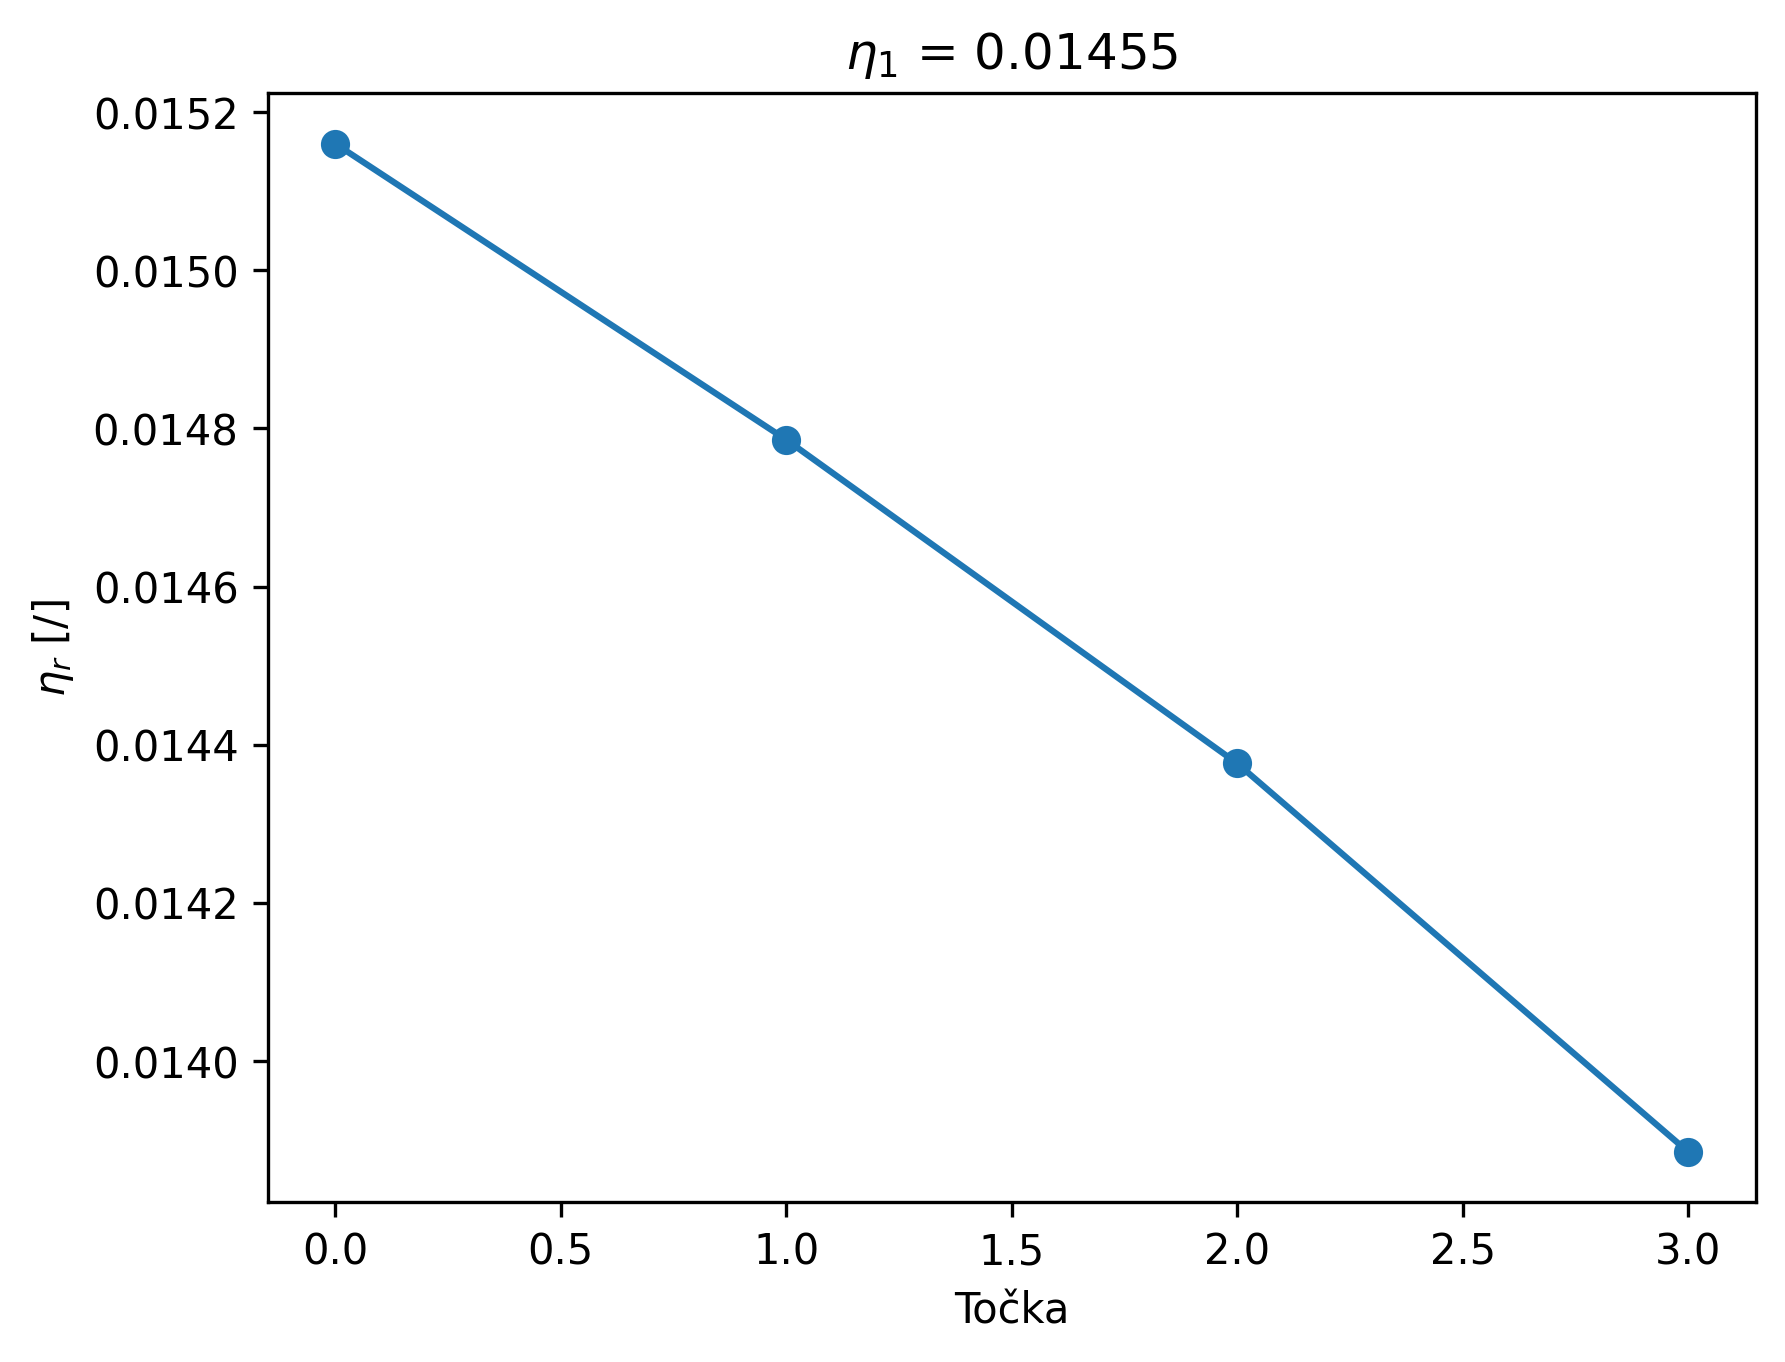

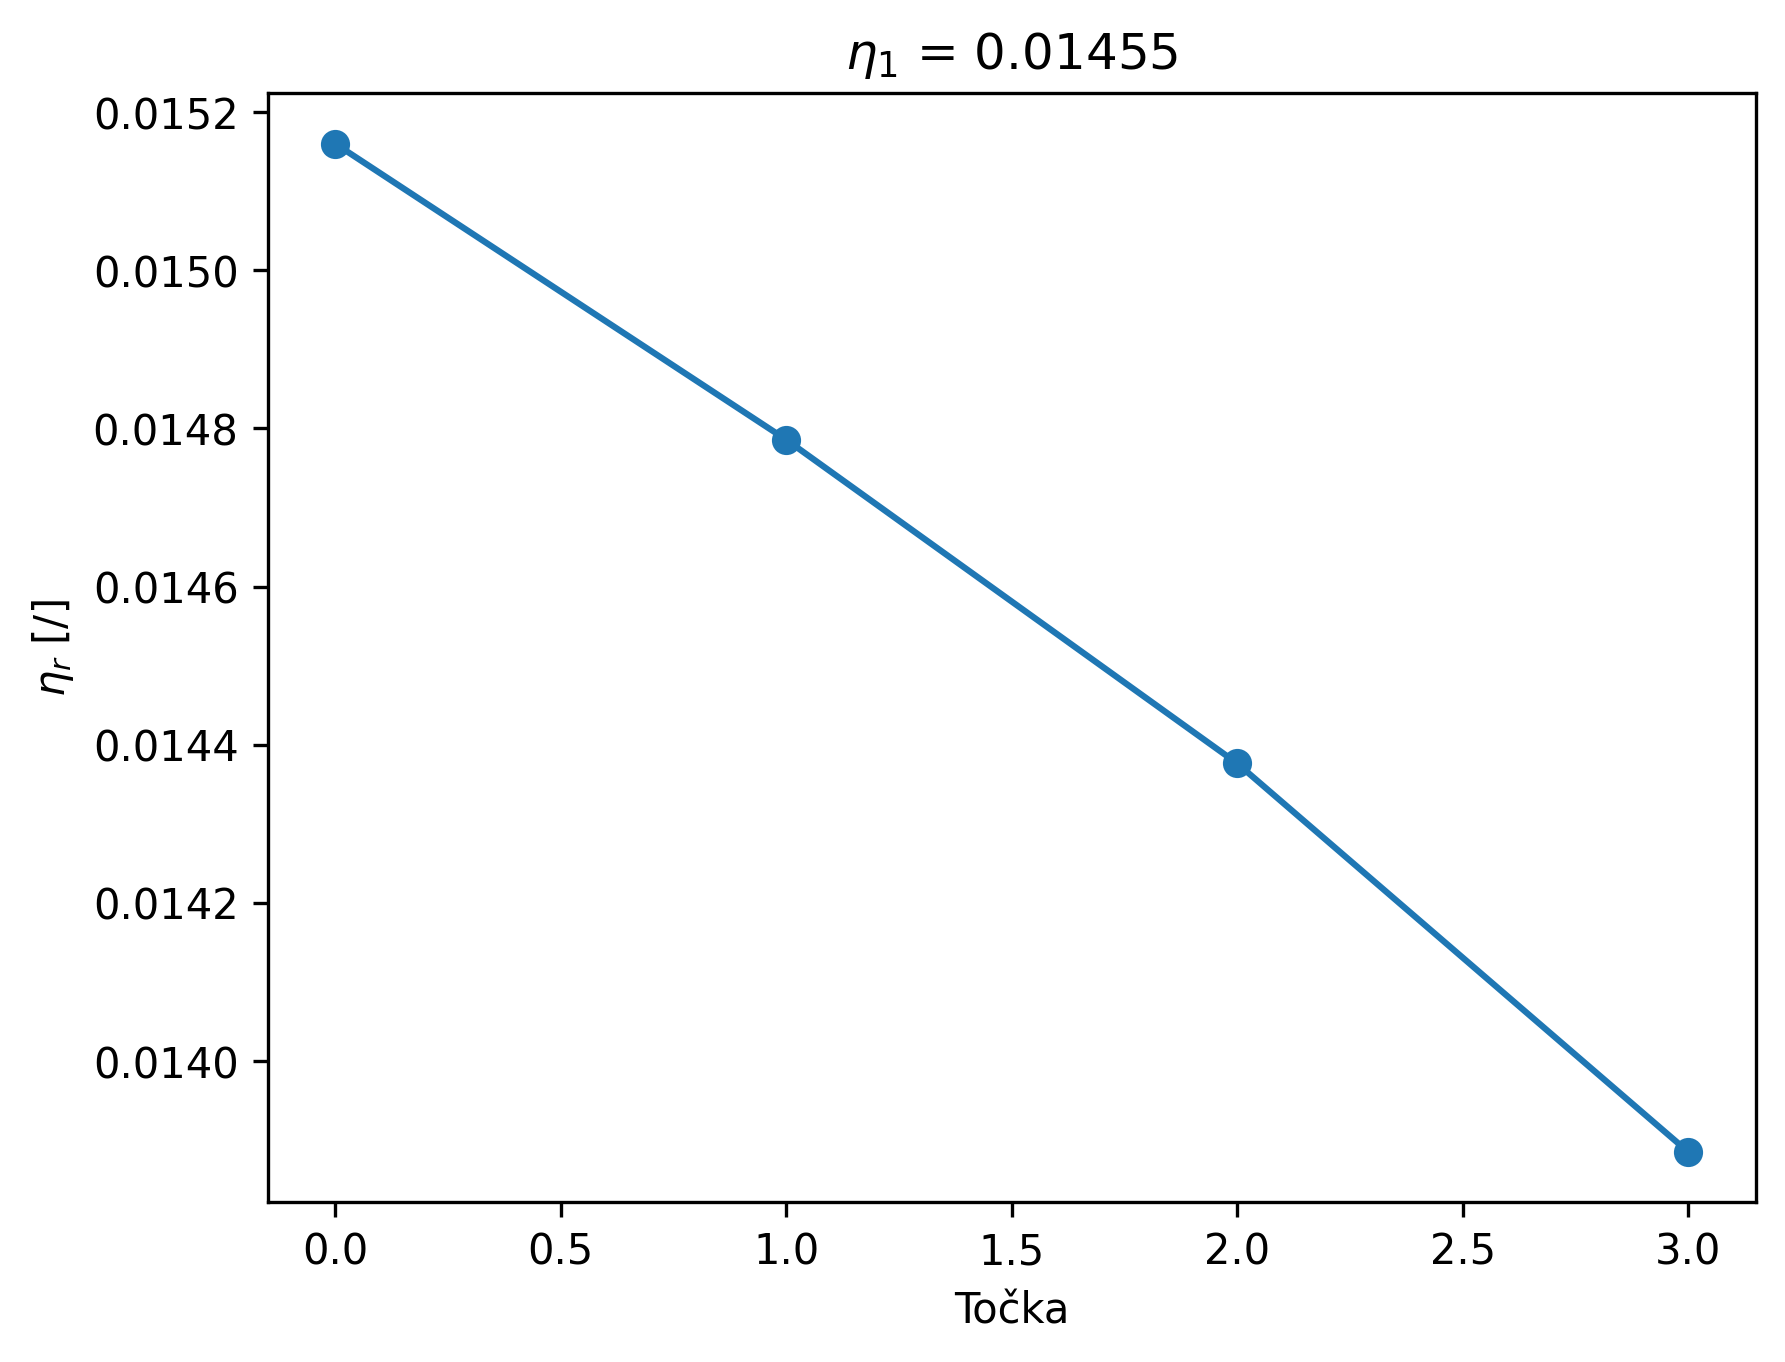

In [40]:
plt.subplots(dpi=300)
plt.plot(damp1, 'o-');
plt.ylabel(r'$\eta_r$ [/]');
plt.xlabel('Točka');
plt.title(r'$\eta_1$ = %.5f' %np.average(damp1));

Povprečni razmernik eta_r je enak

In [41]:
eta_r = np.average(damp1)
eta_r

0.014551836090987973

0.014551836090987973

### Izračun modalne konstante

Amplitudo modalne konstante izračunamo po sledeči enačbi.

In [42]:
A2_ = R0 * 2*(f1*2*np.pi) ** 2 * np.average(damp1) #enačba za amplitudo modalne konstante
phi = np.arctan2(-(x0 - xi[ind]), (y0 - yi[ind])) #enačba za fazni zamik
A2 = A2_ * np.exp(1j * phi)
A2

(1.2212679300276197-0.38388497579363506j)

(1.2212679300276197-0.38388497579363506j)

Določimo še resonančni omega omega_r ter nato izračunamo Admitančno matriko.

In [43]:
omega_r = 2 * np.pi * f1
Y_ij2 = A2 / (omega ** 2 - omega_r ** 2 + 1j * eta_r * omega_r ** 2)

Sedaj prikažemo na grafu našo osnovno admitančo matriko s modro ter našo izračunano admitančno matriko po metodi prilagajanja kroga s oranžno

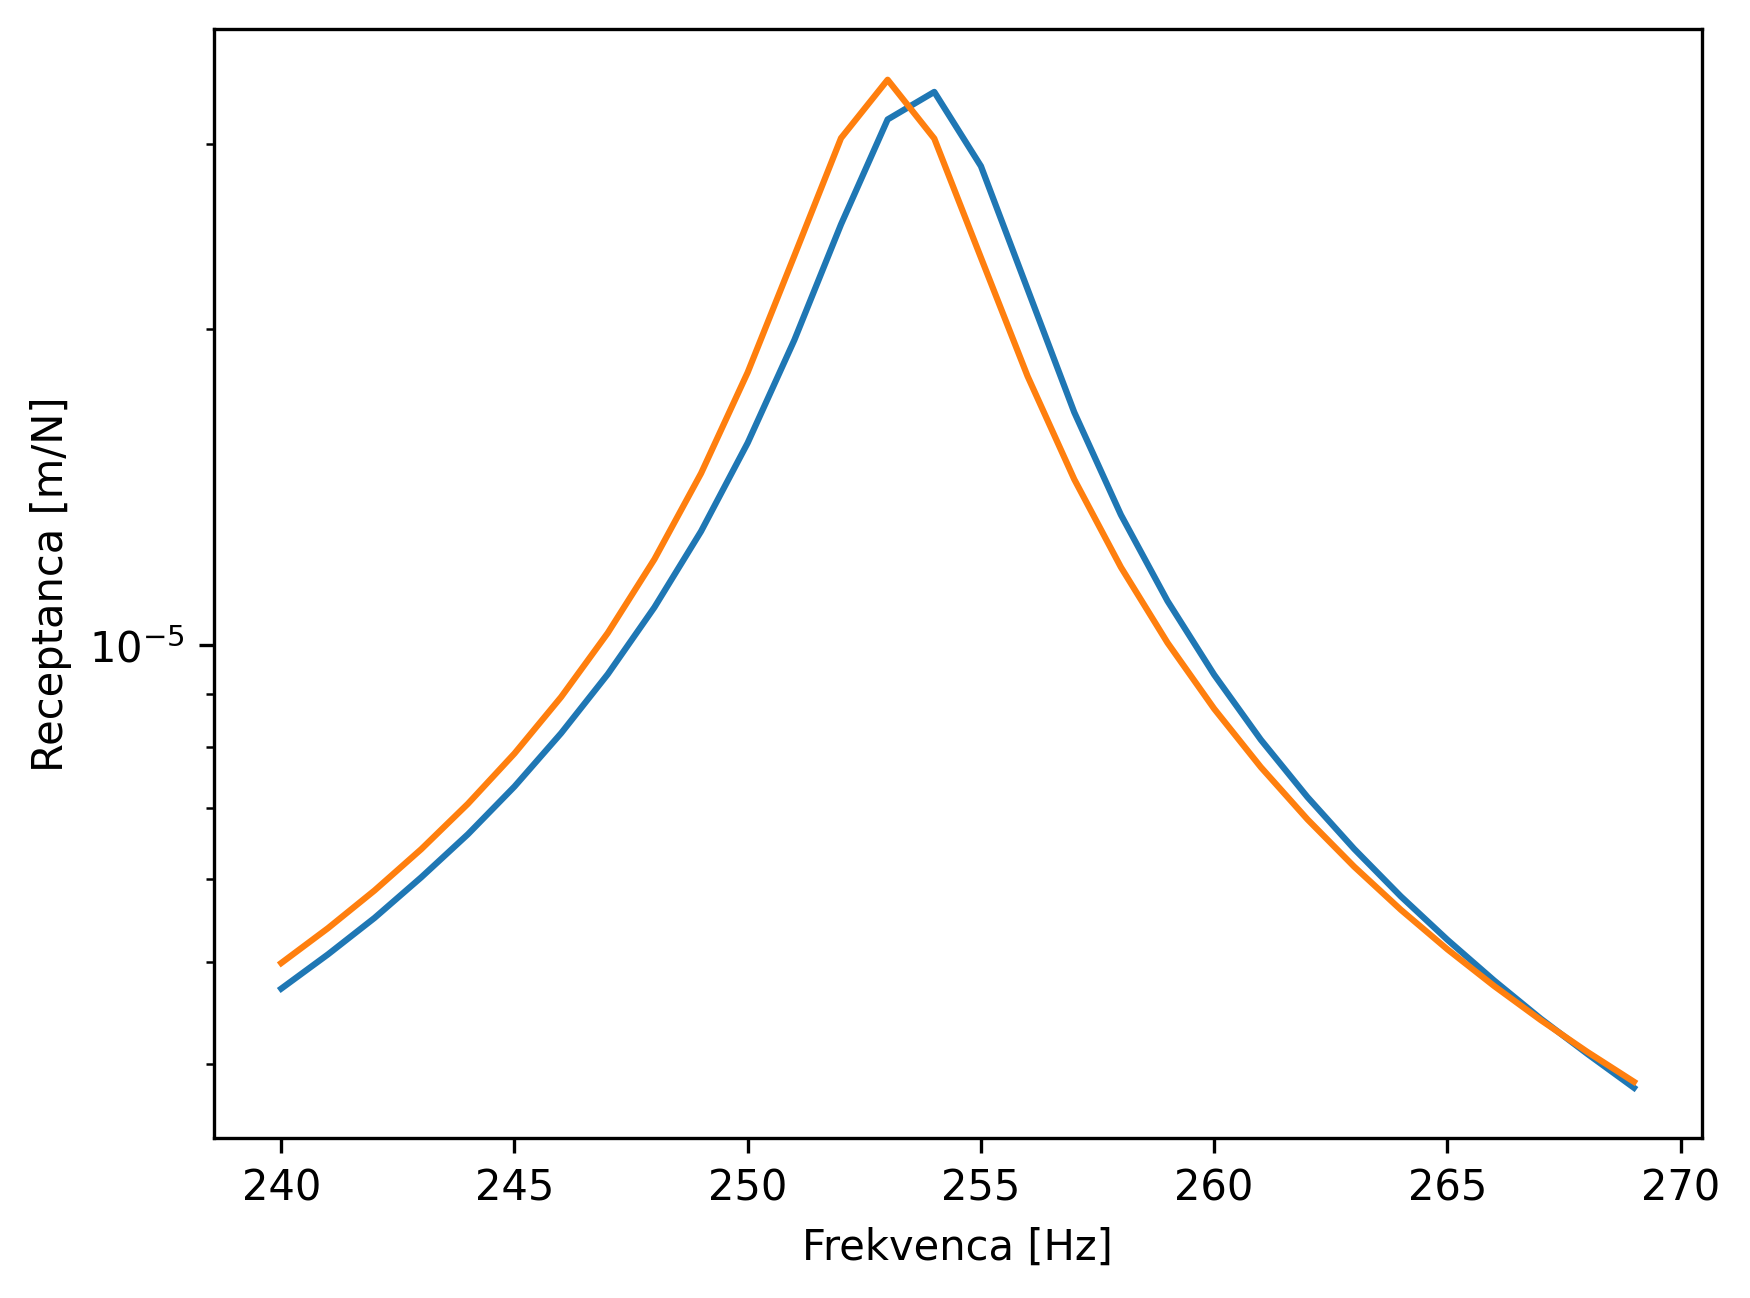

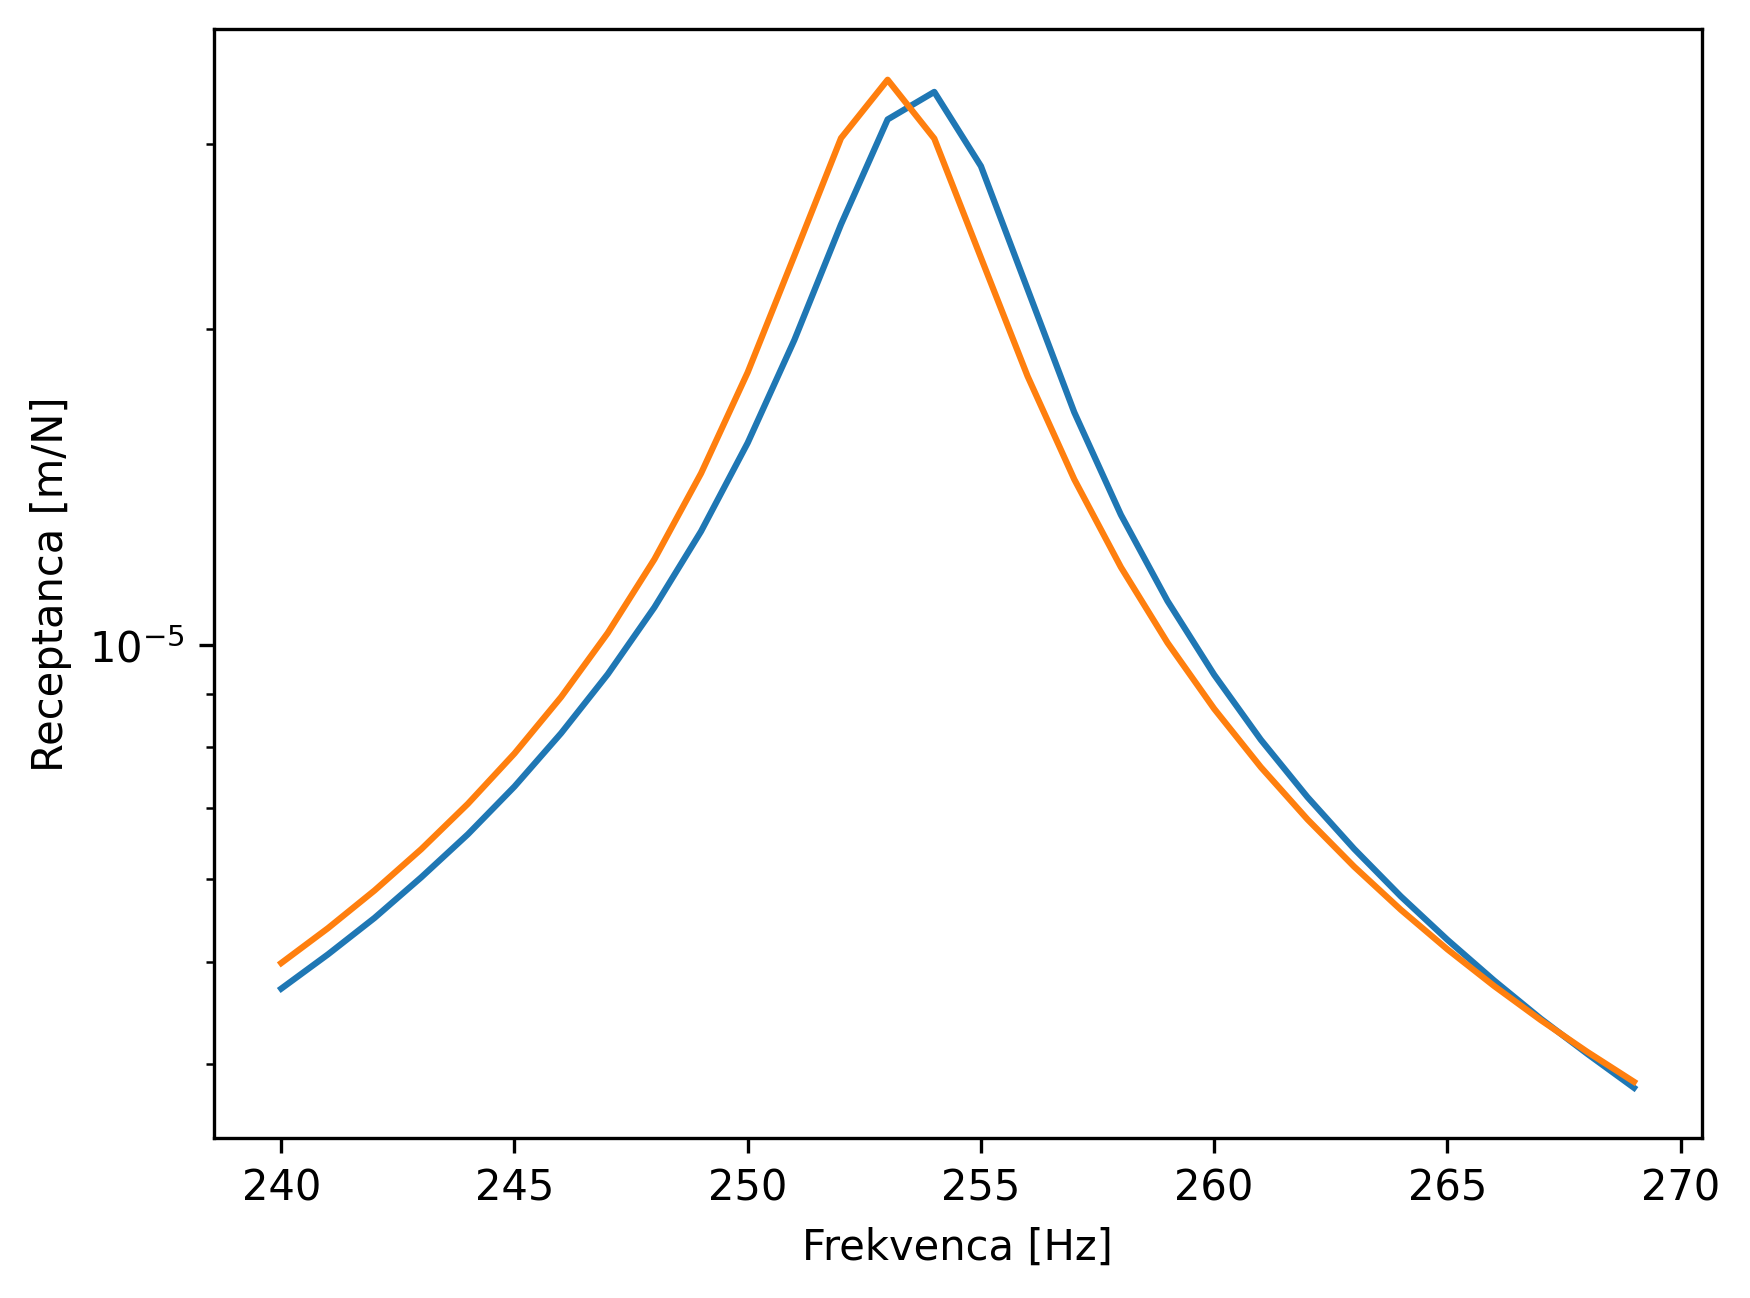

In [44]:
plt.subplots(dpi=300)
plt.semilogy(freq[slice(*fr_range)],np.abs(Y2[slice(*fr_range)]));
plt.semilogy(freq[slice(*fr_range)],np.abs(Y_ij2[1:][slice(*fr_range)]))
plt.xlabel('Frekvenca [Hz]');
plt.ylabel('Receptanca [m/N]');

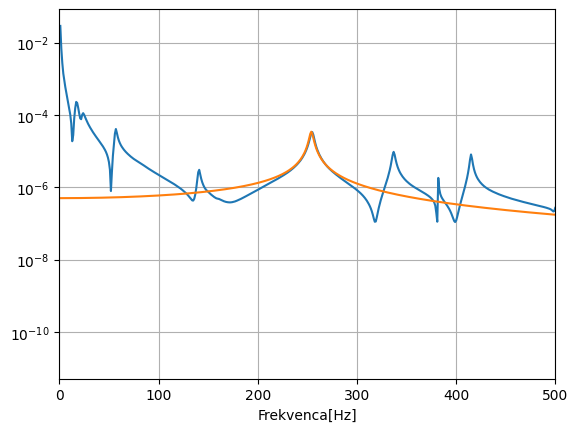

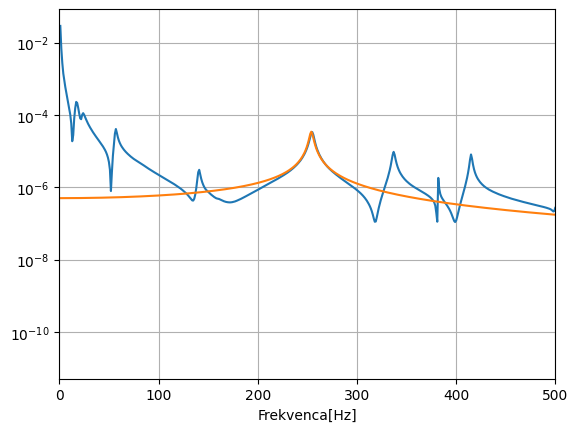

In [45]:
plt.semilogy(freq[1:],np.abs(Y2)); #logaritmski plot  admitance
plt.semilogy(freq[1:],np.abs(Y_ij2[1:])) #log plot izračunane admitance po metodi polovičnega kroga
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500)
plt.grid()


## Ewins-Glessonova metoda - vaja 7

Tule ne razumem kk je cenilke 2-dim medtem k FRF tri dim. A nebi mogla cenilka tut bit?!

In [46]:
#fig, ax = plt.subplots(3,3, figsize=(10,7))
#for #i in range(3):
#    for j in range(3):
#        ax[i][j].semilogy(np.abs(H[i:j,:]))
#        ax[i][j].set_title("i: " + str(i) + " j: " + str(j))
#
#plt.show()   

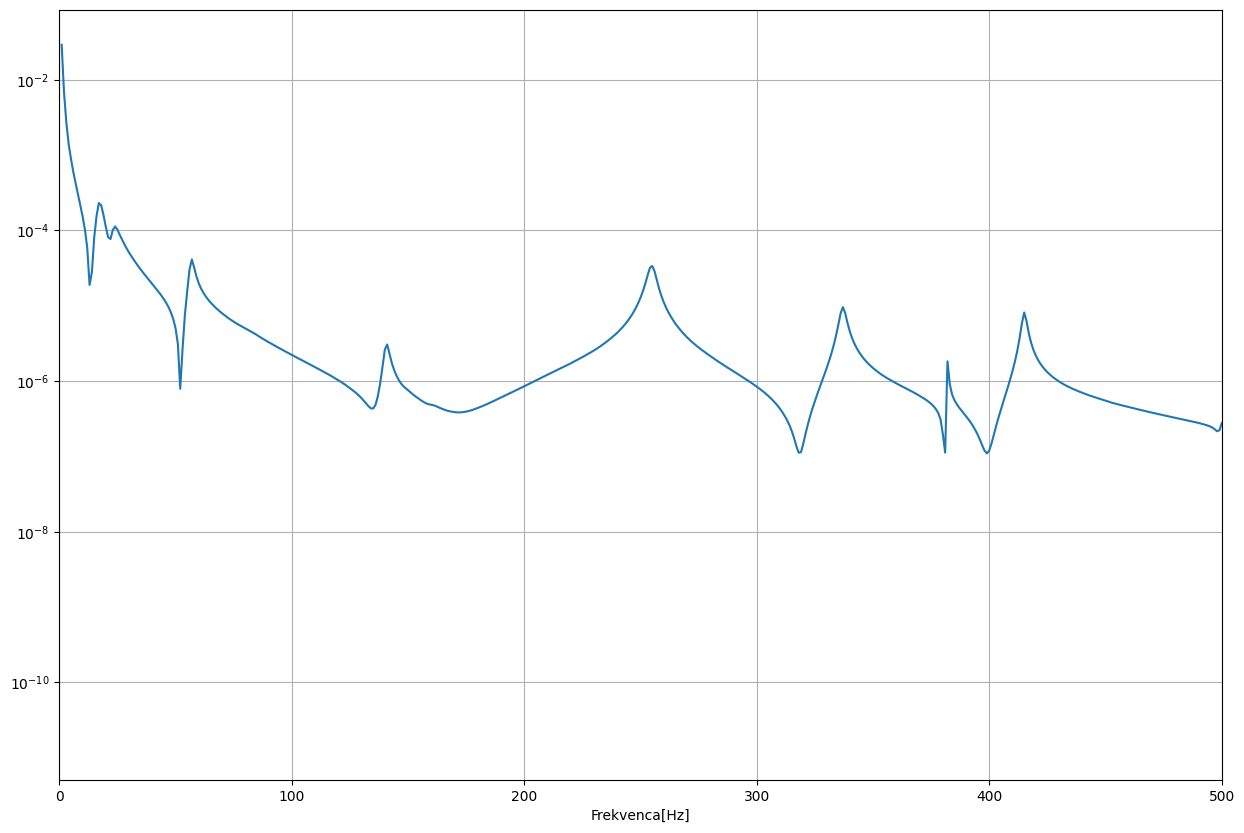

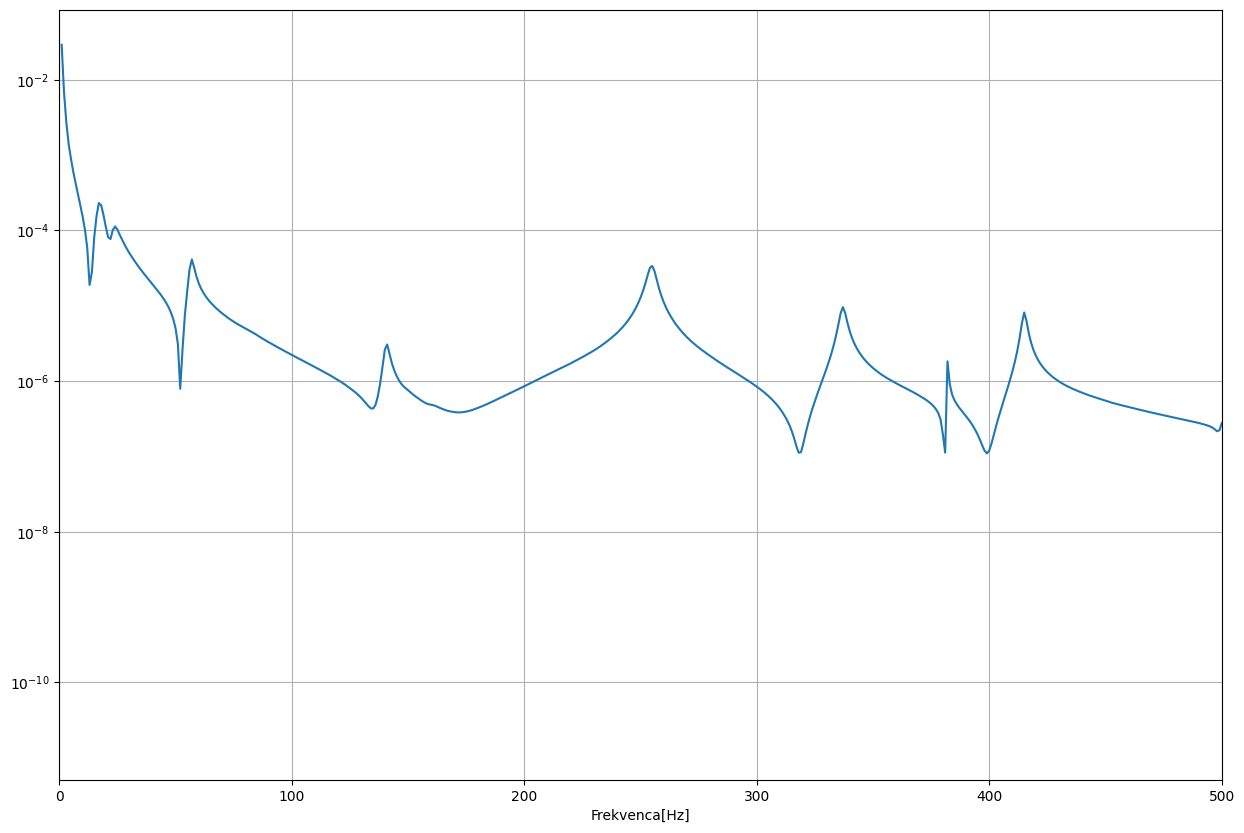

In [47]:
plt.figure(figsize=(15,10));
plt.semilogy(freq[1:],np.abs(H[7,1:])); #logaritmski plot 
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500)
plt.grid()

Uvozimo funkcijo iz scipy.signal database imenovano find_peaks. Ta nam že po imenu pove, da nam bo pomagala najti vrhove admitance oz resonačnne frekvence.

In [48]:
from scipy.signal import find_peaks

In [49]:
indexOffset = 5 #ne prve lastne frek
indexMaxOffset = 500 #gledamo do frekvence 500
wr_indeksi, _ = find_peaks(Y_abs[indexOffset:indexMaxOffset])
print(wr_indeksi)

[ 11  18  51 135 249 331 376 409]
[ 11  18  51 135 249 331 376 409]


Prikažemo in omejimo graf do frekvence 500

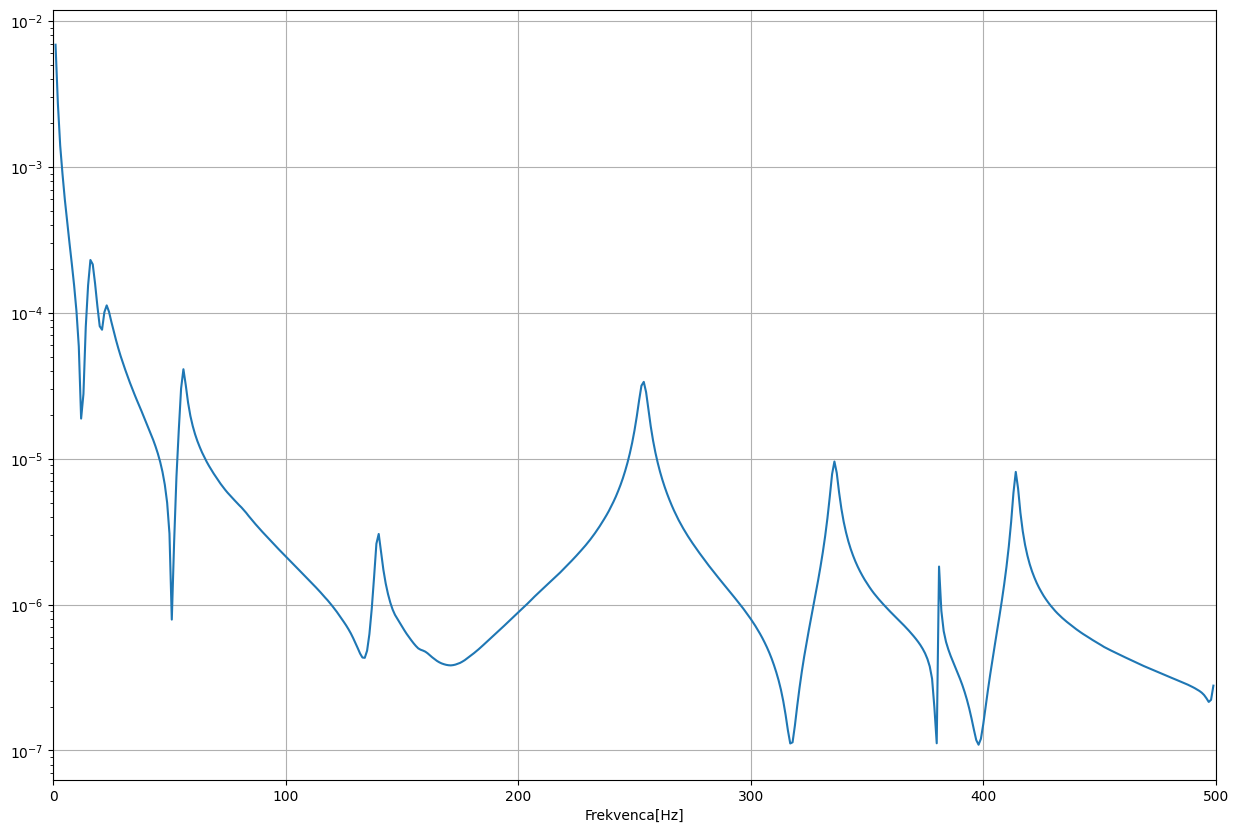

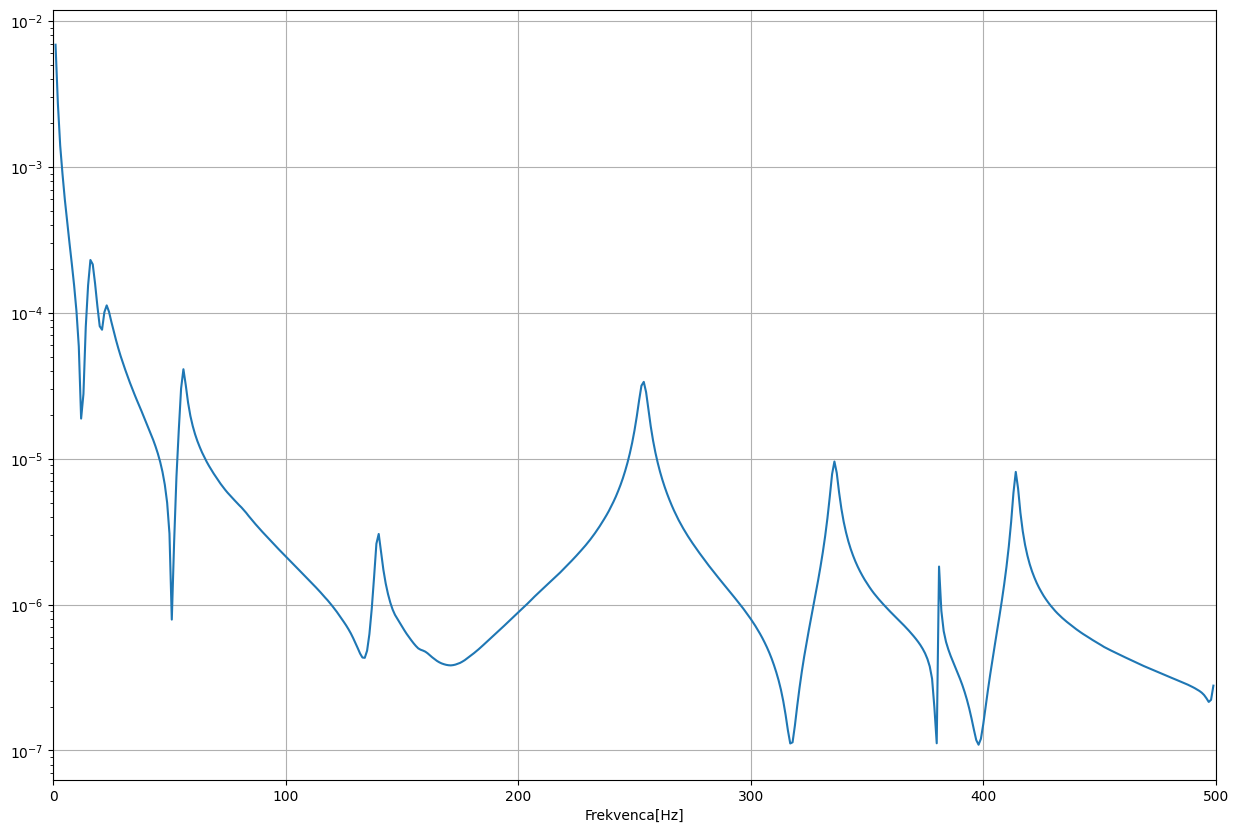

In [50]:
plt.figure(figsize=(15,10));
plt.semilogy(freq[1:500],Y_abs[1:500]); #logaritmski plot 
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500)
plt.grid()

Prikažemo resonančne vrhe ki jih je našla funkcija find peaks.

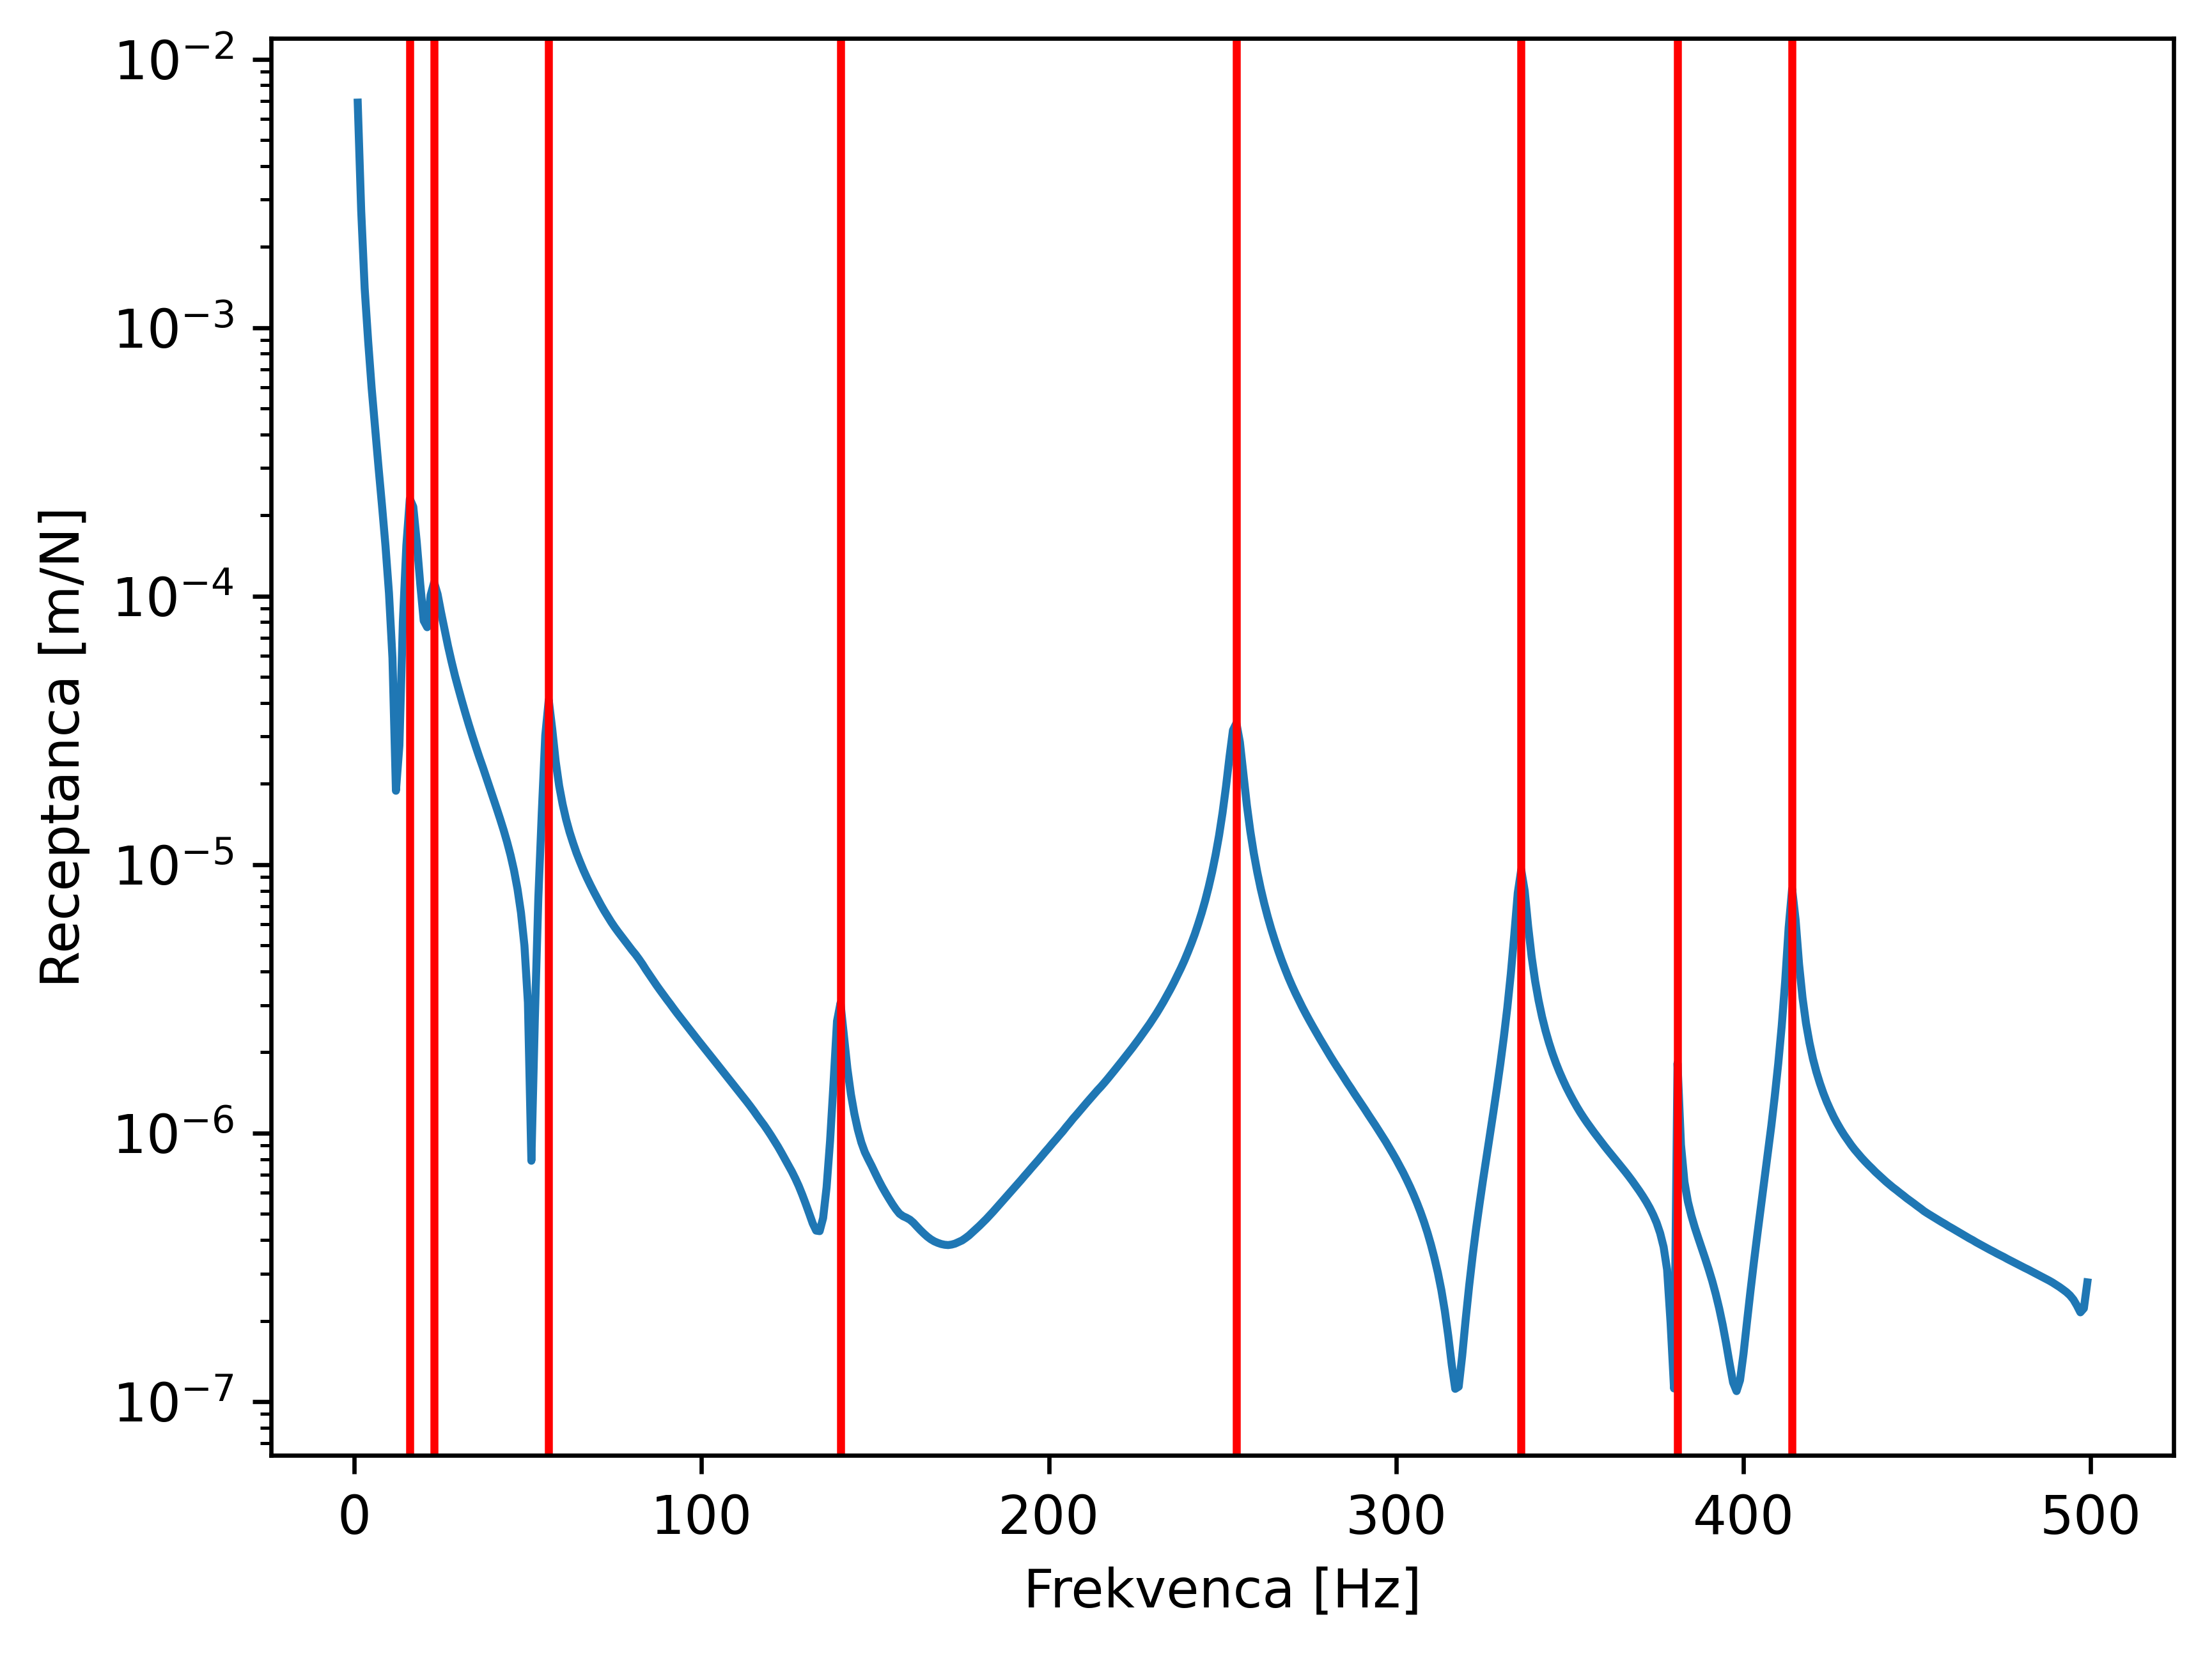

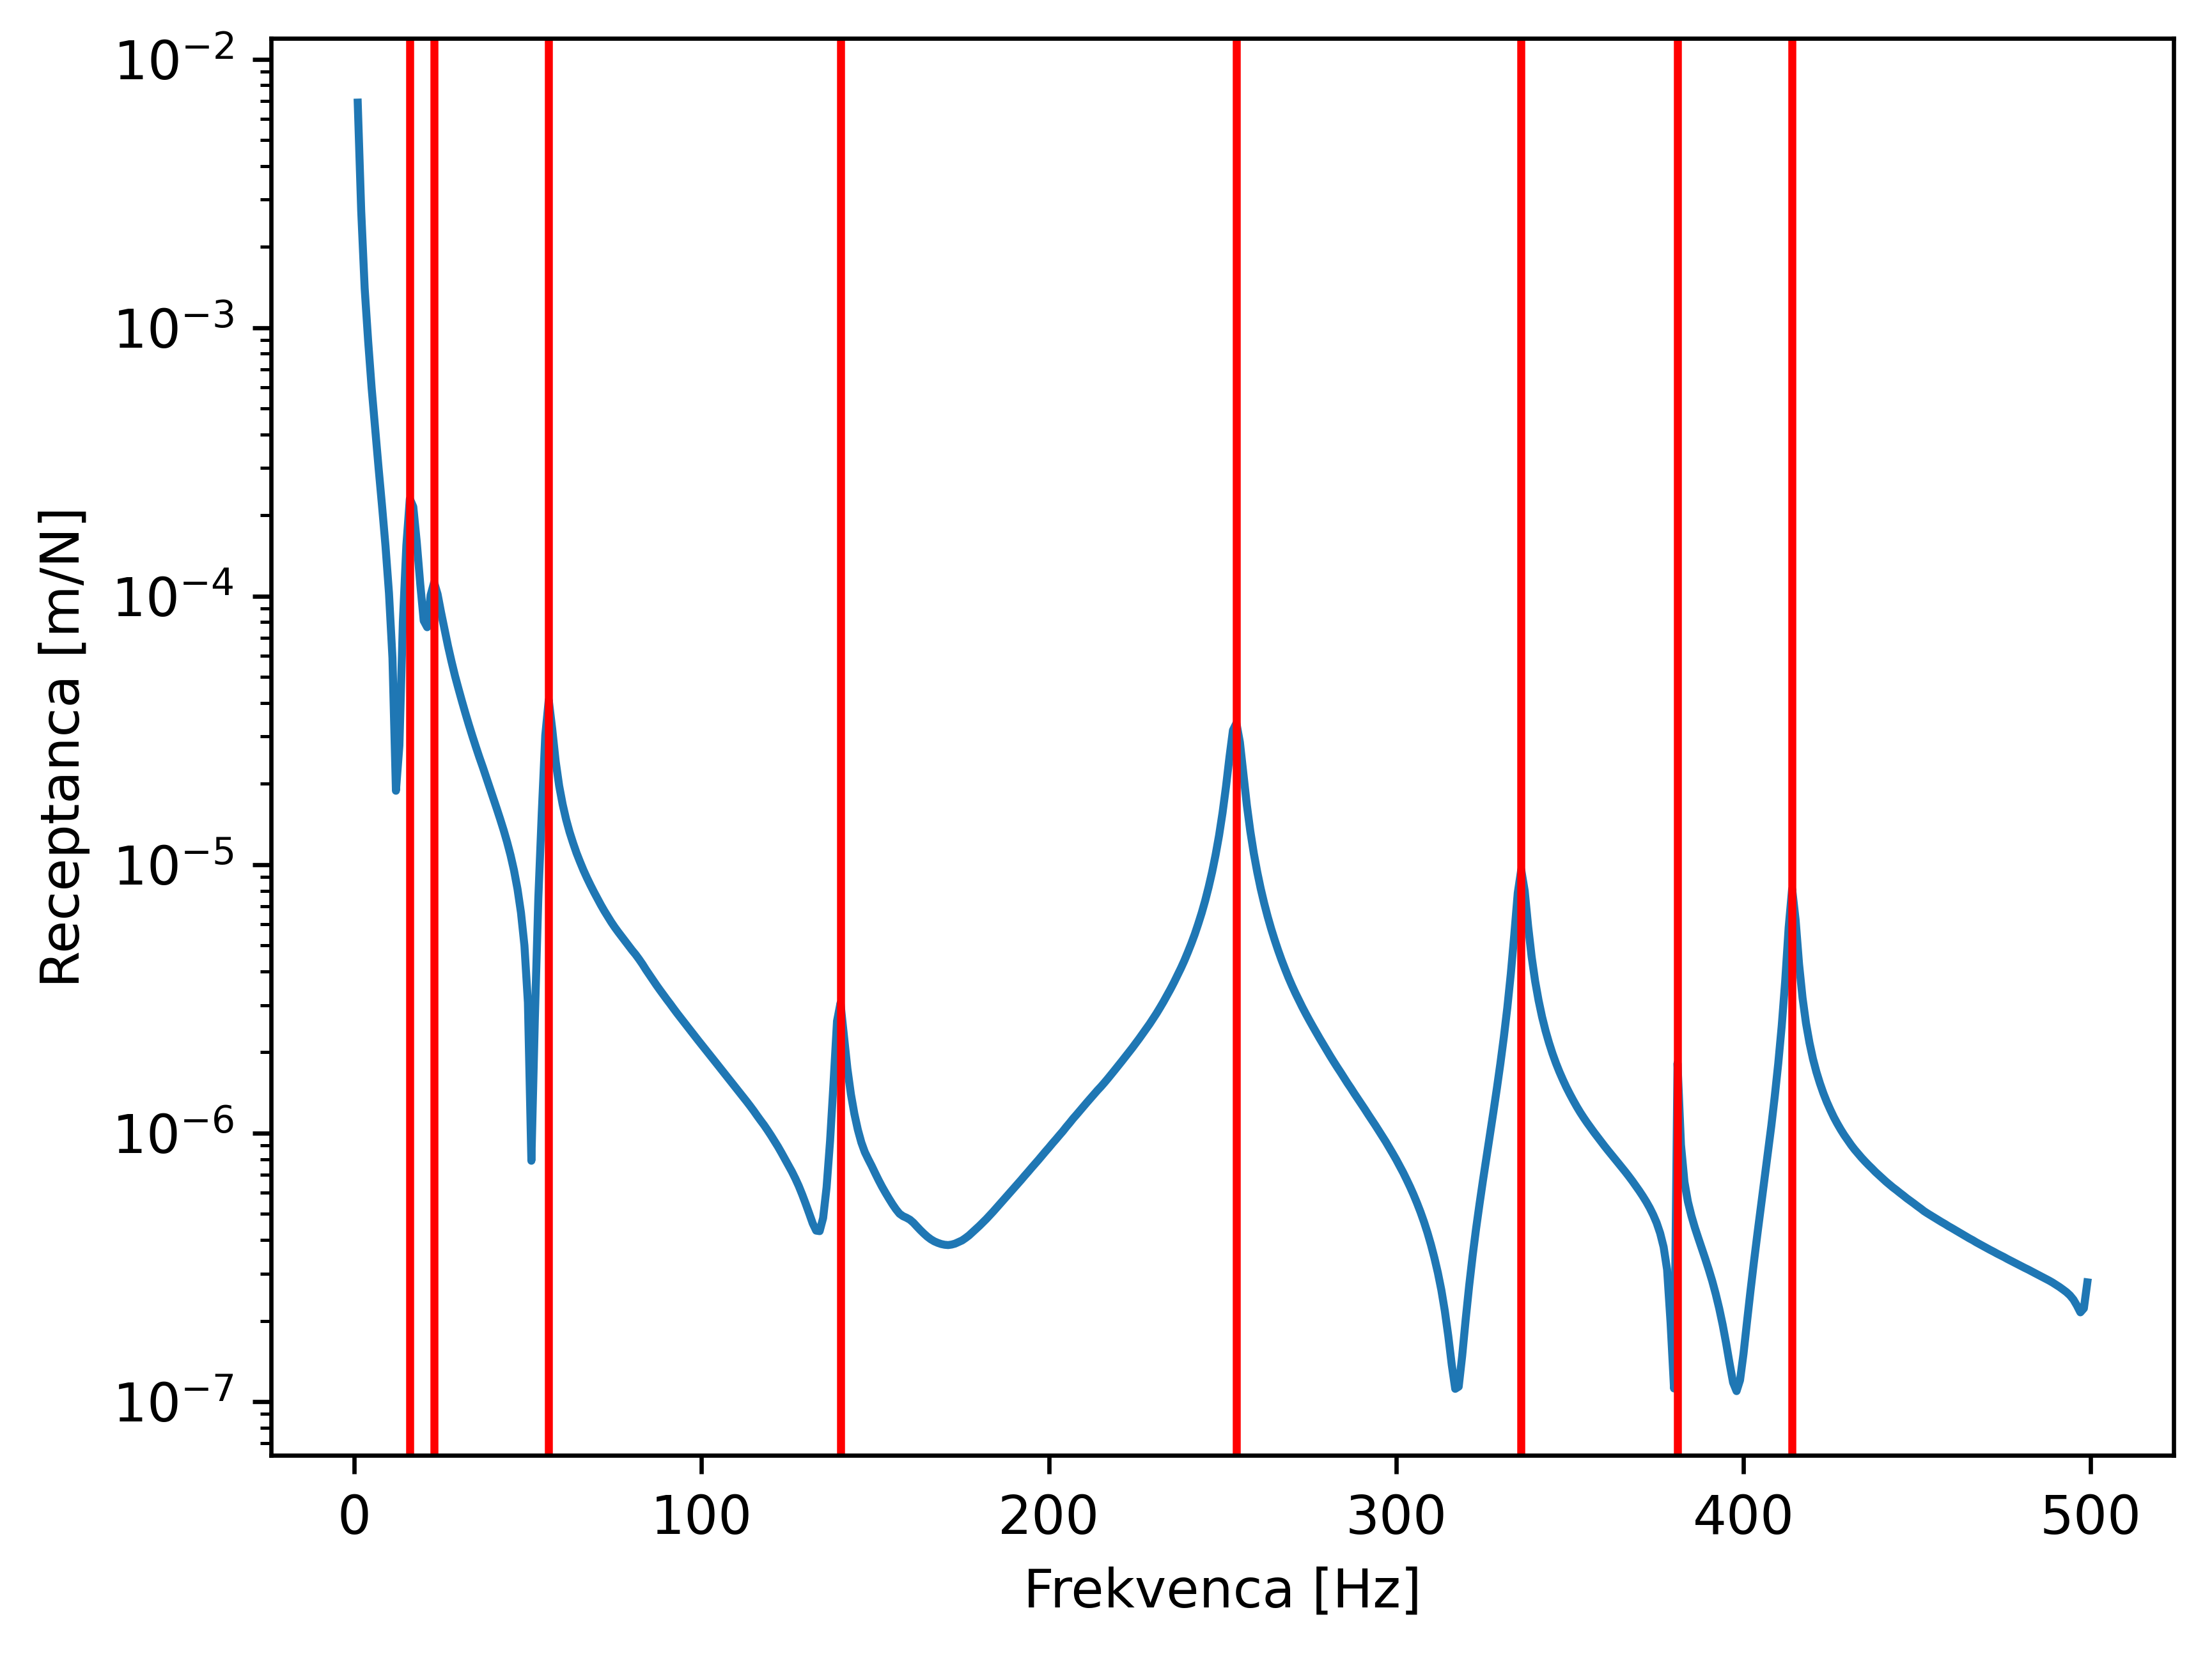

In [51]:
plt.subplots(dpi=600)
plt.semilogy(freq[1:500],Y_abs[1:500]);
plt.xlabel('Frekvenca [Hz]');
plt.ylabel('Receptanca [m/N]');

for wr in wr_indeksi:
    plt.axvline(x=freq[wr + indexOffset], color="r")

In [52]:
ind2 = find_peaks(Y_abs[:500])[0] #določi kje so resonančne frekvence oz vrhovi
fr = freq[ind2]
fr

array([ 16.,  23.,  56., 140., 254., 336., 381., 414.])

array([ 16.,  23.,  56., 140., 254., 336., 381., 414.])

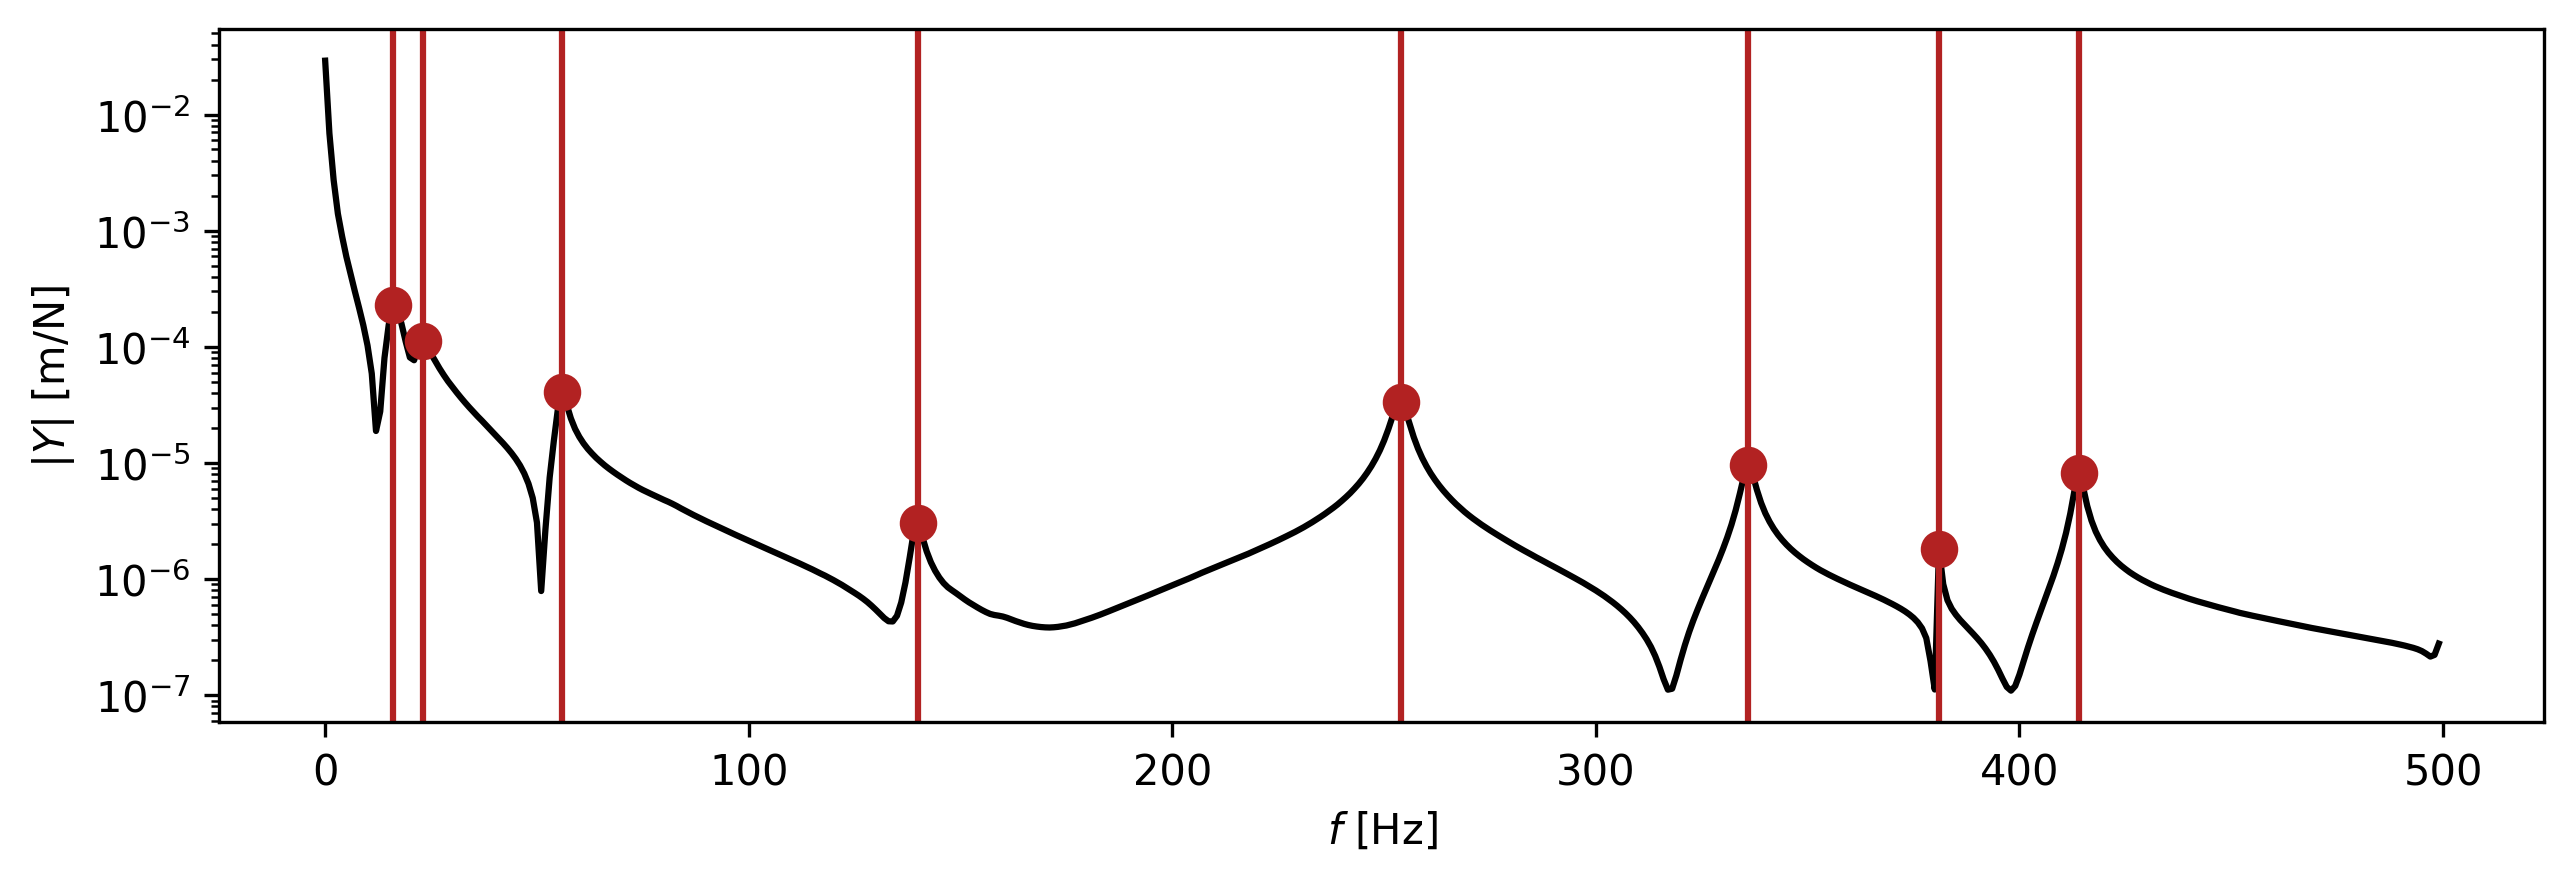

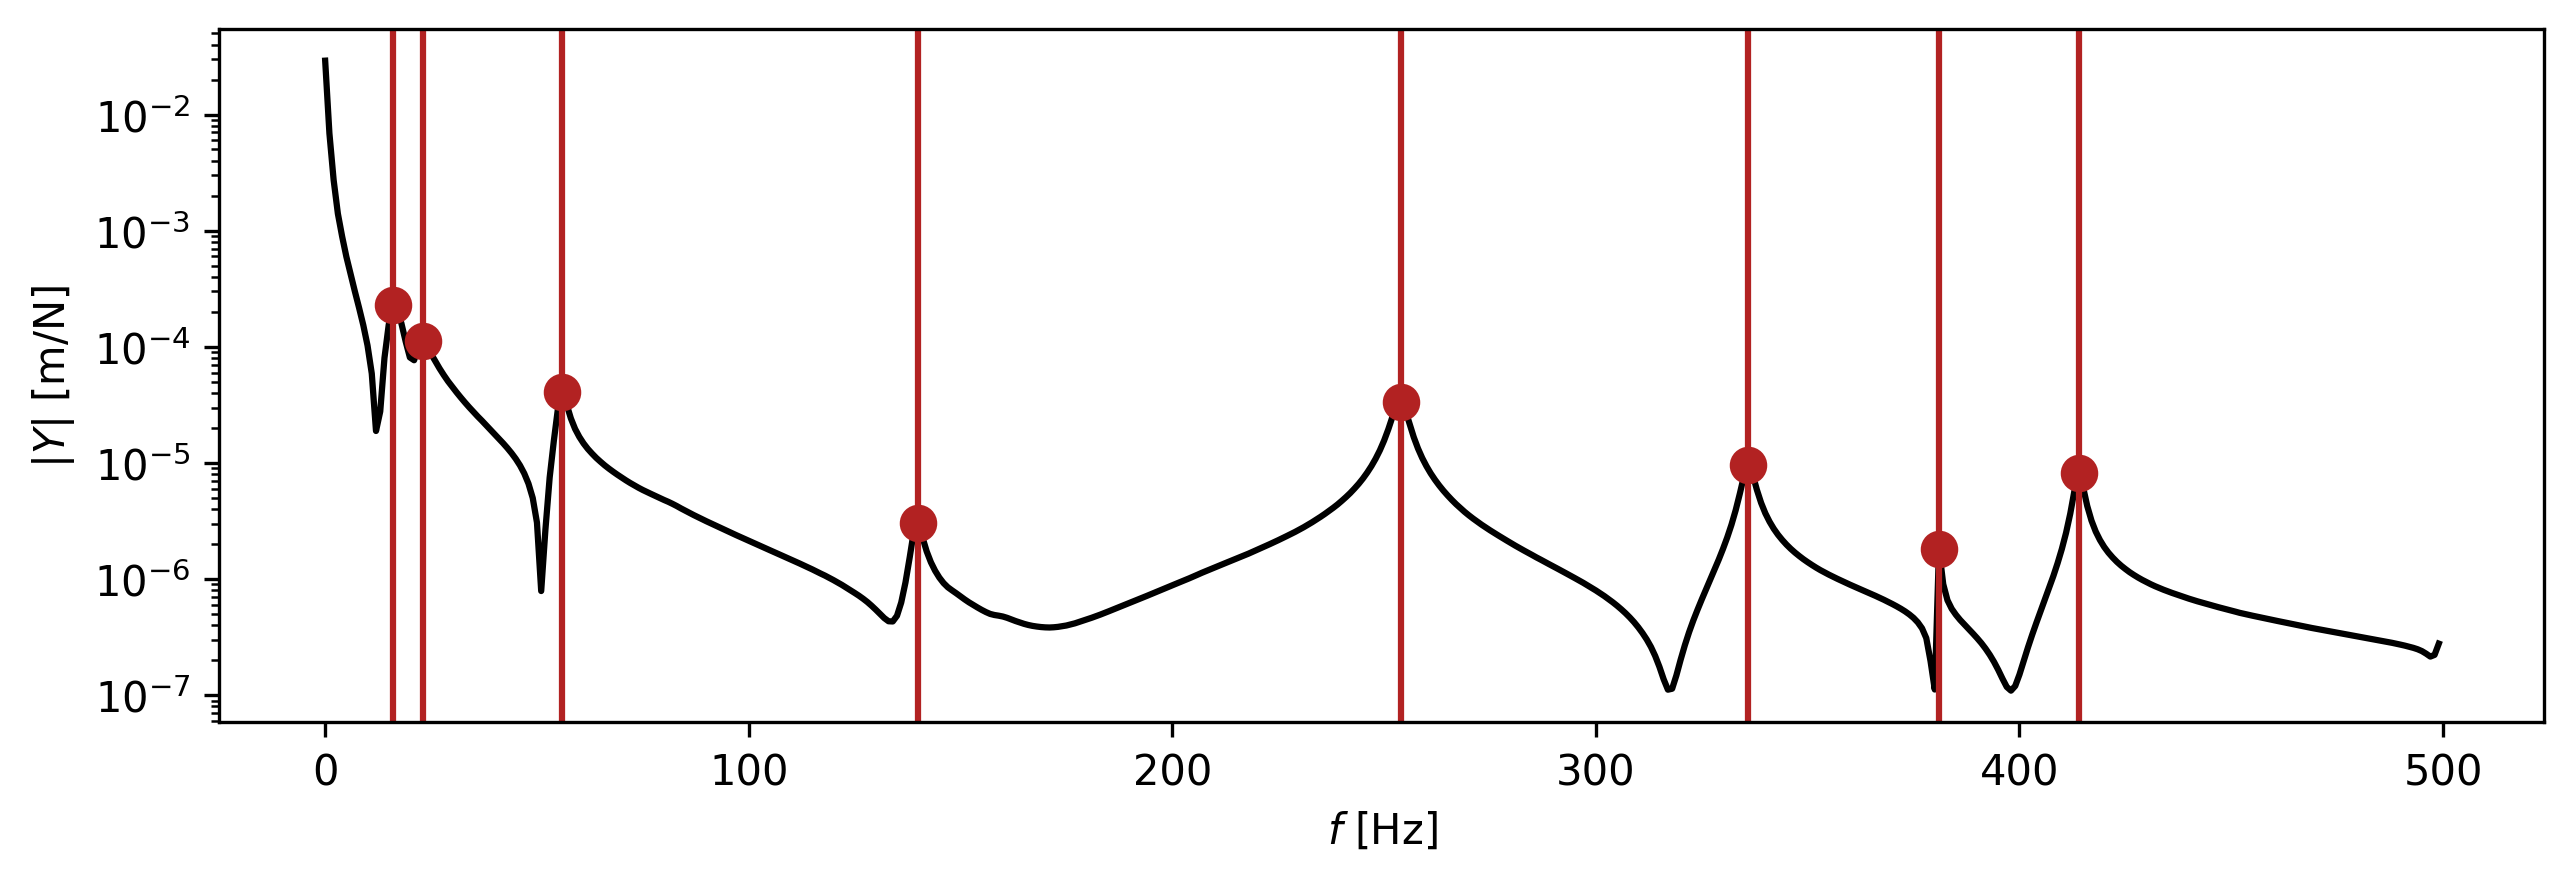

In [53]:
plt.subplots(figsize=(10,3), dpi=300)
plt.semilogy(freq[:500], Y_abs[:500], color='k')
plt.semilogy(fr, Y_abs[:500][ind2], 'o', color='firebrick', ms=8)
for _fr in fr:
    plt.axvline(_fr, color='firebrick')
plt.ylabel(r'$|Y|$ [m/N]');
plt.xlabel(r'$f$ [Hz]');

### Izračun modalnih konstant

Najprej za določene mesta resonanc izračunamo omego. Frekvenca kjer je resonanca je določena s spremenljivko ind2, zato le to pomnožimo s 2 in pi.

In [54]:
omega = 2*np.pi*freq
omega_eg_r = omega[ind2]
omega_eg_r

array([ 100.53096491,  144.51326207,  351.8583772 ,  879.64594301,
       1595.92906802, 2111.15026321, 2393.89360204, 2601.23871717])

array([ 100.53096491,  144.51326207,  351.8583772 ,  879.64594301,
       1595.92906802, 2111.15026321, 2393.89360204, 2601.23871717])

To vrednost sedaj pomnožimo s 1.05, saj ta  metoda upošteva območje 5% okoli mesta resonance.

In [67]:
Omega_eg_r_ind = ind2 * 1.05
Omega_eg_r_ind = Omega_r_ind.astype(int)
Omega_eg_r_ind
omega[Omega_r_ind]

array([ 100.53096491,  150.79644737,  364.42474782,  923.62824016,
       1671.32729171, 2211.68122813, 2513.27412287, 2726.90242332])

array([ 100.53096491,  150.79644737,  364.42474782,  923.62824016,
       1671.32729171, 2211.68122813, 2513.27412287, 2726.90242332])

Da pridobimo modalne konstante, izračunamo matriko R.

In [69]:
R_eg = np.zeros((ind2.shape[0], ind2.shape[0])) #matrika R. Same ničle.
#Matrika je velikosti naše spremelnjivke ind2, kjer so lastne frekvence.

for _i, omega_ri in enumerate(omega_eg_r):
    for _j, Omega_ri in enumerate(omega[Omega_eg_r_ind]):
        if _i > 0:  # Exclude the first column
            R_eg[_j, _i - 1] = 1 / (omega_ri ** 2 - Omega_ri ** 2)
            
#Pri tej metodi je Y sestavljen le iz realnega dela admitance Y.    
Y_ = np.asarray(np.real(Y2[Omega_eg_r_ind]))

Na koncu še rešimo sistem enačb ter pridobimo matriko modalnih konstant.

In [90]:
A_eg1 = np.linalg.solve(R_eg, Y_)

LinAlgError: Singular matrix

LinAlgError: Singular matrix

In [91]:
A_eg, _, _, _ = np.linalg.lstsq(R_eg, Y_, rcond=None)

In [92]:
A_eg

array([ 0.17201945,  0.15416814, -0.45170379, -0.6000077 , -3.48895599,
       -4.60898924, -3.10346883,  0.        ])

array([ 0.17201945,  0.15416814, -0.45170379, -0.6000077 , -3.48895599,
       -4.60898924, -3.10346883,  0.        ])

### Izračun razmernika histereznega dušenja

Za izračun razmeznika dušenja delimo pridobljeno admitančno matriko s absolutno vrednostjo admitance ter kvadrata lastnih frekvenc.

In [88]:
damp_eg_r = np.abs(A_eg) / (Y_abs[ind2] * np.asarray(omega_eg_r) ** 2)
damp_eg_r

array([0.07387965, 0.06562273, 0.08884609, 0.25424281, 0.04072827,
       0.10804853, 0.29705976, 0.        ])

array([0.07387965, 0.06562273, 0.08884609, 0.25424281, 0.04072827,
       0.10804853, 0.29705976, 0.        ])

In [114]:
Ar = []
dampr = []

for i in range(H.shape[0]):
    
    # pripravimo vektor Y
    Y_ = np.asarray(np.real(Y2[Omega_r_ind]))
    
    # rešimo sistem
    A_eg, _, _, _ = np.linalg.lstsq(R_eg, Y_, rcond=None)
    
    eta_r = np.abs(A) / (np.abs(Y2[ind2]) * np.asarray(omega_eg_r) ** 2)
    Ar.append(A)
    dampr.append(eta_r)
    
Ar = np.asarray(Ar)
dampr = np.asarray(dampr)

# well tule je neki narobe :)

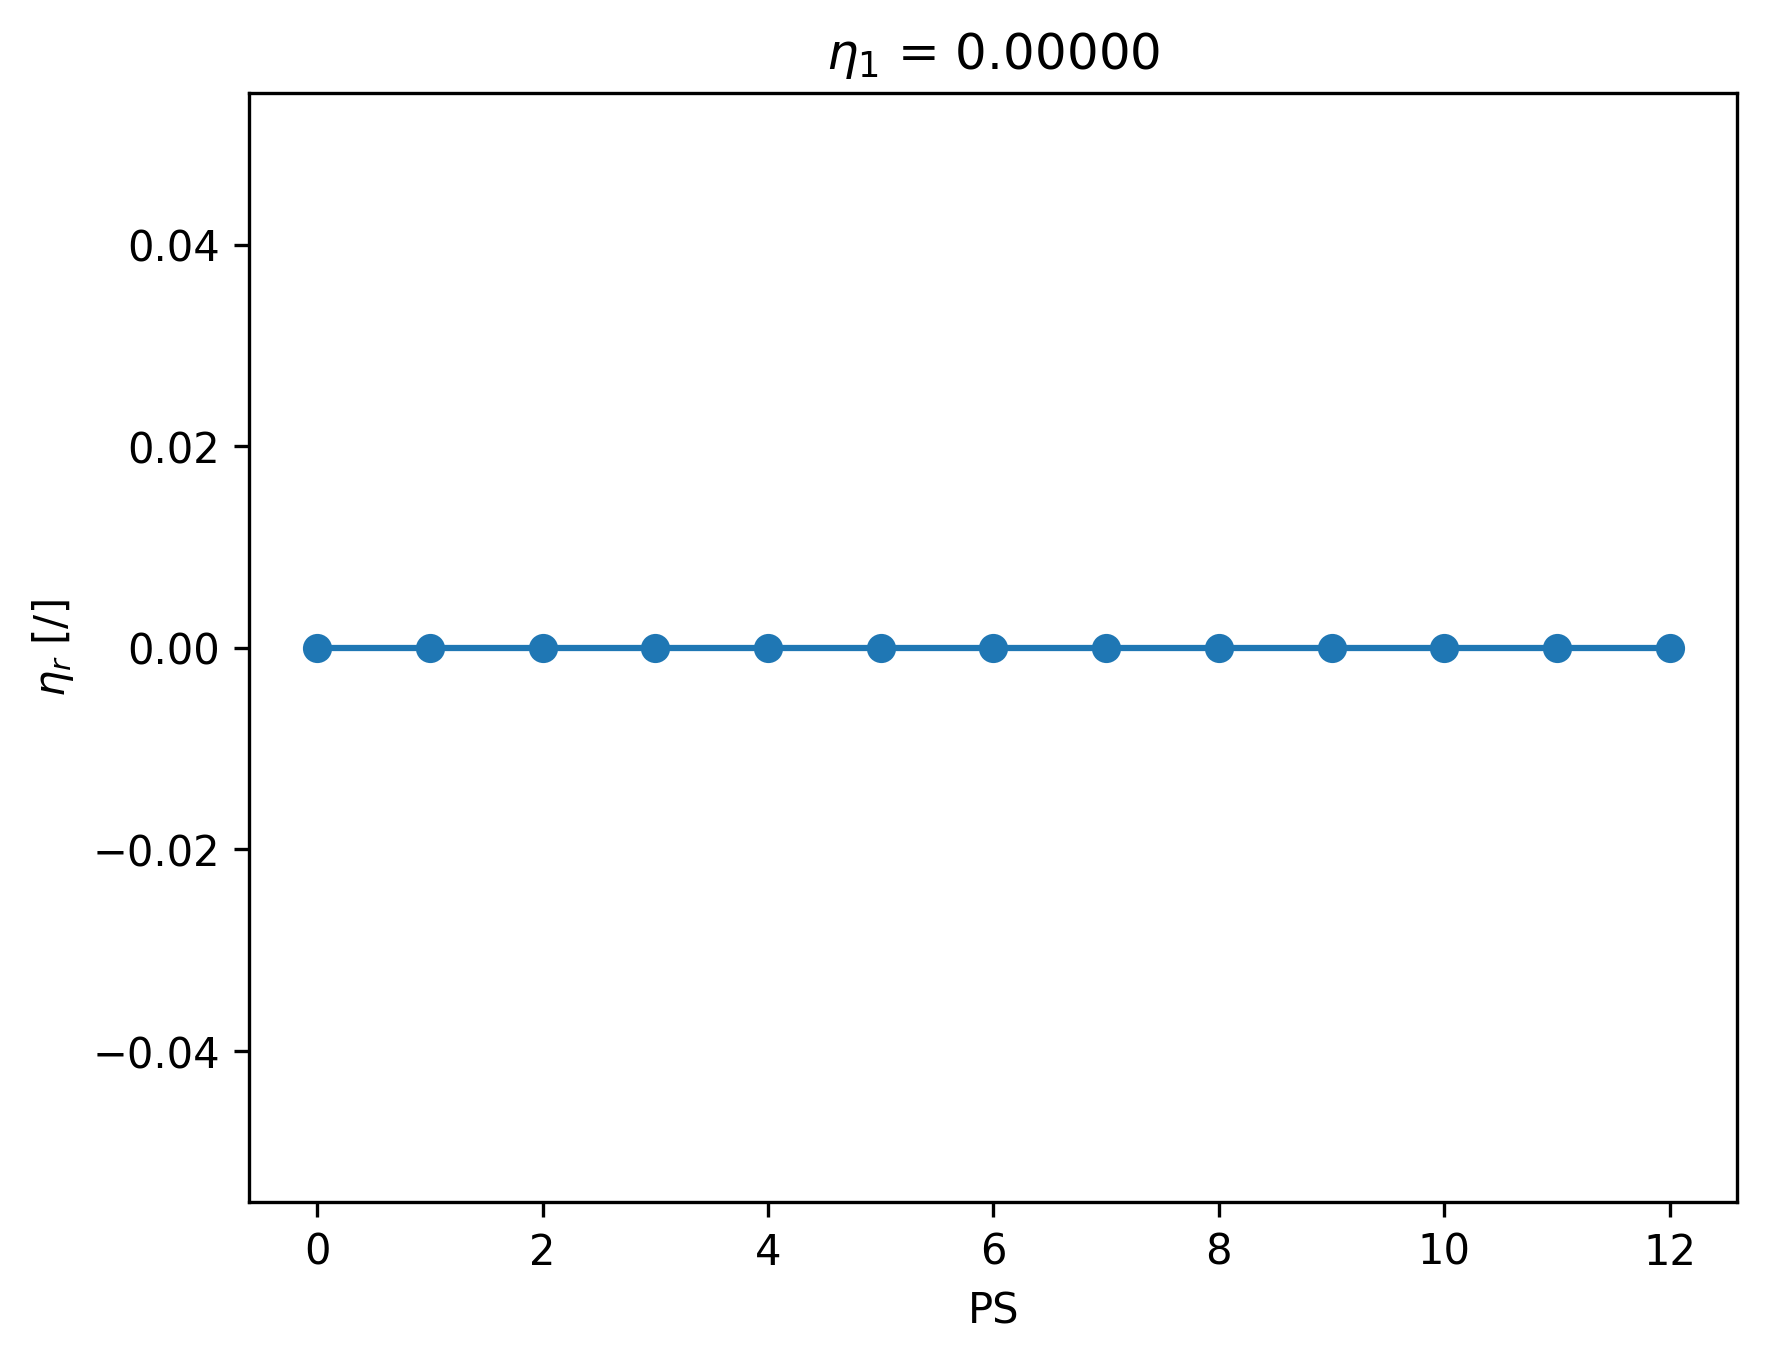

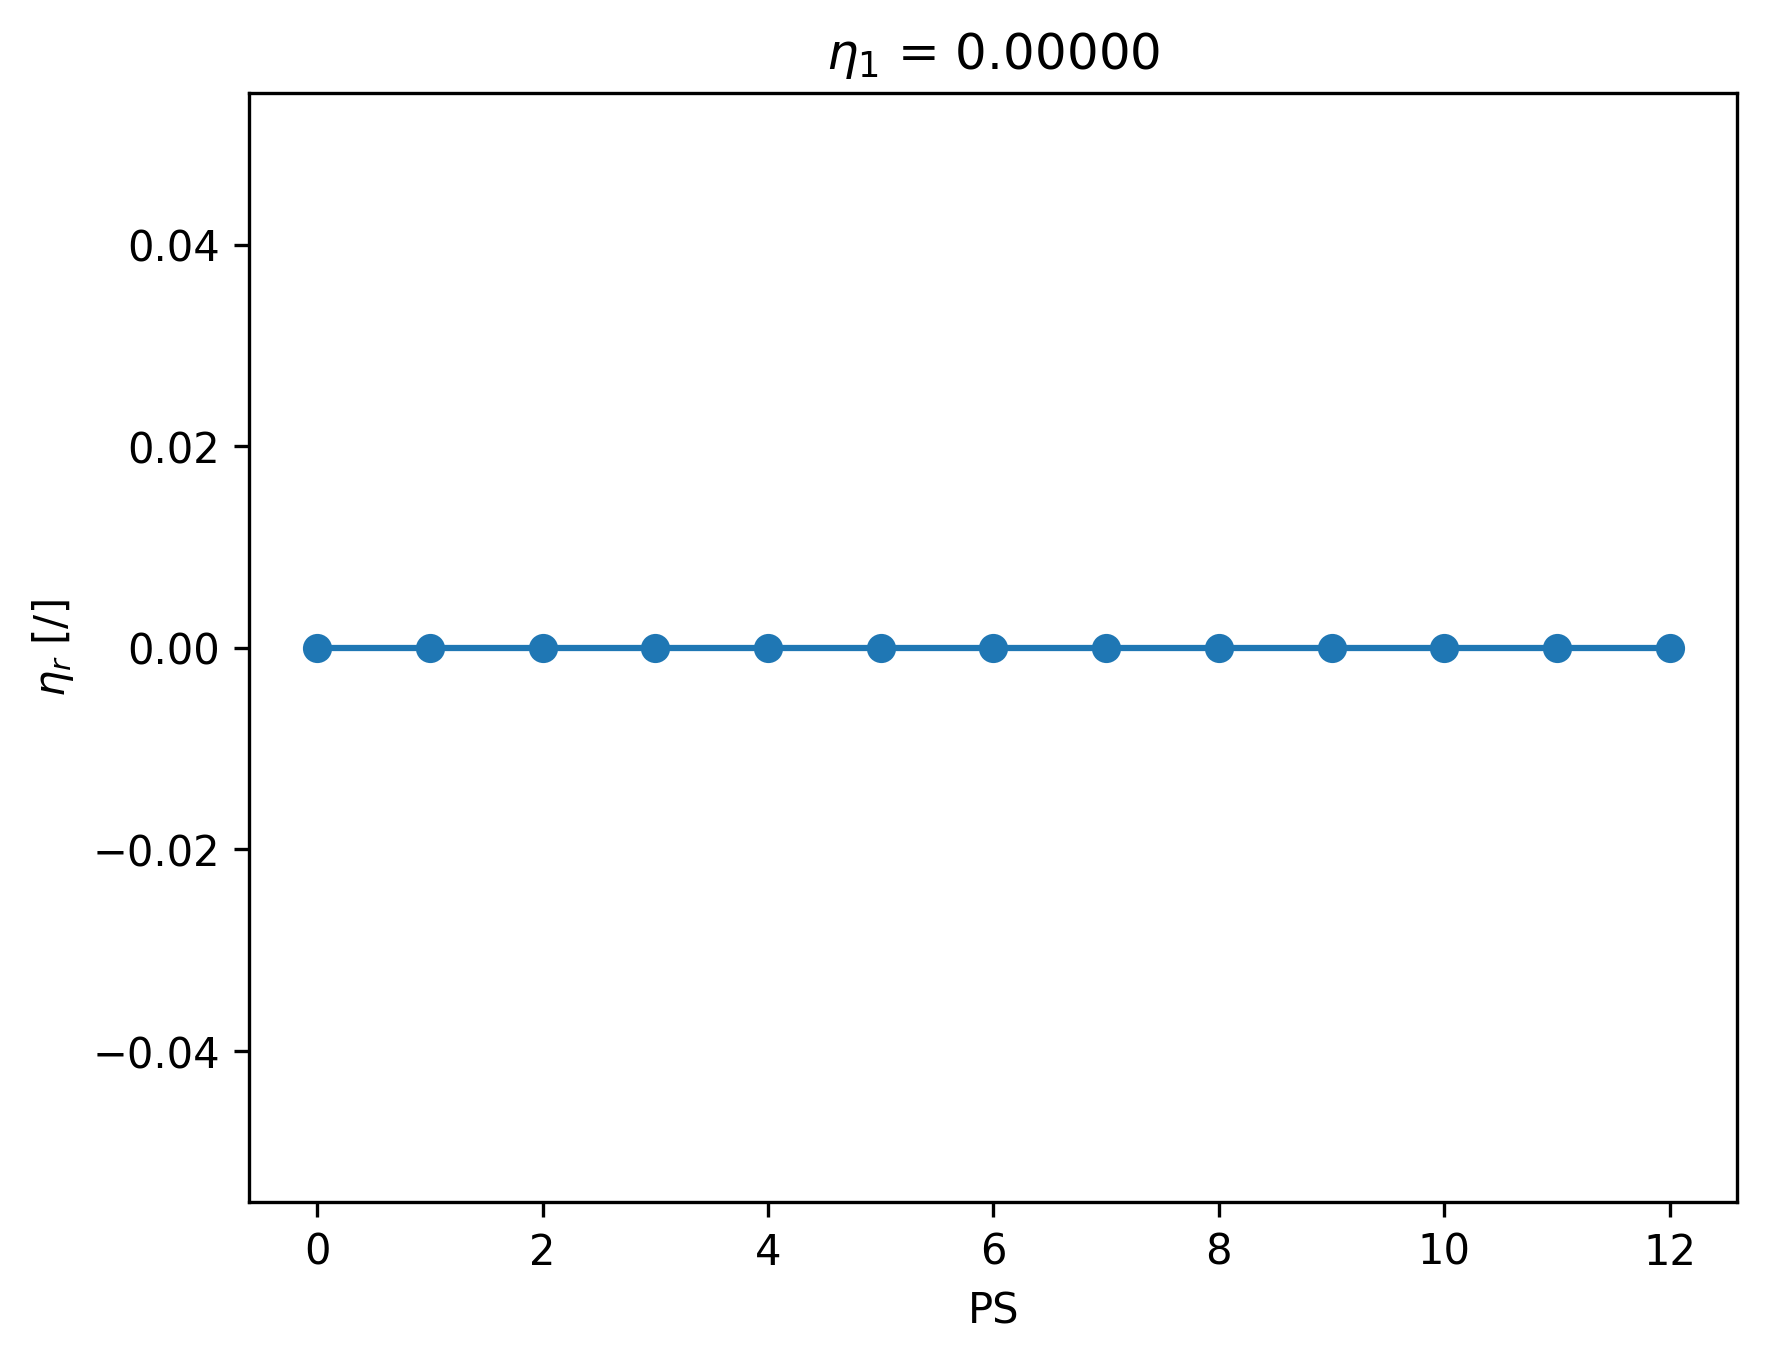

In [113]:
plt.subplots(dpi=300)
plt.plot(dampr[:,0], 'o-');
plt.ylabel(r'$\eta_r$ [/]');
plt.xlabel('PS');
plt.title(r'$\eta_1$ = %.5f' %np.average(dampr[:,0]));

### Modalna oblika

In [115]:
phi1 = np.sqrt(Ar[0,0])

In [116]:
mode_shape = Ar[:,0]/phi1

C:\Users\Tim\AppData\Local\Temp\ipykernel_26768\4258551111.py:1: RuntimeWarning: invalid value encountered in divide
  mode_shape = Ar[:,0]/phi1
C:\Users\Tim\AppData\Local\Temp\ipykernel_26768\4258551111.py:1: RuntimeWarning: invalid value encountered in divide
  mode_shape = Ar[:,0]/phi1


In [117]:
mode_shape

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

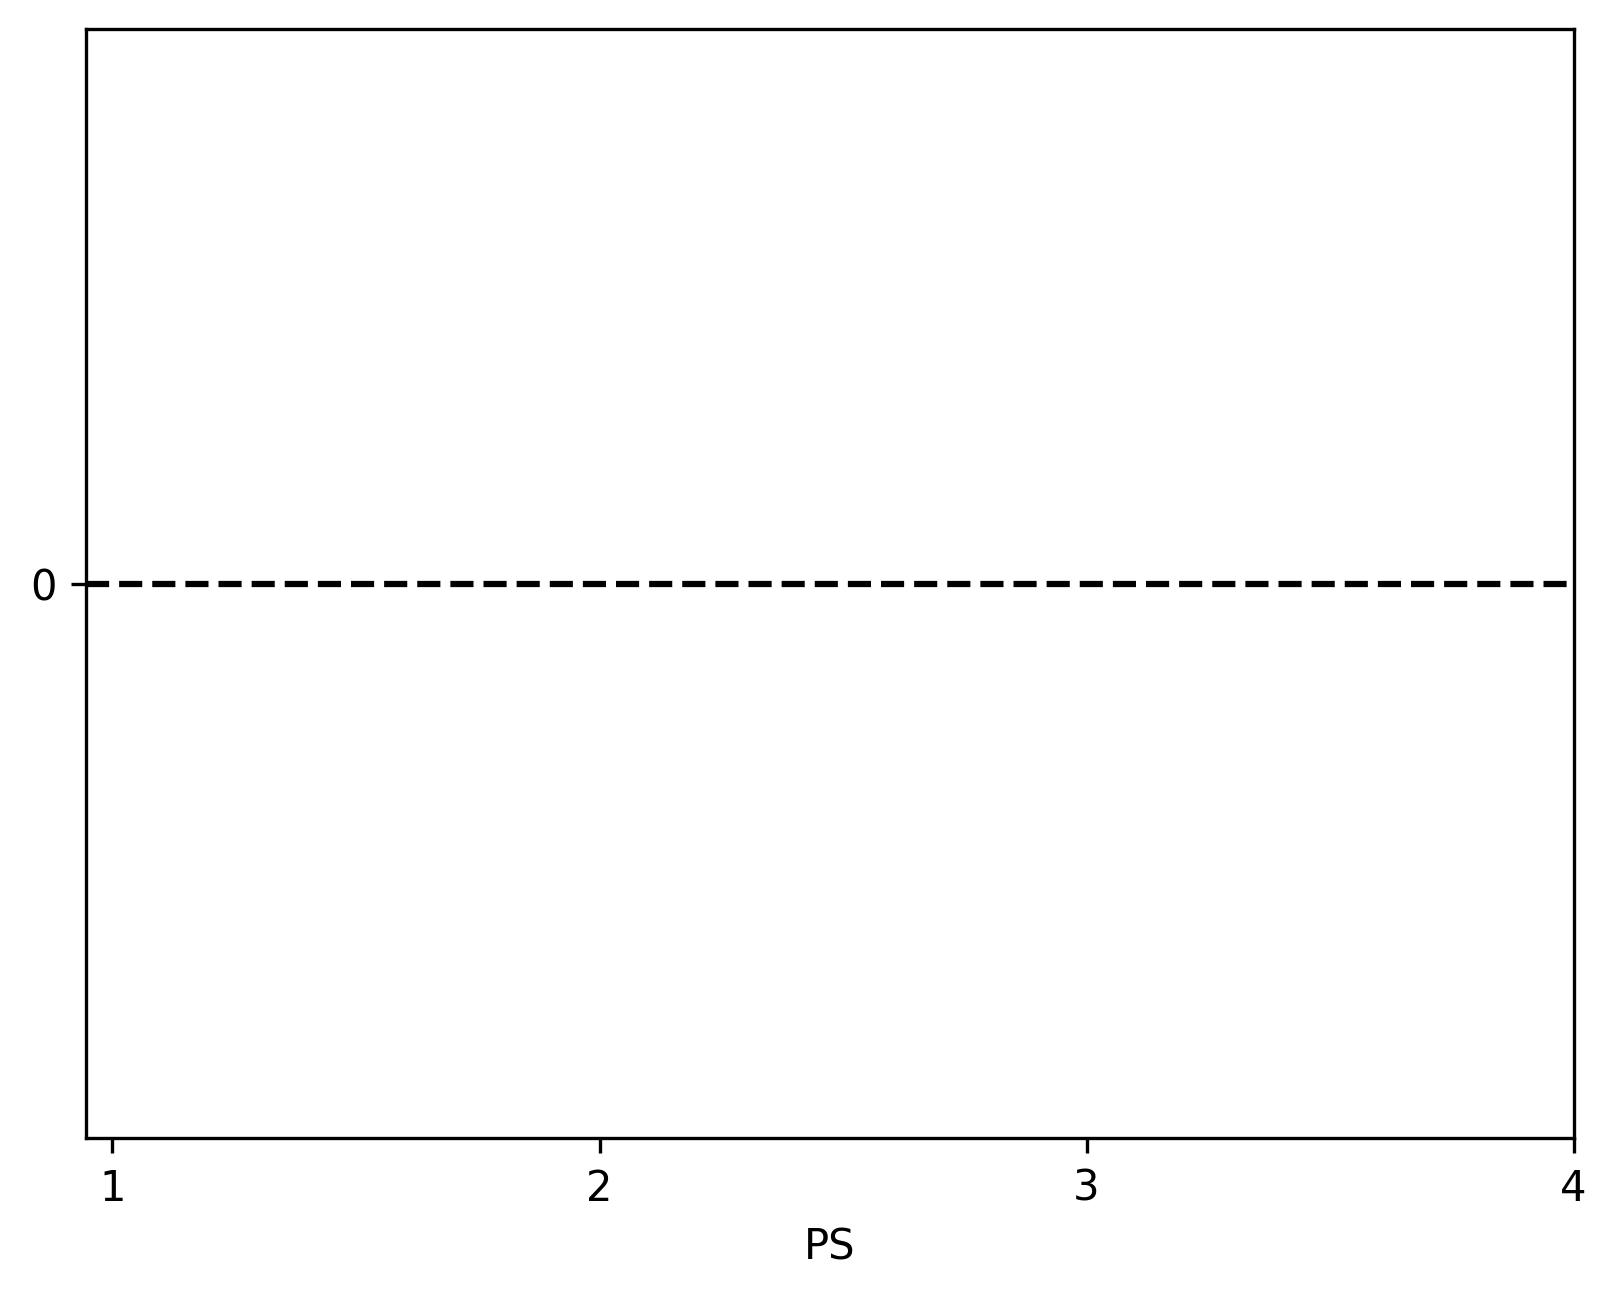

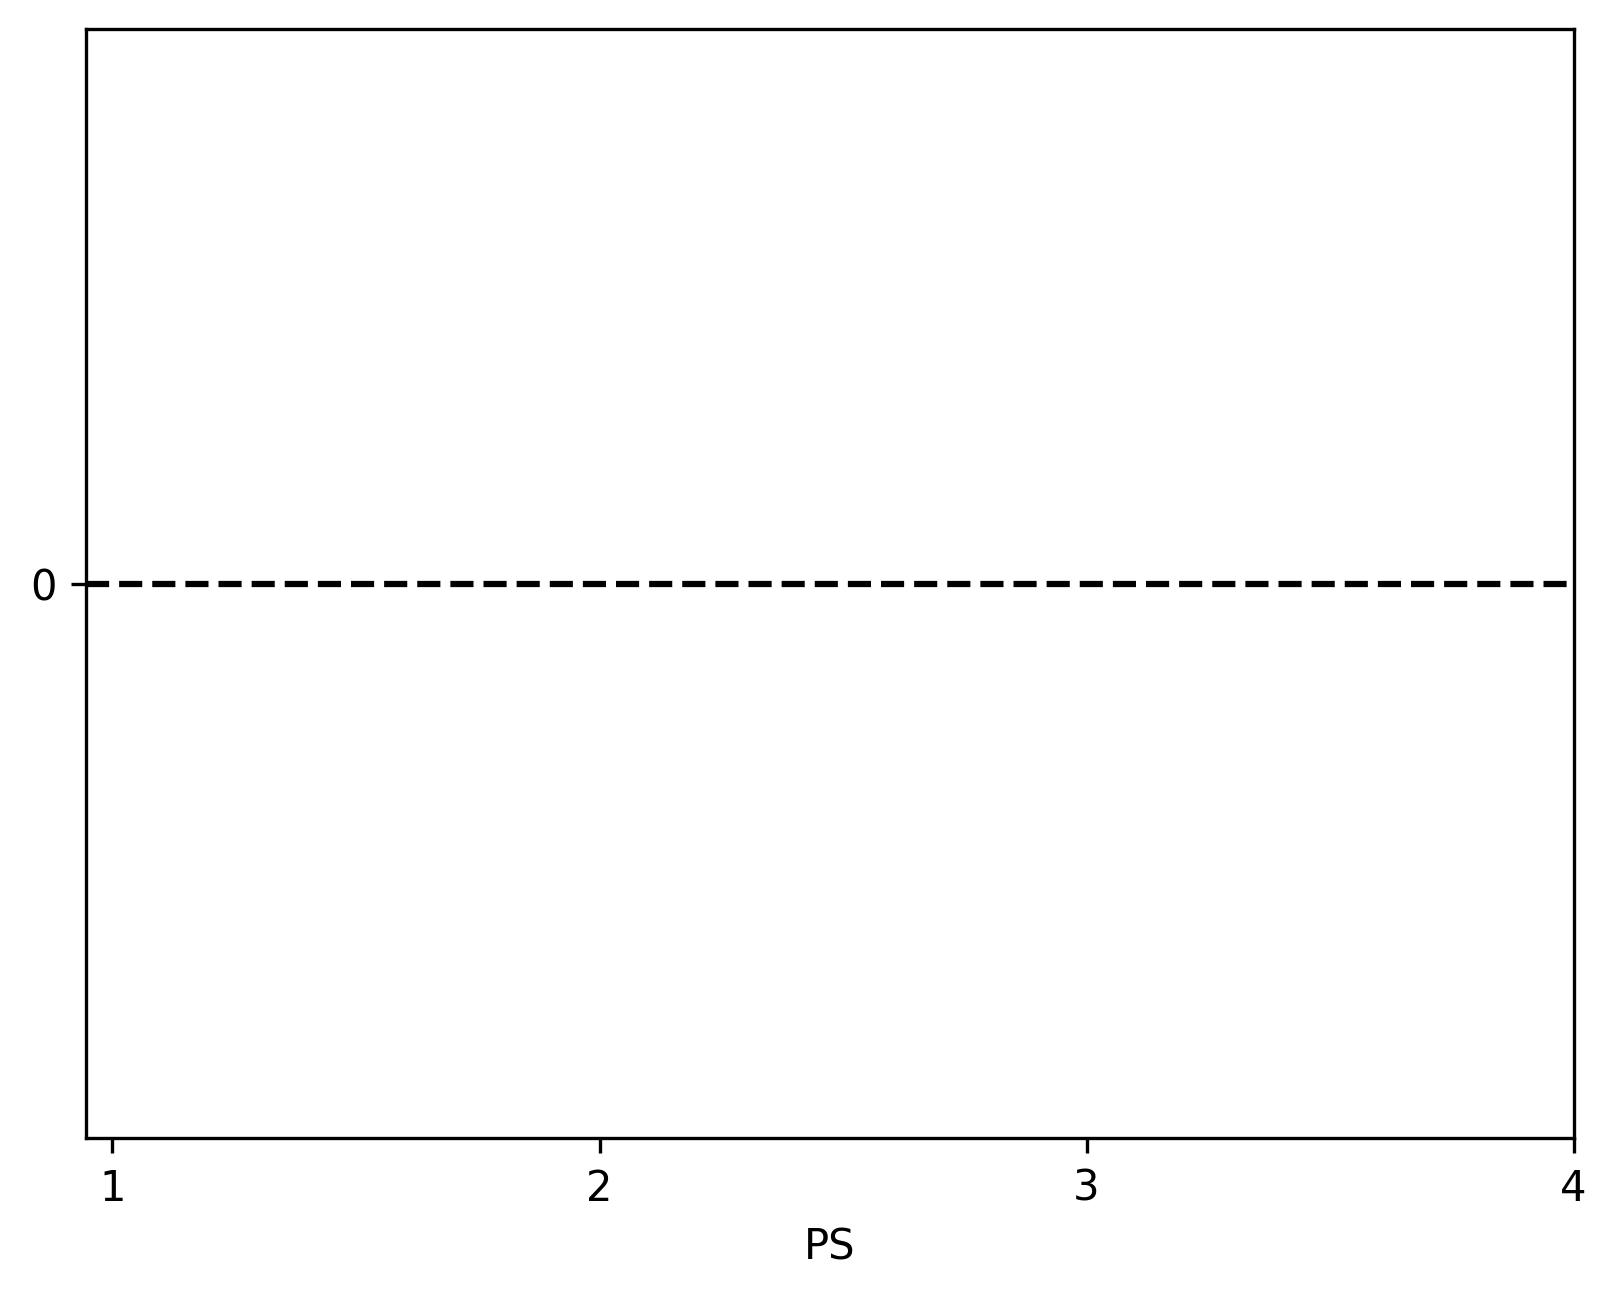

In [118]:
plt.subplots(dpi=300)
plt.plot(mode_shape);
plt.axhline(0, ls='--', color='k')
plt.yticks([0],[0]);
plt.xticks([0,1,2,3], [1,2,3,4])
plt.xlabel('PS');

# Animation thingy - vaja 9

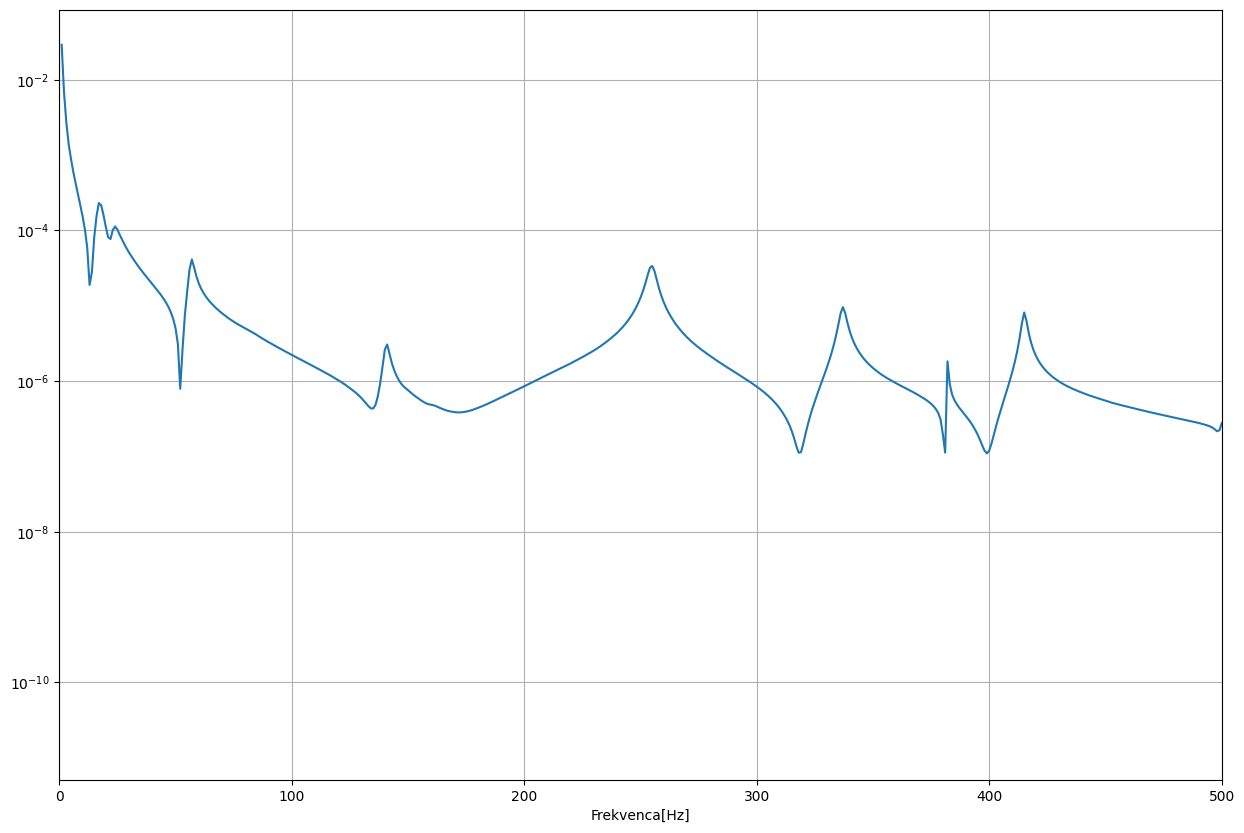

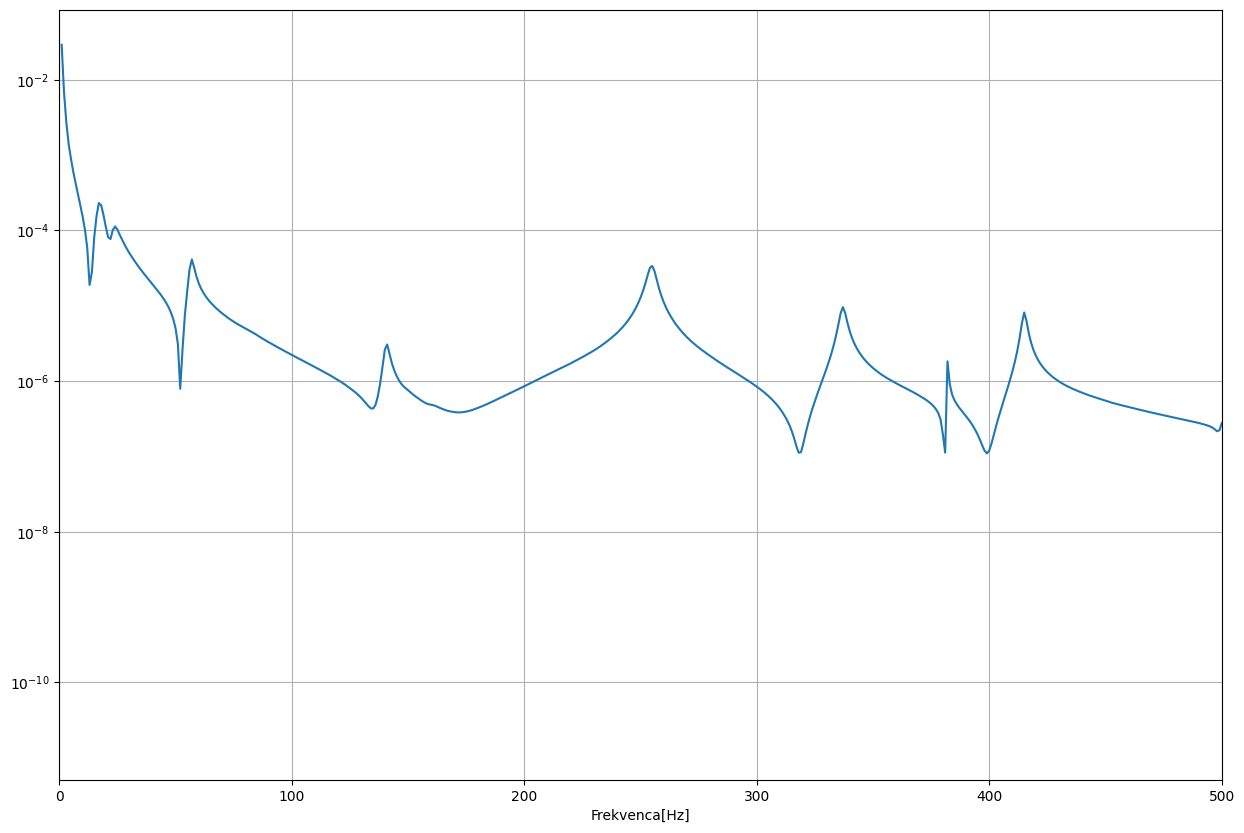

In [126]:
plt.figure(figsize=(15,10));
plt.semilogy(freq[1:],np.abs(H[7,1:])); #logaritmski plot 
plt.xlabel('Frekvenca[Hz]');
plt.xlim(0,500)
plt.grid()

In [129]:
freq.shape

(12801,)

(12801,)

In [132]:
Y2.shape

(12800,)

(12800,)

In [131]:
_id = pyFBS.modal_id(freq[1:],Y2)


IndexError: tuple index out of range

IndexError: tuple index out of range